In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("Traffic.ipynb")

# Final Project: Traffic
## Due Date: Monday, December 13th, 11:59 PM
## Collaboration Policy

Data science is a collaborative activity. While you may talk with other groups about
the project, we ask that you **write your solutions within your own groups**. If you do
discuss the assignments with others outside of your group please **include their names** at the top
of your notebook.

# Data 100 Final Project: Traffic in a post-lockdown world

**Scenario:** You're a data scientist at Uber -- sitting in a war room on March 16, 2020, 1 day after California-wide COVID lockdown measures began and the day shelter-in-place measures are announced in the bay area. The entire data science department is on fire: All of your existing traffic models have regressed *significantly*. Given the sudden change in traffic patterns (i.e., no traffic at all), the company's traffic estimates are wildly incorrect. This is a top priority for the company. Since traffic estimates are used directly for pricing strategies, this is actively costing the company millions every hour. You are tasked with fixing these models.

**Takeaways:** How do you "fix" models that have learned biases from pre-lockdown traffic? How do you train new ones, with just 24 hours of data? What sorts of data do you examine, to better understand the situation? In the midst of company-wide panic, you'll need a strong inferential acumen to lead a robust data science response. In this project, we'll walk you through a simulated war room data science effort, culminating in some strategies to fix models online, which are experiencing large distributional shifts in data.

For this project, we'll explore traffic data provided by the **Uber Movement** dataset, specifically around the start of COVID shutdowns in March 2020. Your project is structured around the following ideas:

```
1. Guided data cleaning: Clustering data spatially
    a. Load Uber traffic speeds dataset
    b. Map traffic speeds to Google Plus Codes (spatially uniform)
        i. Load node-to-gps-coordinates data
        ii. Map traffic speed to GPS coordinates
        iii. Convert GPS coordinates to plus code regions
        iv. Sanity check number of plus code regions in San Francisco
        v. Plot a histogram of the standard deviation in speed, per plus code region.
    c. Map traffic speeds to census tracts (spatially non-uniform)
        i. Download census tracts geojson
        ii. Map traffic speed to census tracts
        iii. Sanity check number of census tracts in San Francisco with data.
        iv. Plot a histogram of the standard deviation in speed, per census tract.
    d. What defines a "good" or "bad" spatial clustering?
2. Guided EDA: Understanding COVID lockdown impact on traffic
    a. How did lockdown affect average traffic speeds?
        i. Sort census tracts by average speed, pre-lockdown.
        ii. Sort census tracts by average speed, post-lockdown.
        iii. Sort census tracts by change in average speed, from pre to post lockdown.
        iv. Quantify the impact of lockdown on average speeds.
        v. Quantify the impact of pre-lockdown average speed on change in speed.
    b. What traffic areas were impacted by lockdown?
        i. Visualize heatmap of average traffic speed per census tract, pre-lockdown.
        ii. Visualize change in average daily speeds pre vs. post lockdown.
        iii. Quantify the impact of lockdown on daily speeds, spatially.
3. Open-Ended EDA: Understanding lockdown impact on traffic times
    a. Download Uber Movement (Travel Times) dataset
4. Guided Modeling: Predict traffic speed post-lockdown
    a. Predict daily traffic speed on pre-lockdown data
        i. Assemble dataset to predict daily traffic speed.
        ii. Train and evaluate linear model on pre-lockdown data.
    b. Understand failures on post-lockdown data
        i. Evaluate on post-lockdown data
        ii. Report model performance temporally
    c. "Fix" model on post-lockdown data
        i. Learn delta off of a moving bias
        ii. Does it "solve itself"? Does the pre-lockdown model predict, after the change point?
        iii. Naively retrain model with post-lockdown data
        iv. What if you just ignore the change point?
5. Open-Ended Modeling: Predicting travel times post-lockdown
```

Concepts tested: regex, pivot, join, grouping, inferential thinking

In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import csv
import json
import os
import contextily as cx
from collections import defaultdict
import re
from typing import Callable

from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

from zipfile import ZipFile
zf = ZipFile('data.zip', 'r')
zf.extractall('.')

# more readable exceptions
%pip install --quiet iwut
%load_ext iwut
%wut on

Note: you may need to restart the kernel to use updated packages.


# Step 1 - Guided Data Cleaning: Partitioning Data Spatially

Our hope is answer: How do we group information spatially? We'll specifically look at 2 ways of partitioning data spatially, to understand the impact of spatial partitioning strategies on our analyses:

1. Dividing the world uniformly into slices, like Google's plus codes.
2. Dividing the world according to population, using census tracts.

In this step, we'll load the following datasets that we'll need for this project:

- Daily travel times from Uber Movement data in March 2020 from San Francisco, by census tract
- Daily traffic speeds from Uber Movement data in Q1 2020 from San Francisco, between OSM nodes
- Census tracts dividing San Francisco by GPS coordinates
- Mapping from OSM nodes to GPS coordinates

There are several terms and concepts to get familiar with upfront:

- **Open Street Maps (OSM)** provides nodes (points in space, [wiki](https://wiki.openstreetmap.org/wiki/Node)) and ways (segments between nodes [wiki](https://wiki.openstreetmap.org/wiki/Way)). These IDs are used in the Uber Movement dataset to identify streets in the traffic speeds dataset.
- **Census Tracts** provided by the county of San Francisco geographically divides space according to the US 2010 Census. This is used in the Uber Movement dataset to identify regions of differing travel times.

## 1.a. Load Uber traffic speeds dataset

The dataset is located at `data/movement-speeds-daily-san-francisco-2020-3.csv`. **Load this dataset into a dataframe.**

*The original dataset from Uber was provided hourly and took up 2.1 GB on disk, which means it couldn't fit into your 1GB of RAM. You can find the dataset preparation script at `data/PrepareTrafficDataset.ipynb` which aggregated within each day, reducing the dataset to just 55MB on disk.*

*This was originally going to be question in this project, but it takes 22 minutes to run. Better yet, if you mess up, your kernel dies and you start over. We deemed it too frustrating and preprocessed the dataset to spare you the pain... but just know that this is a real-world issue!*

<!--
BEGIN QUESTION
name: q1a
points: 1
-->

In [3]:
# Load Uber Movement (Movement Speeds) dataset into dataframe
speeds_to_nodes = pd.read_csv("data/movement-speeds-daily-san-francisco-2020-3.csv")

speeds_to_nodes

osm_start_node_id  osm_end_node_id  day  speed_mph_mean
0                   281266        702258940    1       59.674042
1                   281266        702274215    1       68.444042
2                   302876        240259516    1       66.446500
3                   302878        437325360    1       65.516850
4                   302883         65381191    1       61.880556
...                    ...              ...  ...             ...
1586647         6569140748       1350115374   31       68.484833
1586648         6570476556       4551993266   31       36.837000
1586649         6573249373       4911384010   31       39.021000
1586650         6573553681        256888796   31       68.728333
1586651         6577722252        209835741   31       68.905538

[1586652 rows x 4 columns]

In [4]:
grader.check("q1a")

q1a results: All test cases passed!

<!-- BEGIN QUESTION -->

## 1.b. Map traffic speed to Google Plus Codes

Google Plus Codes divide up the world uniformly into rectangular slices ([link](https://maps.google.com/pluscodes/)). Let's use this to segment traffic speeds spatially. Take a moment to answer: **Is this spatial structure effective for summarizing traffic speed?** Before completing this section, substantiate your answer with examples of your expectations (e.g., we expect A to be separated from B). After completing this section, substantiate your answer with observations you've made.

<!--
BEGIN QUESTION
name: q1b
points: 2
manual: True
-->

Before completing this section: \
This spatial structure of Google Plus Codes, where we divide the world up uniformly into rectangular slices, can be effective. We expect different areas of the world to have different average speeds, as metropolitan areas would likely have lower average traffic speeds due to a higher frequency of traffic lights and traffic jams, whereas more rural areas would have higher average traffic speeds due to less traffic jams. Hence, similar areas should have similar average speeds, and dividing the world up uniformly into rectangular slices using the Google Plus Codes method could be an effective spatial structure for summarizing traffic speed.


After completing this section: \
Differences between subpopulations: variance_average_by_pluscode = 10.13573858675904 \
Differences within a subpopulation: average_variance_by_pluscode = 8.684748294968637 \
The differences within a subpopulation is smaller than the differences between subpopulations of Google Plus Codes. Since we want our clusters and subpopulations to be similar and have a small difference within the subpopulation, and since the differences with clusters of plus codes is much smaller (and smaller than differences between subpopulations), this means that the plus codes do capture meaningful subpopulations and are good spatial clustering system.

<!-- END QUESTION -->



### 1.b.i. Load Node-to-GPS-Coordinate Data

In this substep, we'll load a mapping from OSM nodes to GPS coordinates. The dataset is provided in a gzip'ed XML file from OpenStreetMaps (OSM). The mapping from OSM nodes to GPS coordinates was downloaded from https://download.bbbike.org/osm/bbbike/SanFrancisco/SanFrancisco.osm.gz. We've downloaded this for you, to avoid any issues with OSM updates.

**If** you try to load the provided `.osm` (an `.xml` in disguise) using Python's built-in XML utilities **(by uncommenting the last 2 lines in the below cell)**, you will hit an out-of-memory error, as your kernel is forced to restart.

In [5]:
# [OSM] - Read the OSM XML and extract mapping from node ID to GPS coordinates
PATH_OSM = os.path.expanduser('data/SanFrancisco.osm')

# Runs out of memory! File itself is 430 MB, even when filtering out
# irrelevant rows, and remaining 3M rows are too expensive to parse,
# resulting in OOM

# import xml.etree.ElementTree as ET
# _tree = ET.parse(PATH_OSM)

Your above code hits a memory error, so instead, we will use our handy-dandy tool--regex--from earlier in the semester to load just the parts of the file that we need. **Given the XML snippet below, write a regex pattern to extract OSM node ID, latitude, and longitude.** (The first capture group should be node ID. The second should be latitude, and the third should be longitude.) A snippet of the XML is included below ([screenshot](https://extract.bbbike.org/extract-screenshots.html)):

```
<?xml version='1.0' encoding='UTF-8'?>
<osm version="0.6" generator="osmconvert 0.8.3">
    <bounds minlat="42.4543" minlon="-2.4761999" maxlat="42.4..."/>
    <node id="26861066" lat="42.471111" lon="-2.454722" version="..."/>
        <tag k="name" v="Camping La Playa"/>
        <tag k="tourism" v="camp_site"/>
        <tag k="operator" v="private"/>
        ...
    </node>
    <node id="34793287" lat="42.4713587" lon="-2.4510783" version="..."/>
        <tag k="created_by" v="JOSM"/>
    </node>
    <node id="34793294" lat="42.4610836" lon="-2.4303622" version="..."/>
    <node id="34793297" lat="42.4548363" lon="-2.4287657" version="..."/>
    ...
</osm>
```

In [6]:
# [OSM] - Read the OSM XML using a regex operation instead.
def read_node_lat_lon(path: str, pattern: str, line_condition: Callable):
    """
    Read the provided path line at a line. If the provided regex pattern
    has a match, return the grouped matches as items in a generator.
    
    :param path: Path to read data from
    :param pattern: Regex pattern to test against each line
    :param line_condition: function that returns if we should check regex
        against current line
    """
    with open(path) as f:
        for line in f:
            result = re.search(pattern, line)
            if result is not None and line_condition(result):
                yield int(result.group(1)), float(result.group(2)), float(result.group(3))

In [7]:
node_ids = set(speeds_to_nodes.osm_start_node_id) | set(speeds_to_nodes.osm_end_node_id)

NODE_PATTERN = r'node id="(\d*)" lat="(-?\d*.?\d*)" lon="(-?\d*.?\d*)"'

node_to_gps = pd.DataFrame(read_node_lat_lon(
    PATH_OSM,
    pattern=NODE_PATTERN,
    line_condition=lambda result: int(result.group(1)) in node_ids
), columns=['osm_node_id', 'Latitude', 'Longitude'])
node_to_gps

osm_node_id   Latitude   Longitude
0         26118026  37.675280 -122.389194
1         29891973  37.674935 -122.389130
2         29892598  37.716892 -122.398893
3         30033679  37.599877 -122.376497
4         30033686  37.642167 -122.405946
...            ...        ...         ...
19139   6522255428  37.760543 -122.443563
19140   6522255492  37.759317 -122.444996
19141   6522764204  37.762163 -122.436143
19142   6522764212  37.756061 -122.436761
19143   6522764213  37.761187 -122.440089

[19144 rows x 3 columns]

In [8]:
grader.check("q1bi")

q1bi results: All test cases passed!

### 1.b.ii. Map traffic speed to GPS coordinates.

Traffic speeds are currently connected to OSM nodes. You will then use the mapping from OSM nodes to GPS coordinates, to map traffic speeds to GPS coordinates. **Link each traffic speed measurement to the GPS coordinate of its starting node.**

**Note**: For simplicity, assume each segment is associated with the node it *starts* with. 

**Hint**: Not all nodes are included in the OSM node mapping. Make sure to ignore any nodes without valid GPS coordinates.

<!--
BEGIN QUESTION
name: q1bii
points: 3
-->

In [9]:
# Find mapping from traffic speeds to GPS coordinates
speeds_to_gps = speeds_to_nodes.merge(node_to_gps, left_on='osm_start_node_id', right_on='osm_node_id')
speeds_to_gps

osm_start_node_id  osm_end_node_id  day  speed_mph_mean  osm_node_id  \
0                26118026        259458979    1       64.478000     26118026   
1                26118026        259458979    2       62.868208     26118026   
2                26118026        259458979    3       62.211750     26118026   
3                26118026        259458979    4       62.192458     26118026   
4                26118026        259458979    5       61.913292     26118026   
...                   ...              ...  ...             ...          ...   
417634         4069109544        615120176   30       38.956000   4069109544   
417635         5448539901         65446993   16       25.627000   5448539901   
417636          302964668       4069109544   19       40.802000    302964668   
417637          302964668       4069109544   20       36.076000    302964668   
417638         5022068066        302964668   19       39.592000   5022068066   

         Latitude   Longitude  
0       37.675280 -122.389194  
1       37.675280 -122.389194  
2       37.675280 -122.389194  
3       37.675280 -122.389194  
4       37.675280 -122.389194  
...           ...         ...  
417634  37.732039 -122.507126  
417635  37.622476 -122.413763  
417636  37.732418 -122.507206  
417637  37.732418 -122.507206  
417638  37.733635 -122.507100  

[417639 rows x 7 columns]

In [10]:
grader.check("q1bii")

q1bii results: All test cases passed!

### 1.b.iii. Convert GPS coordinates to plus code regions.

Plus code regions divide up the world into uniformly-sized rectangles, which we will assume is 0.012 degrees latitudiunally and longitudinally. **For each traffic speed row, compute the plus code region it belongs to**, based on its GPS coordinates.

To do this, we suggest computing a latitudinal index `plus_latitude_idx` and a longitudinal index `plus_longitude_idx` for the plus code region each row belongs to. *Make sure these columns are integer-valued*.

**Hint**: If you're running into nans, you did 1.b.ii. incorrectly!

<!--
BEGIN QUESTION
name: q1biii
points: 3
-->

In [11]:
speeds_to_gps['plus_latitude_idx'] = speeds_to_gps['Latitude']//0.012
speeds_to_gps['plus_longitude_idx'] = speeds_to_gps['Longitude']//0.012

speeds_to_gps

osm_start_node_id  osm_end_node_id  day  speed_mph_mean  osm_node_id  \
0                26118026        259458979    1       64.478000     26118026   
1                26118026        259458979    2       62.868208     26118026   
2                26118026        259458979    3       62.211750     26118026   
3                26118026        259458979    4       62.192458     26118026   
4                26118026        259458979    5       61.913292     26118026   
...                   ...              ...  ...             ...          ...   
417634         4069109544        615120176   30       38.956000   4069109544   
417635         5448539901         65446993   16       25.627000   5448539901   
417636          302964668       4069109544   19       40.802000    302964668   
417637          302964668       4069109544   20       36.076000    302964668   
417638         5022068066        302964668   19       39.592000   5022068066   

         Latitude   Longitude  plus_latitude_idx  plus_longitude_idx  
0       37.675280 -122.389194             3139.0            -10200.0  
1       37.675280 -122.389194             3139.0            -10200.0  
2       37.675280 -122.389194             3139.0            -10200.0  
3       37.675280 -122.389194             3139.0            -10200.0  
4       37.675280 -122.389194             3139.0            -10200.0  
...           ...         ...                ...                 ...  
417634  37.732039 -122.507126             3144.0            -10209.0  
417635  37.622476 -122.413763             3135.0            -10202.0  
417636  37.732418 -122.507206             3144.0            -10209.0  
417637  37.732418 -122.507206             3144.0            -10209.0  
417638  37.733635 -122.507100             3144.0            -10209.0  

[417639 rows x 9 columns]

In [12]:
grader.check("q1biii")

q1biii results: All test cases passed!

### 1.b.iv. Sanity check number of plus code regions in San Francisco.

**Compute the number of unique plus codes found in your dataset**. You're checking that the number isn't ridiculous, like 1, or 100,000 (SF is 231 sq mi, so 100k tracts would average 12 sq ft per tract).

If you followed the suggestion above, this is the number of unique `(plus_latitude_idx, plus_longitude_idx)` pairs.

<!--
BEGIN QUESTION
name: q1biv
points: 4
-->

In [13]:
# You're expecting 276 plus codes here. Don't just type "276" 
# below to pass the autograder. The goal is to sanity check your 
# dataframe!
num_pluscode_regions = len(speeds_to_gps.value_counts(['plus_latitude_idx', 'plus_longitude_idx']))
num_pluscode_regions

276

In [14]:
grader.check("q1biv")

q1biv results: All test cases passed!

<!-- BEGIN QUESTION -->

### 1.b.v. How well do plus code regions summarize movement speeds?

The following will give us an idea of how well the average represents traffic speed per plus code region. For these questions, we'll refer to a "plus code region" as a "cluster":

1. **Plot a histogram of the within-cluster standard deviation**.
2. **Compute across-cluster average of within-cluster standard deviation**.
3. **Compute across-cluster standard deviation of within-cluster average speeds**.
4. **Is this average variance reasonable?** To assess what "reasonable" means, consider these questions and how to answer them: (1) Do plus codes capture meaningful subpopulations? (2) Do differences between subpopulations outweigh differences within a subpopulation? Use the statistics above to answer these questions, and compute any additional statistics you need. Additionally explain *why these questions are important to assessing the quality of a spatial clustering*.

**Hint**: Run the autograder first to ensure your variance average and average variance are correct, before starting to draw conclusions.

In the first cell, write your written answers. In the second cell, complete the code.

<!--
BEGIN QUESTION
name: q1bv1
points: 2
manual: True
-->



Q: Do plus codes capture meaningful subpopulations? Do differences between subpopulations outweigh differences within a subpopulation? Is this average standard deviation reasonable?\
Differences between subpopulations: variance_average_by_pluscode = 10.13573858675904 \
Differences within a subpopulation: average_variance_by_pluscode = 8.684748294968637 \
The average within-cluster standard deviation is reasonable. \
The differences within a subpopulation is smaller than the differences between subpopulations. Since we want our clusters and subpopulations to be similar and have a small difference within clusters, and since the differences within clusters of plus codes is small and smaller than differences between subpopulations, this means that the plus codes do capture meaningful subpopulations and are a good spatial clustering system.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!--
BEGIN QUESTION
name: q1bv2
points: 2
manual: True
-->

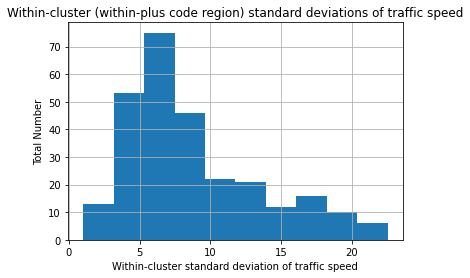

In [15]:
# compute traffic speed variance in each plus code region
speed_variance_by_pluscode = speeds_to_gps[['speed_mph_mean', 'plus_latitude_idx', 'plus_longitude_idx']].groupby(['plus_latitude_idx', 'plus_longitude_idx']).std() 

# plot a histogram - Question 1
speed_variance_by_pluscode.hist()
plt.title('Within-cluster (within-plus code region) standard deviations of traffic speed')
plt.xlabel('Within-cluster standard deviation of traffic speed')
plt.ylabel('Total Number')

#Question 2
average_variance_by_pluscode = speed_variance_by_pluscode['speed_mph_mean'].mean()

#Question 3
speed_mean_by_pluscode = speeds_to_gps[['speed_mph_mean', 'plus_latitude_idx', 'plus_longitude_idx']].groupby(['plus_latitude_idx', 'plus_longitude_idx']).mean() 
variance_average_by_pluscode = speed_mean_by_pluscode['speed_mph_mean'].std()

<!-- END QUESTION -->

<!--
BEGIN QUESTION
name: q1bv3
points: 3
-->

In [16]:
speed_variance_by_pluscode

speed_mph_mean
plus_latitude_idx plus_longitude_idx                
3128.0            -10210.0                  3.650232
                  -10198.0                 20.704487
                  -10194.0                 12.342234
3129.0            -10210.0                  4.083821
                  -10199.0                 21.390912
...                                              ...
3160.0            -10198.0                 15.293632
                  -10197.0                 17.915911
                  -10196.0                 14.243592
                  -10195.0                 12.237229
                  -10194.0                 17.590817

[276 rows x 1 columns]

In [17]:
grader.check("q1bv3")

q1bv3 results: All test cases passed!

## 1.c. Map traffic speed to census tract.

Census tracts divide the space much less uniformly, subdividing regions that we were interested in into smaller zones. This suggests promise in providing informative spatial segments. Note that the daily traffic speeds are provided between OpenStreetMap (OSM) nodes, so we'll need to map nodes to census tracts somehow.

Above, we've mapped traffic speeds to GPS coordinates. Below, we'll then link GPS coordinates to census tracts, to complete the mapping from traffic speeds to census tracts.

### 1.c.i. Download Census Tracts Geojson

**Load the census tracts geojson.** Make sure to see the relevant [geopandas io documentation](https://geopandas.org/docs/user_guide/io.html) to see how to load a geojson.

**Hint**: It should take you just one line to load.

<!--
BEGIN QUESTION
name: q1ci
points: 1
-->

In [18]:
PATH_TRACTS = os.path.expanduser('data/san_francisco_censustracts.json')
tract_to_gps = gpd.read_file(PATH_TRACTS)
tract_to_gps['MOVEMENT_ID'] = tract_to_gps['MOVEMENT_ID'].astype(int)
tract_to_gps

MOVEMENT_ID                                       DISPLAY_NAME  \
0               1                            Sargent Creek, San Ardo   
1               2  400 Northumberland Avenue, Redwood Oaks, Redwo...   
2               3                18300 Sutter Boulevard, Morgan Hill   
3               4          2700 Stoughton Way, Sheffield, Sacramento   
4               5     3200 Huntsman Drive, Rosemont Park, Sacramento   
...           ...                                                ...   
2705         2706                     10000 Bobbell Drive, Elk Grove   
2706         2707                        400 Ericwood Court, Manteca   
2707         2708  200 Westview Drive, Sunshine Gardens, South Sa...   
2708         2709                1200 Halyard Drive, West Sacramento   
2709         2710   2500 Clubhouse Drive West, Whitney Oaks, Rocklin   

                                               geometry  
0     MULTIPOLYGON (((-121.59511 36.11126, -121.5401...  
1     MULTIPOLYGON (((-122.22463 37.46507, -122.2236...  
2     MULTIPOLYGON (((-121.67978 37.15859, -121.6719...  
3     MULTIPOLYGON (((-121.35921 38.57175, -121.3462...  
4     MULTIPOLYGON (((-121.37512 38.55309, -121.3715...  
...                                                 ...  
2705  MULTIPOLYGON (((-121.48392 38.40874, -121.4787...  
2706  MULTIPOLYGON (((-121.22695 37.82647, -121.2185...  
2707  MULTIPOLYGON (((-122.45179 37.66912, -122.4506...  
2708  MULTIPOLYGON (((-121.58346 38.57860, -121.5827...  
2709  MULTIPOLYGON (((-121.25720 38.82472, -121.2545...  

[2710 rows x 3 columns]

In [19]:
grader.check("q1ci")

q1ci results: All test cases passed!

### 1.c.ii Map traffic speed to census tracts.

You will need to *spatially join* the (1) mapping from traffic speed to GPS coordinates `speed_to_gps` and (2) the mapping from GPS coordinates to boundaries of census tracts `tract_to_gps` to group all traffic speeds by census tract. This "spatial join" is an advanced feature recently released (as of time of writing, in Oct 2021) in geopandas, which allows us to connect single points to their enclosing polygons. You will do this question in 3 parts:

1. Convert the last dataframe `speeds_to_gps` into a geopandas dataframe `speeds_to_points`, where GPS coordinates are now geopandas points. See this tutorial: https://geopandas.org/gallery/create_geopandas_from_pandas.html#From-longitudes-and-latitudes
2. Set the coordinate-system for the new geopandas dataframe to the "world geodesic system" [link](https://epsg.io/4326), or in other words, the coordinate system that GPS coordinates are reported in.
3. Compute a spatial join between census tracts `tract_to_gps` and the geopandas traffic speeds `speeds_to_points`

<!--
BEGIN QUESTION
name: q1cii
points: 4
-->

In [20]:
speeds_to_points = gpd.GeoDataFrame(speeds_to_gps, geometry=gpd.points_from_xy(speeds_to_gps.Longitude, speeds_to_gps.Latitude)).set_crs(crs='EPSG:4326')
speeds_to_tract = speeds_to_points.sjoin(tract_to_gps)
speeds_to_tract

osm_start_node_id  osm_end_node_id  day  speed_mph_mean  osm_node_id  \
0                26118026        259458979    1       64.478000     26118026   
1                26118026        259458979    2       62.868208     26118026   
2                26118026        259458979    3       62.211750     26118026   
3                26118026        259458979    4       62.192458     26118026   
4                26118026        259458979    5       61.913292     26118026   
...                   ...              ...  ...             ...          ...   
416605          110424354        110424978    6       12.834000    110424354   
416606          110424354        110424978    7       15.586000    110424354   
416607          110424354        110424978   10       13.255000    110424354   
417028          110383033        110424972    7       19.423000    110383033   
417029          110383033        110424972   10       20.706000    110383033   

         Latitude   Longitude  plus_latitude_idx  plus_longitude_idx  \
0       37.675280 -122.389194             3139.0            -10200.0   
1       37.675280 -122.389194             3139.0            -10200.0   
2       37.675280 -122.389194             3139.0            -10200.0   
3       37.675280 -122.389194             3139.0            -10200.0   
4       37.675280 -122.389194             3139.0            -10200.0   
...           ...         ...                ...                 ...   
416605  37.896700 -122.539525             3158.0            -10212.0   
416606  37.896700 -122.539525             3158.0            -10212.0   
416607  37.896700 -122.539525             3158.0            -10212.0   
417028  37.898306 -122.539984             3158.0            -10212.0   
417029  37.898306 -122.539984             3158.0            -10212.0   

                           geometry  index_right  MOVEMENT_ID  \
0       POINT (-122.38919 37.67528)         1729         1730   
1       POINT (-122.38919 37.67528)         1729         1730   
2       POINT (-122.38919 37.67528)         1729         1730   
3       POINT (-122.38919 37.67528)         1729         1730   
4       POINT (-122.38919 37.67528)         1729         1730   
...                             ...          ...          ...   
416605  POINT (-122.53952 37.89670)          498          499   
416606  POINT (-122.53952 37.89670)          498          499   
416607  POINT (-122.53952 37.89670)          498          499   
417028  POINT (-122.53998 37.89831)          498          499   
417029  POINT (-122.53998 37.89831)          498          499   

                                DISPLAY_NAME  
0                      0 Park Lane, Brisbane  
1                      0 Park Lane, Brisbane  
2                      0 Park Lane, Brisbane  
3                      0 Park Lane, Brisbane  
4                      0 Park Lane, Brisbane  
...                                      ...  
416605  600 Throckmorton Avenue, Mill Valley  
416606  600 Throckmorton Avenue, Mill Valley  
416607  600 Throckmorton Avenue, Mill Valley  
417028  600 Throckmorton Avenue, Mill Valley  
417029  600 Throckmorton Avenue, Mill Valley  

[418848 rows x 13 columns]

In [21]:
grader.check("q1cii")

q1cii results: All test cases passed!

### 1.c.iii. Aggregate movement speeds by census tract.

- Create a new dataframe `speeds_by_tract` to group movement speeds by census tract. See the outputted dataframe from 1.c.i. to check how census tracts are identified.
- Always double-check your numbers. **Report the number of census tracts** in your dataset.

<!--
BEGIN QUESTION
name: q1ciii
points: 2
-->

In [22]:
speeds_by_tract = speeds_to_tract[['MOVEMENT_ID', 'speed_mph_mean']].groupby('MOVEMENT_ID').mean()
num_census_tracts = len(speeds_by_tract)
num_census_tracts

295

In [23]:
grader.check("q1ciii")

q1ciii results: All test cases passed!

<!-- BEGIN QUESTION -->

### 1.c.iv. How well do census tracts summarize movement speeds?

The following will give us an idea of how well the average represents traffic speed per plus code region. For these questions, we'll refer to a "census tract" as a "cluster":

1. **Plot a histogram of the within-cluster standard deviation**.
2. **Compute across-cluster average of within-cluster standard deviation**.
3. **Compute across-cluster standard deviation of within-cluster average speeds**.
4. **Is this average variance reasonable?** To assess what "reasonable" means, consider these questions and how to answer them: (1) Do plus codes capture meaningful subpopulations? (2) Do differences between subpopulations outweigh differences within a subpopulation? Use these ideas to assess whether the average standard deviation is high or not.

Note: We are using the speed metric of miles per hour here.

Just like before, please written answers in the first cell and coding answers in the second cell.
<!--5. Using the above, how would you **compare census tracts to plus codes, in terms of its effectiveness** as a spatial clustering mechanism for analyzing traffic speeds? Compare the statistics you've computed. What does it mean for one to be higher than the other?-->

<!--
BEGIN QUESTION
name: q1civ1
points: 2
manual: True
-->



Q: Do census tracts capture meaningful subpopulations? Do differences between subpopulations outweigh differences within a subpopulation? Is the average standard deviation reasonable? \
Differences between subpopulations: variance_average_by_tract = 8.346122597861662 \
Differences within a subpopulation: average_variance_by_tract = 8.300873802949297 \
The average within-cluster standard deviation is not reasonable. \
The differences within a subpopulation is about the same as the differences between subpopulations. Since we want our clusters and subpopulations to be similar and thus have a small difference within clusters, and since the differences within clusters of census tracts is about the same as differences between subpopulations of census tracts, this means that the census tracts do not capture meaningful subpopulations and are not a good spatial clustering system.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!--
BEGIN QUESTION
name: q1civ2
points: 2
manual: True
-->

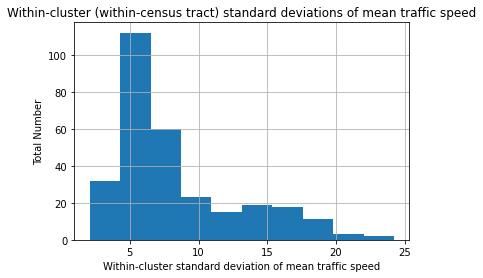

In [24]:
speed_variance_by_tract = speeds_to_tract[['speed_mph_mean', 'MOVEMENT_ID']].groupby(['MOVEMENT_ID']).std()

# plot a histogram - Question 1
speed_variance_by_tract.hist()
plt.title('Within-cluster (within-census tract) standard deviations of mean traffic speed')
plt.xlabel('Within-cluster standard deviation of mean traffic speed')
plt.ylabel('Total Number')

#Question 2
average_variance_by_tract = speed_variance_by_tract['speed_mph_mean'].mean()

#Question 3
speed_mean_by_tract = speeds_to_tract[['speed_mph_mean', 'MOVEMENT_ID']].groupby(['MOVEMENT_ID']).mean() 
variance_average_by_tract = speed_mean_by_tract['speed_mph_mean'].std()

<!-- END QUESTION -->

<!--
BEGIN QUESTION
name: q1civ3
points: 3
-->

In [25]:
speed_variance_by_tract

speed_mph_mean
MOVEMENT_ID                
9                  3.821144
20                 5.522853
21                 3.640453
44                 6.634154
78                 3.838873
...                     ...
2691               3.379664
2694               5.787065
2695               4.617596
2700              13.191079
2708               7.136608

[295 rows x 1 columns]

In [26]:
grader.check("q1civ3")

q1civ3 results: All test cases passed!

<!-- BEGIN QUESTION -->

## 1.d. What would be the ideal spatial clustering?

This is an active research problem in many spatiotemporal modeling communities, and there is no single agreed-upon answer. Answer both of the following specifically knowing that you'll need to analyze traffic patterns according to this spatial clustering:

1. **What is a good metric for a spatial structure?** How do we define good? Bad? What information do we expect a spatial structure to yield? Use the above parts and questions to help answer this.
2. **What would you do to optimize your own metric for success in a spatial structure?**

See related articles:

- Uber's H3 [link](https://eng.uber.com/h3/), which divides the world into hexagons
- Traffic Analysis Zones (TAZ) [link](https://en.wikipedia.org/wiki/Traffic_analysis_zone), which takes census data and additionally accounts for vehicles per household when dividing space

<!--
BEGIN QUESTION
name: q1d
points: 3
manual: True
-->

1. What is a good metric for a spatial structure? How do we define good? Bad? What information do we expect a spatial structure to yield?  \
We want our clusters and subpopulations to be similar and have a small difference within each subpopulation. Thus, a good metric would be the differences between subpopulations (variance_average_by_cluster) - differences within subpopulations (average_variance_by_tract). If this difference was a large positive number, this would mean the differences between subpopulations is much greater than the differences within subpopulations, which would mean our spatial clustering algorithm is good and effective at finding clusters of data points that are similar to one another. However, if the difference was a very small positive number, zero, or a negative number, this means that the clusters do not capture meaningful subpopulations and are not a good spatial clustering system.

2. What would you do to optimize your own metric for success in a spatial structure? \
To optimize my own metric for success in a spatial structure, I would use feature engineering to find the most important features that have the largest effect on average speed and leads to a small average_variance_by_cluster. For instance, dividing the world into hexagons instead of rectangles to better minimize the quantization error and capture spatial relations/dependencies (as Uber H3 does), or taking census data and additionally accounting for vehicles per household when dividing space (as Traffic Analysis Zones do) could be helpful in creating spatial clusters that are more similar to each other in regards to average speed, since some census data and vehicles per household could have a high correlation with average speed. Hence, tactics like this could help optimize our metric for success in a spatial clustering structure.

<!-- END QUESTION -->



# Step 2 - Guided EDA: Understanding COVID Lockdown Impact on Traffic

In this step, we'll examine the impact of COVID on traffic. In particular, we'll study 3 different questions:

- How did lockdown affect traffic speed? What factors dictate how much lockdown affected traffic speed?
- What areas of traffic were most impacted by lockdown?

## 2.a. How did lockdown affect traffic speed?

<!-- BEGIN QUESTION -->

### 2.a.i. Sort census tracts by average speed, pre-lockdown.

Consider the pre-lockdown period to be March 1 - 13, before the first COVID-related restrictions (travel bans) were announced on March 14, 2020.

1. **Report a DataFrame which includes the *names* of the 10 census tracts with the lowest average speed**, along with the average speed for each tract.
2. **Report a DataFrame which includes the *names* of the 10 census tracts with the highest average speed**, along with the average speed for each tract.
2. Do these names match your expectations for low speed or high speed traffic pre-lockdown?  What relationships do you notice? (What do the low-speed areas have in common? The high-speed areas?) For this specific question, answer qualitatively. No need to quantify. **Hint**: Look up some of the names on a map, to understand where they are.
3. **Plot a histogram for all average speeds, pre-lockdown**.
4. You will notice a long tail distribution of high speed traffic. What do you think this corresponds to in San Francisco? Write down your hypothesis.

Hint: To start off, think about what joins may be useful to get the desired DataFrame.

<!--
BEGIN QUESTION
name: q2ai1
points: 3
manual: True
-->

3. Do these names match your expectations for low speed or high speed traffic pre-lockdown? What relationships do you notice? (What do the low-speed areas have in common? The high-speed areas?) For this specific question, answer qualitatively. No need to quantify. Hint: Look up some of the names on a map, to understand where they are. \
These names do match our expectations for low speed and high speed traffic areas pre-lockdown. One relationship we notice is that the low-speed areas tend to be in urban, bustling cities like San Francisco, where there are a lot of traffic lights and traffic jams are more common, leading to a lower average speed. On the other hand, the higher-speed areas tend to be in less urban and more rural areas like Hillsborough Park and Moss Beach, where there are less traffic jams, leading to a higher average speed.

5. You will notice a long tail distribution of high speed traffic. What do you think this corresponds to in San Francisco? Write down your hypothesis. \
The long tail distribution of high speed traffic corresponds to the fact that there are more cars traveling at a lower average speed than higher average speed. San Francisco has a lot of traffic jams, so we hypothesize that it likely has a lower average speed and appears near the left end of the histogram.

<!-- END QUESTION -->

Answer the following question:
<!--
BEGIN QUESTION
name: q2ai2
points: 3
-->

In [27]:
# compute the average speed per census tract (will use this later),
# BEFORE the shelter-in-place was announced on March 14, 2020.
# Autograder expects this to be a series
averages_pre = speeds_to_tract.where(speeds_to_tract.day<14).groupby('MOVEMENT_ID').mean()['speed_mph_mean']
# Autograder expects this to be a dataframe with name of census tract,
# polygon for census tract, and average speed per census tract
copy_averages_pre = averages_pre[:]
copy_averages_pre.index = [int(index) for index in copy_averages_pre.index]
copy_averages_pre = copy_averages_pre.reset_index()

joined = copy_averages_pre.merge(tract_to_gps, left_on='index', right_on='MOVEMENT_ID')

averages_pre_named = joined[['MOVEMENT_ID', 'speed_mph_mean', 'DISPLAY_NAME', 'geometry']]
averages_pre_named

MOVEMENT_ID  speed_mph_mean  \
0              9       14.585102   
1             20       15.679922   
2             21       14.292445   
3             44       23.353083   
4             78       16.213552   
..           ...             ...   
290         2691       20.746333   
291         2694       17.042386   
292         2695       20.029011   
293         2700       32.184422   
294         2708       24.822808   

                                          DISPLAY_NAME  \
0           500 Hyde Street, Tenderloin, San Francisco   
1     900 Sutter Street, Lower Nob Hill, San Francisco   
2    3400 Pierce Street, Marina District, San Franc...   
3           1700 Egbert Avenue, Bayview, San Francisco   
4           1400 Thomas Avenue, Bayview, San Francisco   
..                                                 ...   
290                         800 Hacienda Way, Millbrae   
291  1900 Buchanan Street, Western Addition, San Fr...   
292  2200 Rivera Street, Sunset District, San Franc...   
293    300 Ponderosa Road, Avalon, South San Francisco   
294  200 Westview Drive, Sunshine Gardens, South Sa...   

                                              geometry  
0    MULTIPOLYGON (((-122.41827 37.78704, -122.4150...  
1    MULTIPOLYGON (((-122.42208 37.78847, -122.4153...  
2    MULTIPOLYGON (((-122.44191 37.80374, -122.4371...  
3    MULTIPOLYGON (((-122.40211 37.72779, -122.3998...  
4    MULTIPOLYGON (((-122.39270 37.72928, -122.3918...  
..                                                 ...  
290  MULTIPOLYGON (((-122.42288 37.60714, -122.4187...  
291  MULTIPOLYGON (((-122.43549 37.78870, -122.4338...  
292  MULTIPOLYGON (((-122.49505 37.74968, -122.4858...  
293  MULTIPOLYGON (((-122.44834 37.64598, -122.4460...  
294  MULTIPOLYGON (((-122.45179 37.66912, -122.4506...  

[295 rows x 4 columns]

In [28]:
grader.check("q2ai2")

q2ai2 results: All test cases passed!

Report the lowest 10 census tracts with the lowest average speed
Remember we want the NAME of each census tract too. For the autograder, please keep the name of the speed field, `speed_mph_mean`.

<!--
BEGIN QUESTION
name: q2ai3
points: 1
-->

In [29]:
bottom10_averages_pre = averages_pre_named.sort_values(by='speed_mph_mean').head(10)
bottom10_averages_pre

MOVEMENT_ID  speed_mph_mean  \
166         1691       12.417079   
249         2340       12.595120   
163         1688       12.945291   
59           651       13.195865   
51           643       13.490311   
164         1689       13.502505   
99          1244       13.549474   
100         1245       13.570625   
52           644       13.626251   
158         1674       13.944773   

                                          DISPLAY_NAME  \
166    200 O'Farrell Street, Tenderloin, San Francisco   
249          0 Mason Street, Tenderloin, San Francisco   
163        1100 Taylor Street, Nob Hill, San Francisco   
59   2900 22nd Street, Mission District, San Francisco   
51        200 Myrtle Street, Tenderloin, San Francisco   
164  200 Sutter Street, Financial District, San Fra...   
99        800 Jackson Street, Chinatown, San Francisco   
100        500 Geary Street, Tenderloin, San Francisco   
52         200 Jones Street, Tenderloin, San Francisco   
158         200 Hyde Street, Tenderloin, San Francisco   

                                              geometry  
166  MULTIPOLYGON (((-122.41462 37.78558, -122.4129...  
249  MULTIPOLYGON (((-122.41405 37.78279, -122.4107...  
163  MULTIPOLYGON (((-122.41629 37.79389, -122.4152...  
59   MULTIPOLYGON (((-122.41672 37.75717, -122.4123...  
51   MULTIPOLYGON (((-122.42146 37.78663, -122.4182...  
164  MULTIPOLYGON (((-122.40879 37.79016, -122.4071...  
99   MULTIPOLYGON (((-122.41172 37.79629, -122.4084...  
100  MULTIPOLYGON (((-122.41500 37.78745, -122.4133...  
52   MULTIPOLYGON (((-122.41443 37.78466, -122.4127...  
158  MULTIPOLYGON (((-122.41771 37.78424, -122.4160...

In [30]:
grader.check("q2ai3")

q2ai3 results: All test cases passed!

Report the highest 10 census tracts with the highest average speed.

<!--
BEGIN QUESTION
name: q2ai4
points: 1
-->

In [31]:
top10_averages_pre = averages_pre_named.sort_values(by='speed_mph_mean', ascending=False).head(10)
top10_averages_pre

MOVEMENT_ID  speed_mph_mean  \
23           285       59.498552   
36           495       53.867847   
155         1653       47.318340   
248         2339       47.225137   
199         1744       45.492292   
231         2244       44.304919   
288         2660       43.848188   
222         1955       42.784267   
191         1732       40.587037   
198         1743       38.944079   

                                          DISPLAY_NAME  \
23                       1600 Maritime Street, Oakland   
36                  4200 Shelter Creek Lane, San Bruno   
155                         Petrolite Street, Richmond   
248               Frenchmans Creek Road, Half Moon Bay   
199                         1200 Helen Drive, Millbrae   
231  0 Crystal Springs Terrace, Hillsborough Park, ...   
288                         0 Burgess Court, Sausalito   
222                        Liccicitos Road, Moss Beach   
191              0 Longview Drive, Westlake, Daly City   
198               600 San Bruno Avenue East, San Bruno   

                                              geometry  
23   MULTIPOLYGON (((-122.33037 37.82058, -122.3161...  
36   MULTIPOLYGON (((-122.43101 37.61999, -122.4300...  
155  MULTIPOLYGON (((-122.42976 37.96540, -122.4185...  
248  MULTIPOLYGON (((-122.46816 37.56079, -122.4605...  
199  MULTIPOLYGON (((-122.42820 37.60497, -122.4263...  
231  MULTIPOLYGON (((-122.37189 37.54776, -122.3710...  
288  MULTIPOLYGON (((-122.52032 37.87046, -122.5193...  
222  MULTIPOLYGON (((-122.52036 37.57534, -122.5180...  
191  MULTIPOLYGON (((-122.50053 37.70083, -122.4961...  
198  MULTIPOLYGON (((-122.41676 37.63935, -122.4115...

In [32]:
grader.check("q2ai4")

q2ai4 results: All test cases passed!

<!-- BEGIN QUESTION -->

Plot the histogram
<!--
BEGIN QUESTION
name: q2ai5
points: 1
manual: True
-->

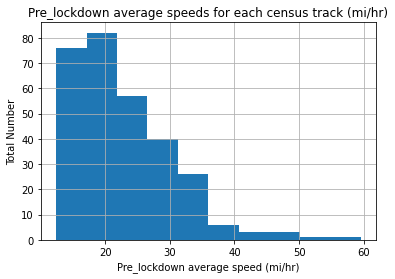

In [33]:
averages_pre_named.hist('speed_mph_mean')
plt.title('Pre_lockdown average speeds for each census track (mi/hr)')
plt.xlabel('Pre_lockdown average speed (mi/hr)')
plt.ylabel('Total Number');

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### 2.a.ii. Sort census tracts by average speed, post-lockdown.

I suggest checking the top 10 and bottom 10 tracts by average speed, post-lockdown. Consider the post-lockdown period to be March 14 - 31, after the first COVID restrictions were established on March 14, 2020. It's a healthy sanity check. For this question, you should report:

- **Plot a histogram for all average speeds, post-lockdown.**
- **What are the major differences between this post-lockdown histogram relative to the pre-lockdown histogram above**? Anything surprising? What did you expect, and what did you find?

Write the written answers in the cell below, and the coding answers in the cells after that.

<!--
BEGIN QUESTION
name: q2aii1
points: 1
manual: True
-->

Q: What are the major differences between this post-lockdown histogram relative to the pre-lockdown histogram above? Anything surprising? What did you expect, and what did you find? \
We expected the average speed to be greater post-lockdown, since the lockdown led less cars to be on the road since less people had to commute to work, resulting in less traffic jams and a higher average speed, and we found this hypothesis to be true (not surprising). Although both the post-lockdown and pre-lockdown histograms are right-skewed, the post-lockdown histogram has a higher average speed than the pre-lockdown histogram, confirming our expectations.

<!-- END QUESTION -->

<!--
BEGIN QUESTION
name: q2aii2
points: 2
-->

In [34]:
# compute the average speed per census tract (will use this later),
# AFTER (and including) the first COVID restrictions were put into effect.
# Autograder expects this to be a series
averages_post = speeds_to_tract.where(speeds_to_tract.day>=14).groupby('MOVEMENT_ID').mean()['speed_mph_mean']
# Autograder expects this to be a dataframe with name of census tract,
# polygon for census tract, and average speed per census tract
copy_averages_post = averages_post[:]
copy_averages_post.index = [int(index) for index in copy_averages_post.index]
copy_averages_post = copy_averages_post.reset_index()

joined = copy_averages_post.merge(tract_to_gps, left_on='index', right_on='MOVEMENT_ID')

averages_post_named = joined[['MOVEMENT_ID', 'speed_mph_mean', 'DISPLAY_NAME', 'geometry']]
averages_post_named

MOVEMENT_ID  speed_mph_mean  \
0              9       16.143154   
1             20       16.871488   
2             21       15.754795   
3             44       25.956602   
4             78       16.476000   
..           ...             ...   
280         2691       17.917000   
281         2694       22.128519   
282         2695       23.440404   
283         2700       38.807594   
284         2708       26.171347   

                                          DISPLAY_NAME  \
0           500 Hyde Street, Tenderloin, San Francisco   
1     900 Sutter Street, Lower Nob Hill, San Francisco   
2    3400 Pierce Street, Marina District, San Franc...   
3           1700 Egbert Avenue, Bayview, San Francisco   
4           1400 Thomas Avenue, Bayview, San Francisco   
..                                                 ...   
280                         800 Hacienda Way, Millbrae   
281  1900 Buchanan Street, Western Addition, San Fr...   
282  2200 Rivera Street, Sunset District, San Franc...   
283    300 Ponderosa Road, Avalon, South San Francisco   
284  200 Westview Drive, Sunshine Gardens, South Sa...   

                                              geometry  
0    MULTIPOLYGON (((-122.41827 37.78704, -122.4150...  
1    MULTIPOLYGON (((-122.42208 37.78847, -122.4153...  
2    MULTIPOLYGON (((-122.44191 37.80374, -122.4371...  
3    MULTIPOLYGON (((-122.40211 37.72779, -122.3998...  
4    MULTIPOLYGON (((-122.39270 37.72928, -122.3918...  
..                                                 ...  
280  MULTIPOLYGON (((-122.42288 37.60714, -122.4187...  
281  MULTIPOLYGON (((-122.43549 37.78870, -122.4338...  
282  MULTIPOLYGON (((-122.49505 37.74968, -122.4858...  
283  MULTIPOLYGON (((-122.44834 37.64598, -122.4460...  
284  MULTIPOLYGON (((-122.45179 37.66912, -122.4506...  

[285 rows x 4 columns]

In [35]:
grader.check("q2aii2")

q2aii2 results: All test cases passed!

<!-- BEGIN QUESTION -->

Plot the histogram
<!--
BEGIN QUESTION
name: q2aii3
points: 1
manual: True
-->

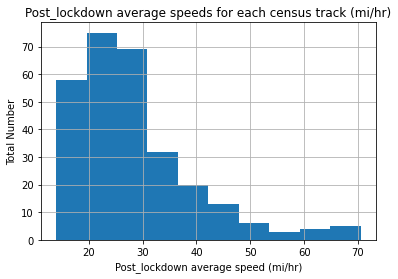

In [36]:
averages_post_named.hist('speed_mph_mean')
plt.title('Post_lockdown average speeds for each census track (mi/hr)')
plt.xlabel('Post_lockdown average speed (mi/hr)')
plt.ylabel('Total Number');

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### 2.a.iii. Sort census tracts by change in traffic speed from pre to post lockdown.

For each segment, compute the difference between the pre-lockdown average speed (March 1 - 13) and the post-lockdown average speed (March 14 - 31). **Plot a histogram of all differences.** Sanity check that the below histogram matches your observations of the histograms above, on your own.

<!--
BEGIN QUESTION
name: q2aiii
points: 2
manual: True
-->

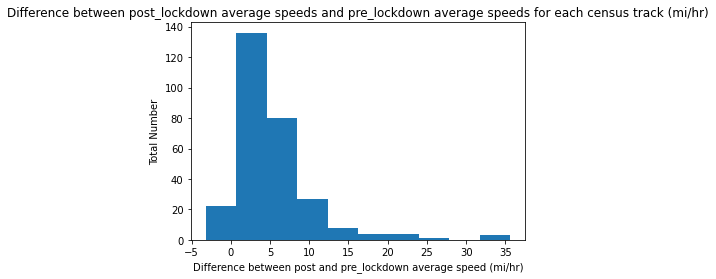

In [37]:
# The autograder expects differences to be a series object with index
# MOVEMENT_ID.
averages_post_and_pre = averages_pre_named.merge(averages_post_named, left_on='MOVEMENT_ID', right_on='MOVEMENT_ID')
differences = averages_post_and_pre['speed_mph_mean_y'] - averages_post_and_pre['speed_mph_mean_x'] 
averages_post_and_pre['pre_speed_mph_mean'] = averages_post_and_pre['speed_mph_mean_x']
averages_post_and_pre['post_speed_mph_mean'] = averages_post_and_pre['speed_mph_mean_y']
averages_post_and_pre['DISPLAY_NAME'] = averages_post_and_pre['DISPLAY_NAME_x']
averages_post_and_pre['geometry'] = averages_post_and_pre['geometry_x']
averages_post_and_pre = averages_post_and_pre.drop(['speed_mph_mean_y', 'speed_mph_mean_x', 'DISPLAY_NAME_x', 'geometry_x', 'DISPLAY_NAME_y', 'geometry_y'], axis=1)

# plot the differences
plt.hist(differences);
plt.title('Difference between post_lockdown average speeds and pre_lockdown average speeds for each census track (mi/hr)')
plt.xlabel('Difference between post and pre_lockdown average speed (mi/hr)')
plt.ylabel('Total Number');

In [38]:
grader.check("q2aiii")

q2aiii results: All test cases passed!

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### 2.a.iv. Quantify the impact of lockdown on average speeds.

1. **Plot the average speed by day, across all segments**. Be careful not to plot the average of census tract averages instead. Recall the definition of segments from Q1.
2. Is the change in speed smooth and gradually increasing? Or increasing sharply? Why? Use your real-world knowledge of announcements and measures during that time, in your explanation. You can use this list of bay area COVID-related dataes: https://abc7news.com/timeline-of-coronavirus-us-covid-19-bay-area-sf/6047519/

<!--
BEGIN QUESTION
name: q2aiv1
points: 1
manual: True
-->

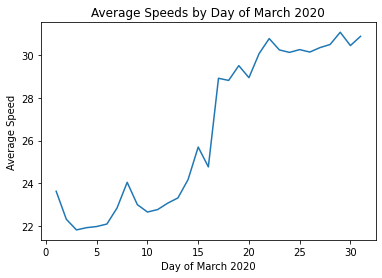

In [39]:
# Autograder expects this to be a series object containing the
# data for your line plot -- average speeds per day.
speeds_daily = speeds_to_tract.groupby('day').mean()['speed_mph_mean']
speeds_daily.plot();
plt.title('Average Speeds by Day of March 2020')
plt.xlabel('Day of March 2020')
plt.ylabel('Average Speed');

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

Write your written answer in the cell below

<!--
BEGIN QUESTION
name: q2aiv2
points: 1
manual: True
-->

2. Is the change in speed smooth and gradually increasing? Or increasing sharply? Why? Use your real-world knowledge of announcements and measures during that time, in your explanation. You can use this list of bay area COVID-related dataes: https://abc7news.com/timeline-of-coronavirus-us-covid-19-bay-area-sf/6047519/ \
The change in speed is not smooth or gradually increasing. Instead, the average speed sharply increases sharply after March 15th. This is likely because on March 15th, 2020, Governor Gavin Newsom "[ordered] all bars, nightclubs, wineries, and brewpubs to close, [told] adults age 65 and over and those with chronic health conditions to stay home, [and allowed] restaurants to stay open but to reduce capacity so customers are socially distanced." This stay-home and reducing-capacity order had a large impact, causing many to stay home instead of commute to work, leading to less cars on the road, less traffic, and thus a higher average speed.

<!-- END QUESTION -->

Ignore the empty cell below, just run the autograder to test the code above is correct.
<!--
BEGIN QUESTION
name: q2aiv3
points: 1
-->

In [40]:
grader.check("q2aiv3")

q2aiv3 results: All test cases passed!

<!-- BEGIN QUESTION -->

### 2.a.v. Quantify the impact of pre-lockdown average speed on change in speed.

1. Compute the correlation between change in speed and the *pre*-lockdown average speeds. Do we expect a positive or negative correlation, given our analysis above?
2. Compute the correlation between change in speed and the post-lockdown average speeds.
3. **How does the correlation in Q1 compare with the correlation in Q2?** You should expect a significant change in correlation value. What insight does this provide about traffic?

Written answers in the first cell, coding answerts in the following cell.

<!--
BEGIN QUESTION
name: q2av1
points: 2
manual: True
-->

1. Compute the correlation between change in speed and the pre-lockdown average speeds. Do we expect a positive or negative correlation, given our analysis above? \
We expect a positive correlation between change in speed and the pre-lockdown average speeds, since a higher pre-lockdown average speed should be associated with a higher change in speed.

3. How does the correlation in Q1 compare with the correlation in Q2? You should expect a significant change in correlation value. What insight does this provide about traffic? \
The correlation in Q1 is less than the correlation in Q2. This provides the insight about traffic speeds that the change in traffic speed has a stronger linear correlation with post-lockdown average speeds than with pre-lockdown average speeds.

<!-- END QUESTION -->


<!--
BEGIN QUESTION
name: q2av2
points: 2
-->

In [41]:
corr_pre_diff = np.corrcoef(differences, averages_post_and_pre['pre_speed_mph_mean'])[0][1]
corr_post_diff = np.corrcoef(differences, averages_post_and_pre['post_speed_mph_mean'])[0][1]
corr_pre_diff, corr_post_diff

(0.4633006380580185, 0.7926799984780658)

In [42]:
grader.check("q2av2")

q2av2 results: All test cases passed!

## 2.b. What traffic areas were impacted by lockdown?

<!-- BEGIN QUESTION -->

### 2.b.i. Visualize spatial heatmap of average traffic speed per census tract, pre-lockdown.

Visualize a spatial heatmap of the grouped average daily speeds per census tract, which you computed in previous parts. Use the geopandas [chloropleth maps](https://geopandas.org/docs/user_guide/mapping.html#choropleth-maps). **Write your observations, using your visualization, noting down at least 2 areas or patterns of interest**. These may be a local extrema, or a region that is strangely all similar.

**Hint**: Use [`to_crs`](https://geopandas.org/docs/reference/api/geopandas.GeoDataFrame.to_crs.html) and make sure the `epsg` is using the Pseudo-Mercator projection.

**Hint**: You can use `contextily` to superimpose your chloropleth map on a real geographic map.

**Hint** You can set a lower opacity for your chloropleth map, to see what's underneath, but be aware that if you plot with too low of an opacity, the map underneath will perturb your chloropleth and meddle with your conclusions.

Written answers in the first cell, coding answers in the second cell.

<!--
BEGIN QUESTION
name: q2bi1
points: 1
manual: True
-->

Q: Visualize a spatial heatmap of the grouped average daily speeds per census tract, which you computed in previous parts. Use the geopandas chloropleth maps. Write your observations, using your visualization, noting down at least 2 areas or patterns of interest. These may be a local extrema, or a region that is strangely all similar. \
One observation we found using our spatial heatmap of the grouped average daily speeds per census tract is that the census tracts with the lower average daily speeds are primarily near dense urban areas where more people live and more traffic jams occur, like San Francisco. \
On the other hand, the census tracts with the higher average daily speeds are in more suburban and more green, rural parts of the bay area, where there are less people and less traffic.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!--
BEGIN QUESTION
name: q2bi2
points: 4
manual: True
-->

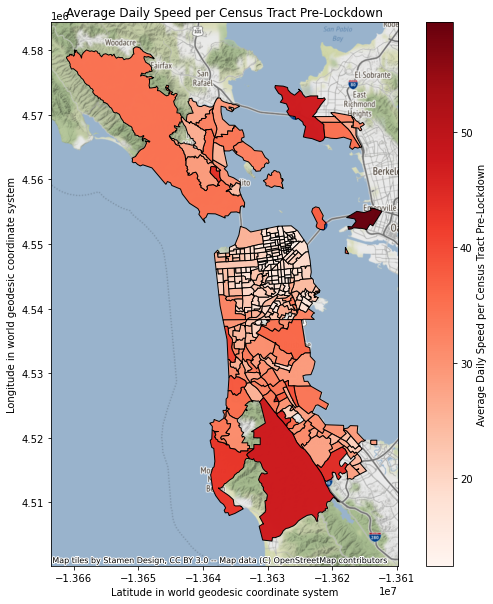

In [43]:
averages_df = gpd.GeoDataFrame(averages_post_and_pre).set_crs('EPSG:4326').to_crs(epsg='3857')
ax = averages_df.plot('pre_speed_mph_mean', 
                      legend=True, 
                      legend_kwds={'label': "Average Daily Speed per Census Tract Pre-Lockdown"}, 
                      figsize=(10, 10), 
                      alpha=0.99, 
                      edgecolor='k',
                      cmap="Reds");
cx.add_basemap(ax, crs=averages_df.crs)
plt.title("Average Daily Speed per Census Tract Pre-Lockdown")
plt.xlabel("Latitude in world geodesic coordinate system")
plt.ylabel("Longitude in world geodesic coordinate system");

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### 2.b.ii. Visualize change in average daily speeds pre vs. post lockdown.

Visualize a spatial heatmap of the census tract differences in average speeds, that we computed in a previous part. **Write your observations, using your visualization, noting down at least 2 areas or patterns of interest.** Some possible ideas for interesting notes: Which areas saw the most change in average speed? Which areas weren't affected? Why did some areas see *reduced* average speed?

First cell is for the written answers, second cell is for the coding answers.

<!--
BEGIN QUESTION
name: q2bii1
points: 1
manual: True
-->

Q: Write your observations, using your visualization, noting down at least 2 areas or patterns of interest. Some possible ideas for interesting notes: Which areas saw the most change in average speed? Which areas weren't affected? Why did some areas see reduced average speed? \
One observation we made using our visualization of the spatial heatmap of the census tract differences in average speeds is that there seems to be a low difference in average speeds in more urban areas like San Francisco. \
While more dense, urban areas like San Francisco were less affected by the lockdown, more suburban and green, rural areas saw the most change and a larger increase in average speed. \
Some areas might have seen reduced average speeds because since less people commuted to work in cities, mostly essential workers accounted for the data points in cities after lockdown, which consisted of more buses and trucks that tended to have a lower average speed than cars. Thus, this might be why the average speed near some cities post-lockdown was lower than the average speed pre-lockdown. Another potential reason why some areas see reduced average speed is because some areas might have hospitals. Since more people became sick with COVID, there might be more commutes to hospitals and around these areas, increaasing traffic. Furthermore, COVID might lead less people to take public transportation like BART/buses and more to drive, increasing traffic in some areas.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!--
BEGIN QUESTION
name: q2bii2
points: 4
manual: True
-->

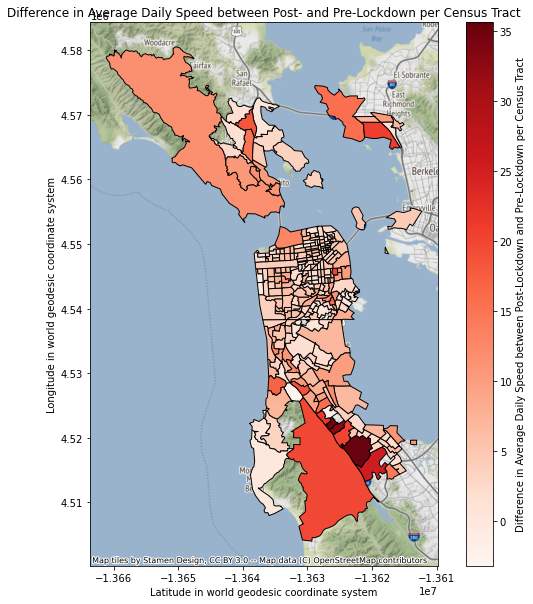

In [44]:
averages_df_w_difference = averages_df.copy()
averages_df_w_difference['difference'] = averages_df_w_difference['post_speed_mph_mean'] - averages_df_w_difference['pre_speed_mph_mean']
ax_2 = averages_df_w_difference.plot('difference', 
                                      legend=True, 
                                      legend_kwds={'label': "Difference in Average Daily Speed between Post-Lockdown and Pre-Lockdown per Census Tract"}, 
                                      figsize=(10, 10), 
                                      alpha=0.99, 
                                      edgecolor='k',
                                      cmap="Reds");
cx.add_basemap(ax_2, crs=averages_df_w_difference.crs)
plt.title("Difference in Average Daily Speed between Post- and Pre-Lockdown per Census Tract")
plt.xlabel("Latitude in world geodesic coordinate system")
plt.ylabel("Longitude in world geodesic coordinate system");

<!-- END QUESTION -->



# Step 3 - Open-Ended EDA: Understanding lockdown impact on travel times

Explore daily travel times from Hayes Valley to other destinations both before and throughout lockdown. Use the following questions as suggestions for what to explore, temporally and spatially:

- How did lockdown affect travel times? Are there any meaningful factors that determined how travel time would be impacted? How was travel time affected over time?
- Travel to which destinations were affected by lockdown? Are there surprisingly disproportionate amounts of impact in certain areas?

## 3.a. Load Datasets

In this step, we will load two datasets:

- Daily travel times from Hayes Valley to all other census tracts around San Francisco.
- Daily travel times from 300 Hayes St to Golden Gate Park in San Francisco.

For this specific set of data, we can ask several more questions; which questions you pursue are up to you, including any that you come up that are not on this list:

- Which routes from Hayes Valley had similar impact on travel time? Did they share any factors in common? Traveling through the same place -- e.g., a freway? Traveling in similar areas e.g., residential areas?
- Were clusters of routes impacted more severely than others over time? What determined the degree of impact?

In [45]:
PATH_TIMES = 'data/travel-times-daily-san-francisco-2020-3.csv'
times_to_tract = pd.read_csv(PATH_TIMES)
times_to_tract

Origin Movement ID                            Origin Display Name  \
0                    1277  300 Hayes Street, Civic Center, San Francisco   
1                    1277  300 Hayes Street, Civic Center, San Francisco   
2                    1277  300 Hayes Street, Civic Center, San Francisco   
3                    1277  300 Hayes Street, Civic Center, San Francisco   
4                    1277  300 Hayes Street, Civic Center, San Francisco   
...                   ...                                            ...   
10333                1277  300 Hayes Street, Civic Center, San Francisco   
10334                1277  300 Hayes Street, Civic Center, San Francisco   
10335                1277  300 Hayes Street, Civic Center, San Francisco   
10336                1277  300 Hayes Street, Civic Center, San Francisco   
10337                1277  300 Hayes Street, Civic Center, San Francisco   

       Destination Movement ID  \
0                            9   
1                           20   
2                           21   
3                           44   
4                           46   
...                        ...   
10333                     2624   
10334                     2643   
10335                     2673   
10336                     2694   
10337                     2695   

                                Destination Display Name  \
0             500 Hyde Street, Tenderloin, San Francisco   
1       900 Sutter Street, Lower Nob Hill, San Francisco   
2      3400 Pierce Street, Marina District, San Franc...   
3             1700 Egbert Avenue, Bayview, San Francisco   
4              500 Chester Street, West Oakland, Oakland   
...                                                  ...   
10333      1300 16th Avenue, Inner Sunset, San Francisco   
10334         1300 Egbert Avenue, Bayview, San Francisco   
10335  100 Rutledge Street, Bernal Heights, San Franc...   
10336  1900 Buchanan Street, Western Addition, San Fr...   
10337  2200 Rivera Street, Sunset District, San Franc...   

                                            Date Range  \
0        3/1/2020 - 3/1/2020, Every day, Daily Average   
1        3/1/2020 - 3/1/2020, Every day, Daily Average   
2        3/1/2020 - 3/1/2020, Every day, Daily Average   
3        3/1/2020 - 3/1/2020, Every day, Daily Average   
4        3/1/2020 - 3/1/2020, Every day, Daily Average   
...                                                ...   
10333  3/31/2020 - 3/31/2020, Every day, Daily Average   
10334  3/31/2020 - 3/31/2020, Every day, Daily Average   
10335  3/31/2020 - 3/31/2020, Every day, Daily Average   
10336  3/31/2020 - 3/31/2020, Every day, Daily Average   
10337  3/31/2020 - 3/31/2020, Every day, Daily Average   

       Mean Travel Time (Seconds)  Range - Lower Bound Travel Time (Seconds)  \
0                             322                                        211   
1                             291                                        179   
2                             635                                        438   
3                             786                                        566   
4                             891                                        682   
...                           ...                                        ...   
10333                         502                                        411   
10334                         571                                        475   
10335                         367                                        265   
10336                         222                                        167   
10337                         917                                        778   

       Range - Upper Bound Travel Time (Seconds)  day  
0                                            489    1  
1                                            470    1  
2                                            920    1  
3                                           1090    1  
4                         

# Investigating Mean Travel Times Pre and Post-Lockdown

In [46]:
#all start at 300 Hayes Street
times_to_tract.groupby('Origin Display Name').count()[['Origin Movement ID']]

Origin Movement ID
Origin Display Name                                              
300 Hayes Street, Civic Center, San Francisco               10338

In [47]:
times_to_tract.columns

Index(['Origin Movement ID', 'Origin Display Name', 'Destination Movement ID',
       'Destination Display Name', 'Date Range', 'Mean Travel Time (Seconds)',
       'Range - Lower Bound Travel Time (Seconds)',
       'Range - Upper Bound Travel Time (Seconds)', 'day'],
      dtype='object')

In [48]:
#splitting dataset into post and pre
times_to_tract_pre = times_to_tract[times_to_tract['day']<14]
times_to_tract_post = times_to_tract[times_to_tract['day']>=14]
times_to_tract_post.head()

Origin Movement ID                            Origin Display Name  \
5795                1277  300 Hayes Street, Civic Center, San Francisco   
5796                1277  300 Hayes Street, Civic Center, San Francisco   
5797                1277  300 Hayes Street, Civic Center, San Francisco   
5798                1277  300 Hayes Street, Civic Center, San Francisco   
5799                1277  300 Hayes Street, Civic Center, San Francisco   

      Destination Movement ID  \
5795                        9   
5796                       20   
5797                       21   
5798                       44   
5799                       46   

                               Destination Display Name  \
5795         500 Hyde Street, Tenderloin, San Francisco   
5796   900 Sutter Street, Lower Nob Hill, San Francisco   
5797  3400 Pierce Street, Marina District, San Franc...   
5798         1700 Egbert Avenue, Bayview, San Francisco   
5799          500 Chester Street, West Oakland, Oakland   

                                           Date Range  \
5795  3/14/2020 - 3/14/2020, Every day, Daily Average   
5796  3/14/2020 - 3/14/2020, Every day, Daily Average   
5797  3/14/2020 - 3/14/2020, Every day, Daily Average   
5798  3/14/2020 - 3/14/2020, Every day, Daily Average   
5799  3/14/2020 - 3/14/2020, Every day, Daily Average   

      Mean Travel Time (Seconds)  Range - Lower Bound Travel Time (Seconds)  \
5795                         278                                        191   
5796                         257                                        173   
5797                         539                                        427   
5798                         711                                        515   
5799                         936                                        752   

      Range - Upper Bound Travel Time (Seconds)  day  
5795                                        403   14  
5796                                        381   14  
5797                                        679   14  
5798                                        979   14  
5799                                       1164   14

In [49]:
#getting daily average travel times (seconds)
mean_travel_time_pre = times_to_tract_pre[['Mean Travel Time (Seconds)', 'Destination Movement ID']].groupby('Destination Movement ID').mean().reset_index()
mean_travel_time_post = times_to_tract_post[['Mean Travel Time (Seconds)', 'Destination Movement ID']].groupby('Destination Movement ID').mean().reset_index()
mean_travel_time_post.head()

Destination Movement ID  Mean Travel Time (Seconds)
0                        9                  253.777778
1                       20                  228.888889
2                       21                  472.200000
3                       44                  643.083333
4                       46                  876.444444

In [50]:
#joining to get location
joined_pre = mean_travel_time_pre.merge(tract_to_gps, left_on='Destination Movement ID', right_on='MOVEMENT_ID')
joined_post = mean_travel_time_post.merge(tract_to_gps, left_on='Destination Movement ID', right_on='MOVEMENT_ID')
joined_pre.head()

Destination Movement ID  Mean Travel Time (Seconds)  MOVEMENT_ID  \
0                        2                 1977.000000            2   
1                        9                  343.615385            9   
2                       20                  319.461538           20   
3                       21                  622.153846           21   
4                       30                 1338.000000           30   

                                        DISPLAY_NAME  \
0  400 Northumberland Avenue, Redwood Oaks, Redwo...   
1         500 Hyde Street, Tenderloin, San Francisco   
2   900 Sutter Street, Lower Nob Hill, San Francisco   
3  3400 Pierce Street, Marina District, San Franc...   
4                       2200 Central Avenue, Alameda   

                                            geometry  
0  MULTIPOLYGON (((-122.22463 37.46507, -122.2236...  
1  MULTIPOLYGON (((-122.41827 37.78704, -122.4150...  
2  MULTIPOLYGON (((-122.42208 37.78847, -122.4153...  
3  MULTIPOLYGON (((-122.44191 37.80374, -122.4371...  
4  MULTIPOLYGON (((-122.25114 37.77086, -122.2454...

In [51]:
#joining pre and post and computing difference
df_pre = gpd.GeoDataFrame(joined_pre).set_crs('EPSG:4326').to_crs(epsg='3857')
df_post = gpd.GeoDataFrame(joined_post).set_crs('EPSG:4326').to_crs(epsg='3857')

df_differences = df_pre.merge(df_post, left_on='MOVEMENT_ID', right_on='MOVEMENT_ID')
df_differences['geometry'] = df_differences['geometry_x']
df_differences['difference'] = df_differences['Mean Travel Time (Seconds)_y'] - df_differences['Mean Travel Time (Seconds)_x']
df_differences.head()

Destination Movement ID_x  Mean Travel Time (Seconds)_x  MOVEMENT_ID  \
0                          9                    343.615385            9   
1                         20                    319.461538           20   
2                         21                    622.153846           21   
3                         44                    864.846154           44   
4                         46                   1012.923077           46   

                                      DISPLAY_NAME_x  \
0         500 Hyde Street, Tenderloin, San Francisco   
1   900 Sutter Street, Lower Nob Hill, San Francisco   
2  3400 Pierce Street, Marina District, San Franc...   
3         1700 Egbert Avenue, Bayview, San Francisco   
4          500 Chester Street, West Oakland, Oakland   

                                          geometry_x  \
0  MULTIPOLYGON (((-13627539.592 4549384.953, -13...   
1  MULTIPOLYGON (((-13627963.273 4549587.228, -13...   
2  MULTIPOLYGON (((-13630170.516 4551738.399, -13...   
3  MULTIPOLYGON (((-13625740.001 4541042.717, -13...   
4  MULTIPOLYGON (((-13614821.896 4552251.816, -13...   

   Destination Movement ID_y  Mean Travel Time (Seconds)_y  \
0                          9                    253.777778   
1                         20                    228.888889   
2                         21                    472.200000   
3                         44                    643.083333   
4                         46                    876.444444   

                                      DISPLAY_NAME_y  \
0         500 Hyde Street, Tenderloin, San Francisco   
1   900 Sutter Street, Lower Nob Hill, San Francisco   
2  3400 Pierce Street, Marina District, San Franc...   
3         1700 Egbert Avenue, Bayview, San Francisco   
4          500 Chester Street, West Oakland, Oakland   

                                          geometry_y  \
0  MULTIPOLYGON (((-13627539.592 4549384.953, -13...   
1  MULTIPOLYGON (((-13627963.273 4549587.228, -13...   
2  MULTIPOLYGON (((-13630170.516 4551738.399, -13...   
3  MULTIPOLYGON (((-13625740.001 4541042.717, -13...   
4  MULTIPOLYGON (((-13614821.896 4552251.816, -13...   

                                            geometry  difference  
0  MULTIPOLYGON (((-13627539.592 4549384.953, -13...  -89.837607  
1  MULTIPOLYGON (((-13627963.273 4549587.228, -13...  -90.572650  
2  MULTIPOLYGON (((-13630170.516 4551738.399, -13... -149.953846  
3  MULTIPOLYGON (((-13625740.001 4541042.717, -13... -221.762821  
4  MULTIPOLYGON (((-13614821.896 4552251.816, -13... -136.478632

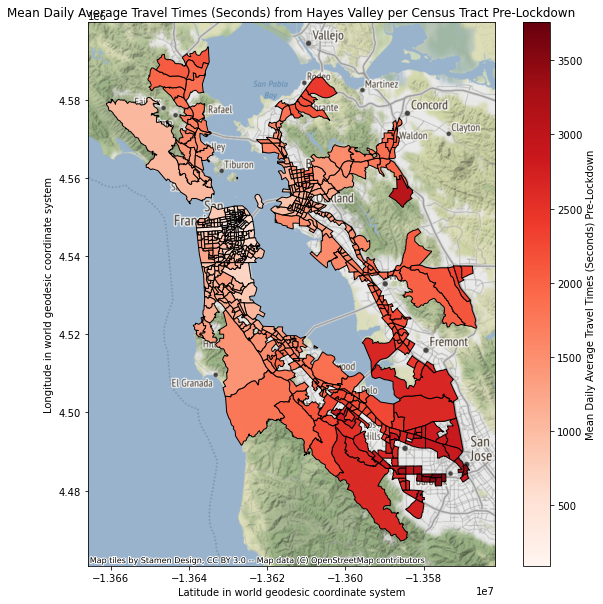

In [52]:
#converting to geopandas and plotting pre-lockdown
df_pre = gpd.GeoDataFrame(joined_pre).set_crs('EPSG:4326').to_crs(epsg='3857')
ax = df_pre.plot('Mean Travel Time (Seconds)', 
                  legend=True, 
                  legend_kwds={'label': "Mean Daily Average Travel Times (Seconds) Pre-Lockdown"}, 
                  figsize=(10, 10), 
                  alpha=0.99, 
                  edgecolor='k',
                  cmap="Reds");
cx.add_basemap(ax, crs=df_pre.crs)
plt.title('Mean Daily Average Travel Times (Seconds) from Hayes Valley per Census Tract Pre-Lockdown')
plt.xlabel("Latitude in world geodesic coordinate system")
plt.ylabel("Longitude in world geodesic coordinate system");

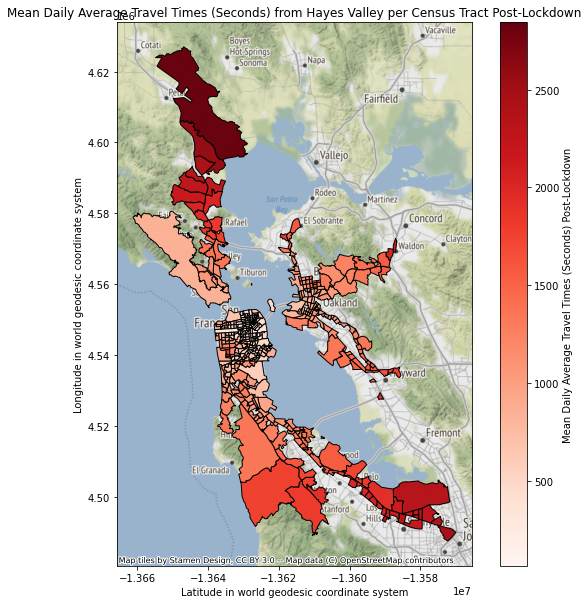

In [53]:
#converting to geopandas and plotting post-lockdown
df_post = gpd.GeoDataFrame(joined_post).set_crs('EPSG:4326').to_crs(epsg='3857')
ax = df_post.plot('Mean Travel Time (Seconds)', 
                  legend=True, 
                  legend_kwds={'label': "Mean Daily Average Travel Times (Seconds) Post-Lockdown"}, 
                  figsize=(10, 10), 
                  alpha=0.99, 
                  edgecolor='k',
                  cmap="Reds");
cx.add_basemap(ax, crs=df_post.crs)
plt.title('Mean Daily Average Travel Times (Seconds) from Hayes Valley per Census Tract Post-Lockdown')
plt.xlabel("Latitude in world geodesic coordinate system")
plt.ylabel("Longitude in world geodesic coordinate system");

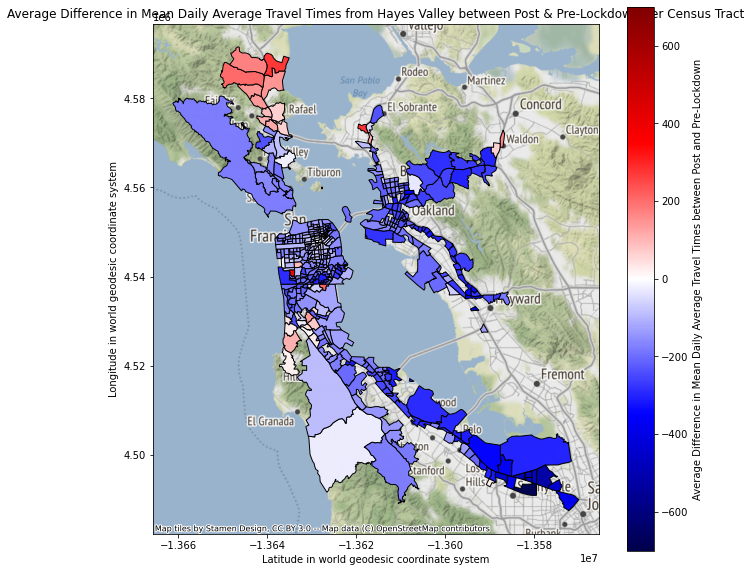

In [54]:
#converting to geopandas and plotting differences
geo_differences = gpd.GeoDataFrame(df_differences)
ax_2 = geo_differences.plot('difference', 
                            legend=True, 
                            legend_kwds={'label': "Average Difference in Mean Daily Average Travel Times between Post and Pre-Lockdown"}, 
                            figsize=(10, 10), 
                            alpha=0.99, 
                            edgecolor='k',
                            cmap="seismic",
                            vmin=-700, 
                            vmax=700);
cx.add_basemap(ax_2, crs=geo_differences.crs)
plt.title('Average Difference in Mean Daily Average Travel Times from Hayes Valley between Post & Pre-Lockdown per Census Tract')
plt.xlabel("Latitude in world geodesic coordinate system")
plt.ylabel("Longitude in world geodesic coordinate system");

# Investigating Upper Bound Travel Times Pre and Post-Lockdown

In [55]:
#getting daily upper bound travel times (seconds)
mean_travel_time_pre_upper = times_to_tract_pre[['Range - Upper Bound Travel Time (Seconds)', 'Destination Movement ID']].groupby('Destination Movement ID').max().reset_index()
mean_travel_time_post_upper = times_to_tract_post[['Range - Upper Bound Travel Time (Seconds)', 'Destination Movement ID']].groupby('Destination Movement ID').max().reset_index()
mean_travel_time_post_upper.head()

Destination Movement ID  Range - Upper Bound Travel Time (Seconds)
0                        9                                        592
1                       20                                        486
2                       21                                        712
3                       44                                       2740
4                       46                                       3140

In [56]:
#joining to get location
joined_pre_upper = mean_travel_time_pre_upper.merge(tract_to_gps, left_on='Destination Movement ID', right_on='MOVEMENT_ID')
joined_post_upper = mean_travel_time_post_upper.merge(tract_to_gps, left_on='Destination Movement ID', right_on='MOVEMENT_ID')
joined_pre_upper.head()

Destination Movement ID  Range - Upper Bound Travel Time (Seconds)  \
0                        2                                       2289   
1                        9                                        590   
2                       20                                        595   
3                       21                                       1017   
4                       30                                       1542   

   MOVEMENT_ID                                       DISPLAY_NAME  \
0            2  400 Northumberland Avenue, Redwood Oaks, Redwo...   
1            9         500 Hyde Street, Tenderloin, San Francisco   
2           20   900 Sutter Street, Lower Nob Hill, San Francisco   
3           21  3400 Pierce Street, Marina District, San Franc...   
4           30                       2200 Central Avenue, Alameda   

                                            geometry  
0  MULTIPOLYGON (((-122.22463 37.46507, -122.2236...  
1  MULTIPOLYGON (((-122.41827 37.78704, -122.4150...  
2  MULTIPOLYGON (((-122.42208 37.78847, -122.4153...  
3  MULTIPOLYGON (((-122.44191 37.80374, -122.4371...  
4  MULTIPOLYGON (((-122.25114 37.77086, -122.2454...

In [57]:
#joining pre and post and computing difference
df_pre_upper = gpd.GeoDataFrame(joined_pre_upper).set_crs('EPSG:4326').to_crs(epsg='3857')
df_post_upper = gpd.GeoDataFrame(joined_post_upper).set_crs('EPSG:4326').to_crs(epsg='3857')

df_differences_upper = df_pre_upper.merge(df_post_upper, left_on='MOVEMENT_ID', right_on='MOVEMENT_ID')
df_differences_upper['geometry'] = df_differences_upper['geometry_x']
df_differences_upper['difference'] = df_differences_upper['Range - Upper Bound Travel Time (Seconds)_y'] - df_differences_upper['Range - Upper Bound Travel Time (Seconds)_x']
df_differences_upper.head()

Destination Movement ID_x  Range - Upper Bound Travel Time (Seconds)_x  \
0                          9                                          590   
1                         20                                          595   
2                         21                                         1017   
3                         44                                         1678   
4                         46                                         1786   

   MOVEMENT_ID                                     DISPLAY_NAME_x  \
0            9         500 Hyde Street, Tenderloin, San Francisco   
1           20   900 Sutter Street, Lower Nob Hill, San Francisco   
2           21  3400 Pierce Street, Marina District, San Franc...   
3           44         1700 Egbert Avenue, Bayview, San Francisco   
4           46          500 Chester Street, West Oakland, Oakland   

                                          geometry_x  \
0  MULTIPOLYGON (((-13627539.592 4549384.953, -13...   
1  MULTIPOLYGON (((-13627963.273 4549587.228, -13...   
2  MULTIPOLYGON (((-13630170.516 4551738.399, -13...   
3  MULTIPOLYGON (((-13625740.001 4541042.717, -13...   
4  MULTIPOLYGON (((-13614821.896 4552251.816, -13...   

   Destination Movement ID_y  Range - Upper Bound Travel Time (Seconds)_y  \
0                          9                                          592   
1                         20                                          486   
2                         21                                          712   
3                         44                                         2740   
4                         46                                         3140   

                                      DISPLAY_NAME_y  \
0         500 Hyde Street, Tenderloin, San Francisco   
1   900 Sutter Street, Lower Nob Hill, San Francisco   
2  3400 Pierce Street, Marina District, San Franc...   
3         1700 Egbert Avenue, Bayview, San Francisco   
4          500 Chester Street, West Oakland, Oakland   

                                          geometry_y  \
0  MULTIPOLYGON (((-13627539.592 4549384.953, -13...   
1  MULTIPOLYGON (((-13627963.273 4549587.228, -13...   
2  MULTIPOLYGON (((-13630170.516 4551738.399, -13...   
3  MULTIPOLYGON (((-13625740.001 4541042.717, -13...   
4  MULTIPOLYGON (((-13614821.896 4552251.816, -13...   

                                            geometry  difference  
0  MULTIPOLYGON (((-13627539.592 4549384.953, -13...           2  
1  MULTIPOLYGON (((-13627963.273 4549587.228, -13...        -109  
2  MULTIPOLYGON (((-13630170.516 4551738.399, -13...        -305  
3  MULTIPOLYGON (((-13625740.001 4541042.717, -13...        1062  
4  MULTIPOLYGON (((-13614821.896 4552251.816, -13...        1354

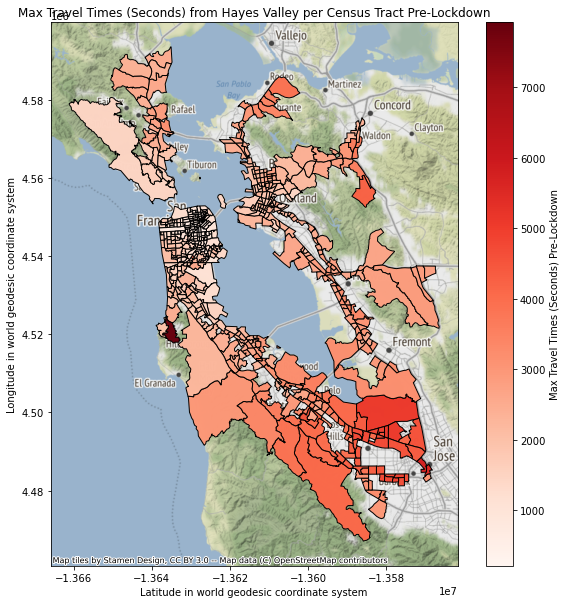

In [58]:
#converting to geopandas and plotting pre-lockdown
df_pre_upper = gpd.GeoDataFrame(joined_pre_upper).set_crs('EPSG:4326').to_crs(epsg='3857')
ax = df_pre_upper.plot('Range - Upper Bound Travel Time (Seconds)', 
                  legend=True, 
                  legend_kwds={'label': "Max Travel Times (Seconds) Pre-Lockdown"}, 
                  figsize=(10, 10), 
                  alpha=0.99, 
                  edgecolor='k',
                  cmap="Reds");
cx.add_basemap(ax, crs=df_pre_upper.crs)
plt.title('Max Travel Times (Seconds) from Hayes Valley per Census Tract Pre-Lockdown')
plt.xlabel("Latitude in world geodesic coordinate system")
plt.ylabel("Longitude in world geodesic coordinate system");

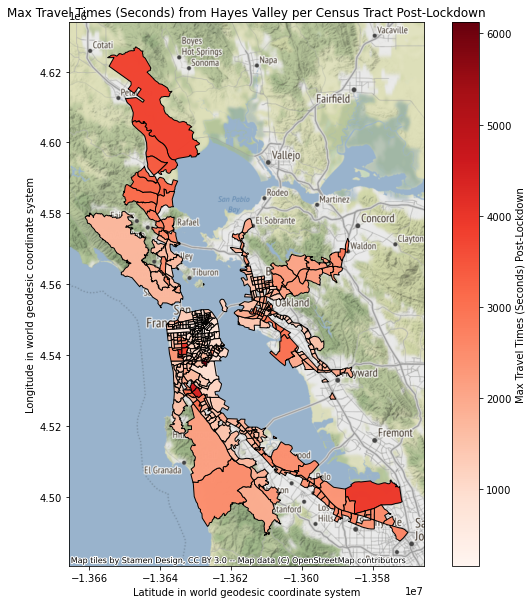

In [59]:
#converting to geopandas and plotting post-lockdown
df_post_upper = gpd.GeoDataFrame(joined_post_upper).set_crs('EPSG:4326').to_crs(epsg='3857')
ax = df_post_upper.plot('Range - Upper Bound Travel Time (Seconds)', 
                  legend=True, 
                  legend_kwds={'label': "Max Travel Times (Seconds) Post-Lockdown"}, 
                  figsize=(10, 10), 
                  alpha=0.99, 
                  edgecolor='k',
                  cmap="Reds");
cx.add_basemap(ax, crs=df_post_upper.crs)
plt.title('Max Travel Times (Seconds) from Hayes Valley per Census Tract Post-Lockdown')
plt.xlabel("Latitude in world geodesic coordinate system")
plt.ylabel("Longitude in world geodesic coordinate system");

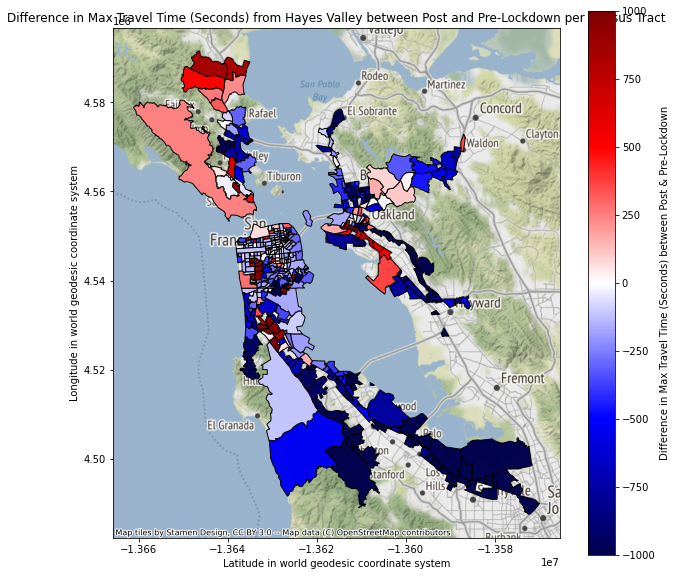

In [60]:
#converting to geopandas and plotting differences
geo_differences_upper = gpd.GeoDataFrame(df_differences_upper)
ax_2 = geo_differences_upper.plot('difference', 
                            legend=True, 
                            legend_kwds={'label': "Difference in Max Travel Time (Seconds) between Post & Pre-Lockdown"}, 
                            figsize=(10, 10), 
                            alpha=0.99, 
                            edgecolor='k',
                            cmap="seismic",
                            vmin=-1000, 
                            vmax=1000
                            );
cx.add_basemap(ax_2, crs=geo_differences_upper.crs)
plt.title('Difference in Max Travel Time (Seconds) from Hayes Valley between Post and Pre-Lockdown per Census Tract')
plt.xlabel("Latitude in world geodesic coordinate system")
plt.ylabel("Longitude in world geodesic coordinate system");

# Investigating Lower Bound Travel Times Pre and Post-Lockdown

In [61]:
#getting daily lower bound travel times (seconds)
mean_travel_time_pre_lower = times_to_tract_pre[['Range - Lower Bound Travel Time (Seconds)', 'Destination Movement ID']].groupby('Destination Movement ID').min().reset_index()
mean_travel_time_post_lower = times_to_tract_post[['Range - Lower Bound Travel Time (Seconds)', 'Destination Movement ID']].groupby('Destination Movement ID').min().reset_index()
mean_travel_time_post_lower.head()

Destination Movement ID  Range - Lower Bound Travel Time (Seconds)
0                        9                                        151
1                       20                                        111
2                       21                                        354
3                       44                                        236
4                       46                                        642

In [62]:
#joining to get location
joined_pre_lower = mean_travel_time_pre_lower.merge(tract_to_gps, left_on='Destination Movement ID', right_on='MOVEMENT_ID')
joined_post_lower = mean_travel_time_post_lower.merge(tract_to_gps, left_on='Destination Movement ID', right_on='MOVEMENT_ID')
joined_pre_lower.head()

Destination Movement ID  Range - Lower Bound Travel Time (Seconds)  \
0                        2                                       1706   
1                        9                                        194   
2                       20                                        164   
3                       21                                        434   
4                       30                                       1160   

   MOVEMENT_ID                                       DISPLAY_NAME  \
0            2  400 Northumberland Avenue, Redwood Oaks, Redwo...   
1            9         500 Hyde Street, Tenderloin, San Francisco   
2           20   900 Sutter Street, Lower Nob Hill, San Francisco   
3           21  3400 Pierce Street, Marina District, San Franc...   
4           30                       2200 Central Avenue, Alameda   

                                            geometry  
0  MULTIPOLYGON (((-122.22463 37.46507, -122.2236...  
1  MULTIPOLYGON (((-122.41827 37.78704, -122.4150...  
2  MULTIPOLYGON (((-122.42208 37.78847, -122.4153...  
3  MULTIPOLYGON (((-122.44191 37.80374, -122.4371...  
4  MULTIPOLYGON (((-122.25114 37.77086, -122.2454...

In [63]:
#joining pre and post and computing difference
df_pre_lower = gpd.GeoDataFrame(joined_pre_lower).set_crs('EPSG:4326').to_crs(epsg='3857')
df_post_lower = gpd.GeoDataFrame(joined_post_lower).set_crs('EPSG:4326').to_crs(epsg='3857')

df_differences_lower = df_pre_lower.merge(df_post_lower, left_on='MOVEMENT_ID', right_on='MOVEMENT_ID')
df_differences_lower['geometry'] = df_differences_lower['geometry_x']
df_differences_lower['difference'] = df_differences_lower['Range - Lower Bound Travel Time (Seconds)_y'] - df_differences_lower['Range - Lower Bound Travel Time (Seconds)_x']
df_differences_lower.head()

Destination Movement ID_x  Range - Lower Bound Travel Time (Seconds)_x  \
0                          9                                          194   
1                         20                                          164   
2                         21                                          434   
3                         44                                          508   
4                         46                                          682   

   MOVEMENT_ID                                     DISPLAY_NAME_x  \
0            9         500 Hyde Street, Tenderloin, San Francisco   
1           20   900 Sutter Street, Lower Nob Hill, San Francisco   
2           21  3400 Pierce Street, Marina District, San Franc...   
3           44         1700 Egbert Avenue, Bayview, San Francisco   
4           46          500 Chester Street, West Oakland, Oakland   

                                          geometry_x  \
0  MULTIPOLYGON (((-13627539.592 4549384.953, -13...   
1  MULTIPOLYGON (((-13627963.273 4549587.228, -13...   
2  MULTIPOLYGON (((-13630170.516 4551738.399, -13...   
3  MULTIPOLYGON (((-13625740.001 4541042.717, -13...   
4  MULTIPOLYGON (((-13614821.896 4552251.816, -13...   

   Destination Movement ID_y  Range - Lower Bound Travel Time (Seconds)_y  \
0                          9                                          151   
1                         20                                          111   
2                         21                                          354   
3                         44                                          236   
4                         46                                          642   

                                      DISPLAY_NAME_y  \
0         500 Hyde Street, Tenderloin, San Francisco   
1   900 Sutter Street, Lower Nob Hill, San Francisco   
2  3400 Pierce Street, Marina District, San Franc...   
3         1700 Egbert Avenue, Bayview, San Francisco   
4          500 Chester Street, West Oakland, Oakland   

                                          geometry_y  \
0  MULTIPOLYGON (((-13627539.592 4549384.953, -13...   
1  MULTIPOLYGON (((-13627963.273 4549587.228, -13...   
2  MULTIPOLYGON (((-13630170.516 4551738.399, -13...   
3  MULTIPOLYGON (((-13625740.001 4541042.717, -13...   
4  MULTIPOLYGON (((-13614821.896 4552251.816, -13...   

                                            geometry  difference  
0  MULTIPOLYGON (((-13627539.592 4549384.953, -13...         -43  
1  MULTIPOLYGON (((-13627963.273 4549587.228, -13...         -53  
2  MULTIPOLYGON (((-13630170.516 4551738.399, -13...         -80  
3  MULTIPOLYGON (((-13625740.001 4541042.717, -13...        -272  
4  MULTIPOLYGON (((-13614821.896 4552251.816, -13...         -40

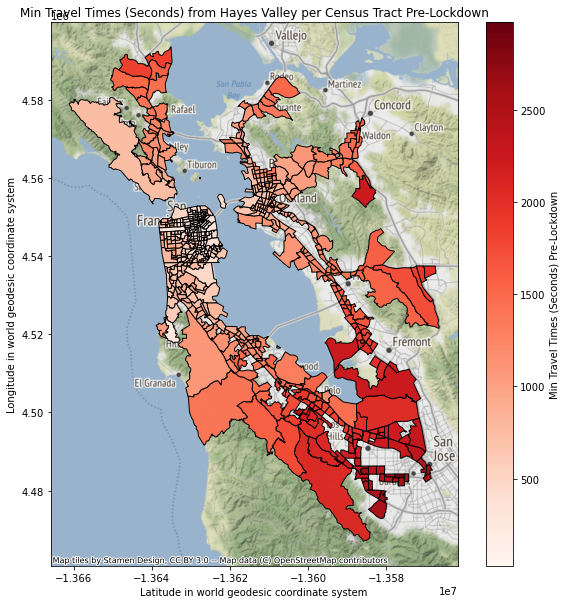

In [64]:
#converting to geopandas and plotting pre-lockdown
df_pre_lower = gpd.GeoDataFrame(joined_pre_lower).set_crs('EPSG:4326').to_crs(epsg='3857')
ax = df_pre_lower.plot('Range - Lower Bound Travel Time (Seconds)', 
                  legend=True, 
                  legend_kwds={'label': "Min Travel Times (Seconds) Pre-Lockdown"}, 
                  figsize=(10, 10), 
                  alpha=0.99, 
                  edgecolor='k',
                  cmap="Reds");
cx.add_basemap(ax, crs=df_pre_lower.crs)
plt.title('Min Travel Times (Seconds) from Hayes Valley per Census Tract Pre-Lockdown')
plt.xlabel("Latitude in world geodesic coordinate system")
plt.ylabel("Longitude in world geodesic coordinate system");

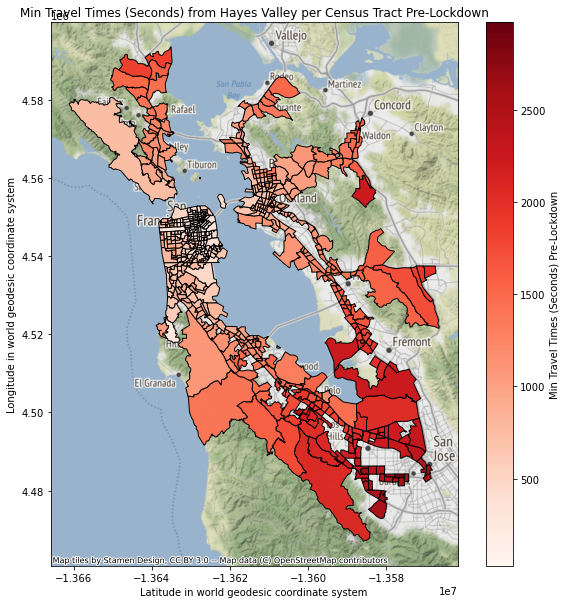

In [65]:
#converting to geopandas and plotting pre-lockdown
df_pre_lower = gpd.GeoDataFrame(joined_pre_lower).set_crs('EPSG:4326').to_crs(epsg='3857')
ax = df_pre_lower.plot('Range - Lower Bound Travel Time (Seconds)', 
                  legend=True, 
                  legend_kwds={'label': "Min Travel Times (Seconds) Pre-Lockdown"}, 
                  figsize=(10, 10), 
                  alpha=0.99, 
                  edgecolor='k',
                  cmap="Reds");
cx.add_basemap(ax, crs=df_pre_lower.crs)
plt.title('Min Travel Times (Seconds) from Hayes Valley per Census Tract Pre-Lockdown')
plt.xlabel("Latitude in world geodesic coordinate system")
plt.ylabel("Longitude in world geodesic coordinate system");

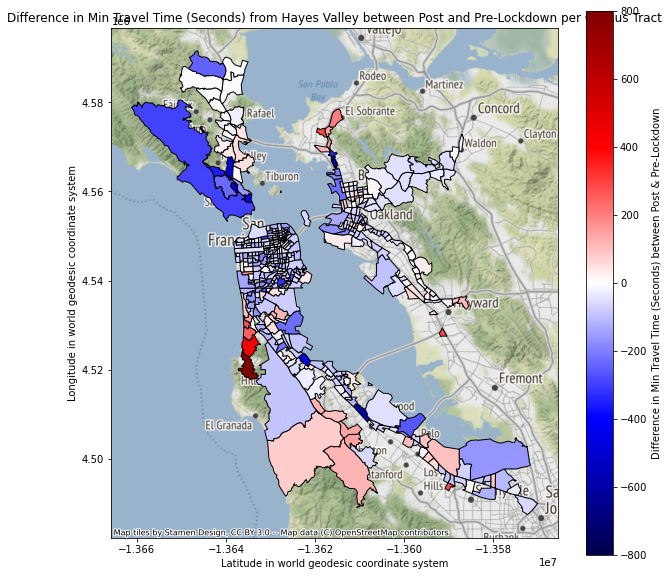

In [66]:
#converting to geopandas and plotting differences
geo_differences_lower = gpd.GeoDataFrame(df_differences_lower)
ax_2 = geo_differences_lower.plot('difference', 
                            legend=True, 
                            legend_kwds={'label': "Difference in Min Travel Time (Seconds) between Post & Pre-Lockdown"}, 
                            figsize=(10, 10), 
                            alpha=0.99, 
                            edgecolor='k',
                            cmap="seismic",
                            vmin=-800, 
                            vmax=800
                            );
cx.add_basemap(ax_2, crs=geo_differences_lower.crs)
plt.title('Difference in Min Travel Time (Seconds) from Hayes Valley between Post and Pre-Lockdown per Census Tract')
plt.xlabel("Latitude in world geodesic coordinate system")
plt.ylabel("Longitude in world geodesic coordinate system");

# Additional Feature to Predict Difference in Mean Travel Time: Investigating Weekend Days Visited Pre and Post-Lockdown

In [67]:
#splitting dataset into post and pre
times_to_tract_pre_count = times_to_tract[times_to_tract['day']<14] 
times_to_tract_post_count = times_to_tract[times_to_tract['day']>=14]
times_to_tract_post.head()

Origin Movement ID                            Origin Display Name  \
5795                1277  300 Hayes Street, Civic Center, San Francisco   
5796                1277  300 Hayes Street, Civic Center, San Francisco   
5797                1277  300 Hayes Street, Civic Center, San Francisco   
5798                1277  300 Hayes Street, Civic Center, San Francisco   
5799                1277  300 Hayes Street, Civic Center, San Francisco   

      Destination Movement ID  \
5795                        9   
5796                       20   
5797                       21   
5798                       44   
5799                       46   

                               Destination Display Name  \
5795         500 Hyde Street, Tenderloin, San Francisco   
5796   900 Sutter Street, Lower Nob Hill, San Francisco   
5797  3400 Pierce Street, Marina District, San Franc...   
5798         1700 Egbert Avenue, Bayview, San Francisco   
5799          500 Chester Street, West Oakland, Oakland   

                                           Date Range  \
5795  3/14/2020 - 3/14/2020, Every day, Daily Average   
5796  3/14/2020 - 3/14/2020, Every day, Daily Average   
5797  3/14/2020 - 3/14/2020, Every day, Daily Average   
5798  3/14/2020 - 3/14/2020, Every day, Daily Average   
5799  3/14/2020 - 3/14/2020, Every day, Daily Average   

      Mean Travel Time (Seconds)  Range - Lower Bound Travel Time (Seconds)  \
5795                         278                                        191   
5796                         257                                        173   
5797                         539                                        427   
5798                         711                                        515   
5799                         936                                        752   

      Range - Upper Bound Travel Time (Seconds)  day  
5795                                        403   14  
5796                                        381   14  
5797                                        679   14  
5798                                        979   14  
5799                                       1164   14

In [68]:
times_to_tract_pre_count_wknd = times_to_tract_pre_count[(times_to_tract_pre_count['day']%7==1) | (times_to_tract_pre_count['day']%7==0)]
times_to_tract_post_count_wknd = times_to_tract_post_count[(times_to_tract_post_count['day']%7==1) | (times_to_tract_post_count['day']%7==0)]

In [69]:
#getting number of weekend days each destination census tract is visited
mean_travel_time_pre_count_wknd = times_to_tract_pre_count_wknd[['Mean Travel Time (Seconds)', 'Destination Movement ID']].groupby('Destination Movement ID').count().reset_index()
mean_travel_time_post_count_wknd = times_to_tract_post_count_wknd[['Mean Travel Time (Seconds)', 'Destination Movement ID']].groupby('Destination Movement ID').count().reset_index()
mean_travel_time_pre_count_wknd.head()

Destination Movement ID  Mean Travel Time (Seconds)
0                        2                           1
1                        9                           3
2                       20                           3
3                       21                           3
4                       30                           1

In [70]:
#joining to get location
joined_pre_count_wknd = mean_travel_time_pre_count_wknd.merge(tract_to_gps, left_on='Destination Movement ID', right_on='MOVEMENT_ID')
joined_post_count_wknd = mean_travel_time_post_count_wknd.merge(tract_to_gps, left_on='Destination Movement ID', right_on='MOVEMENT_ID')
joined_pre_count_wknd.head()

Destination Movement ID  Mean Travel Time (Seconds)  MOVEMENT_ID  \
0                        2                           1            2   
1                        9                           3            9   
2                       20                           3           20   
3                       21                           3           21   
4                       30                           1           30   

                                        DISPLAY_NAME  \
0  400 Northumberland Avenue, Redwood Oaks, Redwo...   
1         500 Hyde Street, Tenderloin, San Francisco   
2   900 Sutter Street, Lower Nob Hill, San Francisco   
3  3400 Pierce Street, Marina District, San Franc...   
4                       2200 Central Avenue, Alameda   

                                            geometry  
0  MULTIPOLYGON (((-122.22463 37.46507, -122.2236...  
1  MULTIPOLYGON (((-122.41827 37.78704, -122.4150...  
2  MULTIPOLYGON (((-122.42208 37.78847, -122.4153...  
3  MULTIPOLYGON (((-122.44191 37.80374, -122.4371...  
4  MULTIPOLYGON (((-122.25114 37.77086, -122.2454...

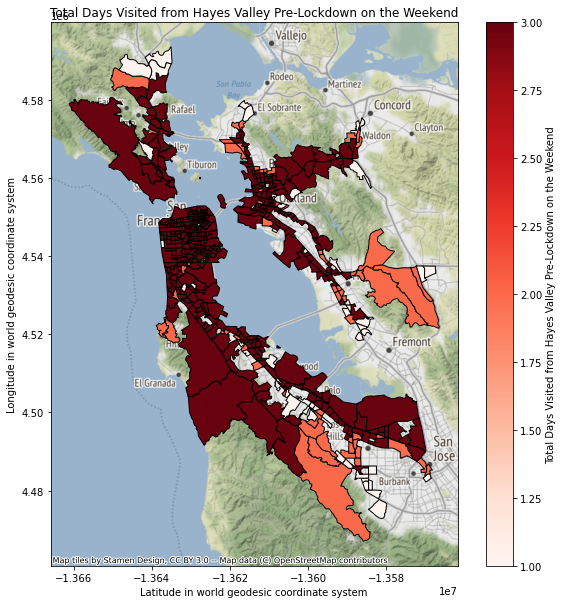

In [71]:
#converting to geopandas and plotting pre-lockdown
df_pre_count_wknd = gpd.GeoDataFrame(joined_pre_count_wknd).set_crs('EPSG:4326').to_crs(epsg='3857')
ax = df_pre_count_wknd.plot('Mean Travel Time (Seconds)', 
                  legend=True, 
                  legend_kwds={'label': "Total Days Visited \
from Hayes Valley Pre-Lockdown on the Weekend"}, 
                  figsize=(10, 10), 
                  alpha=0.99, 
                  edgecolor='k',
                  cmap="Reds",
                );
cx.add_basemap(ax, crs=df_pre_count_wknd.crs)
plt.title("Total Days Visited from Hayes Valley Pre-Lockdown on the Weekend")
plt.xlabel("Latitude in world geodesic coordinate system")
plt.ylabel("Longitude in world geodesic coordinate system");

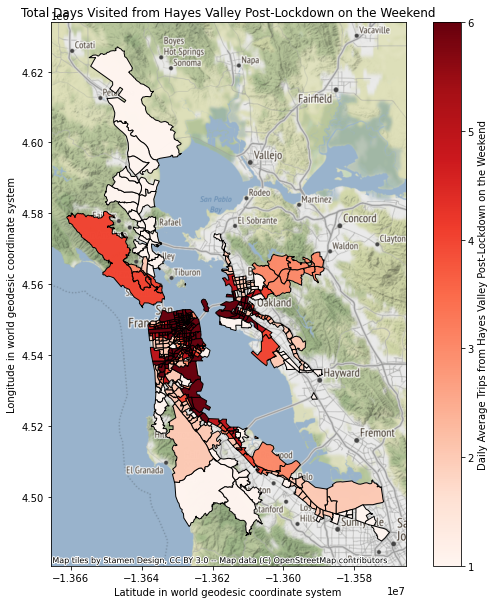

In [72]:
#converting to geopandas and plotting post-lockdown
df_post_count_wknd = gpd.GeoDataFrame(joined_post_count_wknd).set_crs('EPSG:4326').to_crs(epsg='3857')
ax = df_post_count_wknd.plot('Mean Travel Time (Seconds)', 
                  legend=True, 
                  legend_kwds={'label': "Daily Average Trips \
from Hayes Valley Post-Lockdown on the Weekend"}, 
                  figsize=(10, 10), 
                  alpha=0.99, 
                  edgecolor='k',
                  cmap="Reds");
cx.add_basemap(ax, crs=df_post_count_wknd.crs)
plt.title("Total Days Visited from Hayes Valley Post-Lockdown on the Weekend")
plt.xlabel("Latitude in world geodesic coordinate system")
plt.ylabel("Longitude in world geodesic coordinate system");

In [73]:
#merging pre and post and computing difference
df_differences_count_wknd = df_pre_count_wknd.merge(df_post_count_wknd, left_on='MOVEMENT_ID', right_on='MOVEMENT_ID')
df_differences_count_wknd['geometry'] = df_differences_count_wknd['geometry_x']
df_differences_count_wknd['difference'] = df_differences_count_wknd['Mean Travel Time (Seconds)_y'] - df_differences_count_wknd['Mean Travel Time (Seconds)_x']
df_differences_count_wknd.head()

Destination Movement ID_x  Mean Travel Time (Seconds)_x  MOVEMENT_ID  \
0                          9                             3            9   
1                         20                             3           20   
2                         21                             3           21   
3                         44                             3           44   
4                         46                             3           46   

                                      DISPLAY_NAME_x  \
0         500 Hyde Street, Tenderloin, San Francisco   
1   900 Sutter Street, Lower Nob Hill, San Francisco   
2  3400 Pierce Street, Marina District, San Franc...   
3         1700 Egbert Avenue, Bayview, San Francisco   
4          500 Chester Street, West Oakland, Oakland   

                                          geometry_x  \
0  MULTIPOLYGON (((-13627539.592 4549384.953, -13...   
1  MULTIPOLYGON (((-13627963.273 4549587.228, -13...   
2  MULTIPOLYGON (((-13630170.516 4551738.399, -13...   
3  MULTIPOLYGON (((-13625740.001 4541042.717, -13...   
4  MULTIPOLYGON (((-13614821.896 4552251.816, -13...   

   Destination Movement ID_y  Mean Travel Time (Seconds)_y  \
0                          9                             6   
1                         20                             6   
2                         21                             5   
3                         44                             5   
4                         46                             6   

                                      DISPLAY_NAME_y  \
0         500 Hyde Street, Tenderloin, San Francisco   
1   900 Sutter Street, Lower Nob Hill, San Francisco   
2  3400 Pierce Street, Marina District, San Franc...   
3         1700 Egbert Avenue, Bayview, San Francisco   
4          500 Chester Street, West Oakland, Oakland   

                                          geometry_y  \
0  MULTIPOLYGON (((-13627539.592 4549384.953, -13...   
1  MULTIPOLYGON (((-13627963.273 4549587.228, -13...   
2  MULTIPOLYGON (((-13630170.516 4551738.399, -13...   
3  MULTIPOLYGON (((-13625740.001 4541042.717, -13...   
4  MULTIPOLYGON (((-13614821.896 4552251.816, -13...   

                                            geometry  difference  
0  MULTIPOLYGON (((-13627539.592 4549384.953, -13...           3  
1  MULTIPOLYGON (((-13627963.273 4549587.228, -13...           3  
2  MULTIPOLYGON (((-13630170.516 4551738.399, -13...           2  
3  MULTIPOLYGON (((-13625740.001 4541042.717, -13...           2  
4  MULTIPOLYGON (((-13614821.896 4552251.816, -13...           3

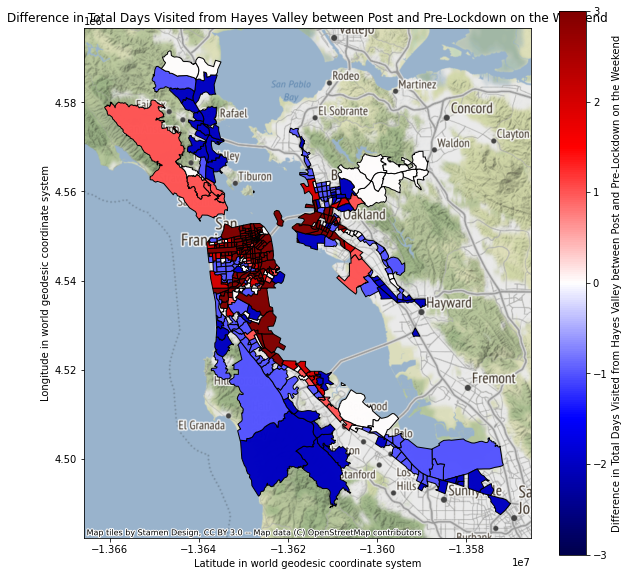

In [74]:
#converting to geopandas and plotting differences
geo_differences_count_wknd = gpd.GeoDataFrame(df_differences_count_wknd)
ax_3 = geo_differences_count_wknd.plot('difference', 
                            legend=True, 
                            legend_kwds={'label': "Difference in Total Days Visited \
from Hayes Valley between Post and Pre-Lockdown on the Weekend"}, 
                            figsize=(10, 10), 
                            alpha=0.99, 
                            edgecolor='k',
                            cmap="seismic",
                            vmin=-3, 
                            vmax=3
                            );
cx.add_basemap(ax_3, crs=geo_differences_count_wknd.crs)
plt.title("Difference in Total Days Visited from Hayes Valley between Post and Pre-Lockdown on the Weekend")
plt.xlabel("Latitude in world geodesic coordinate system")
plt.ylabel("Longitude in world geodesic coordinate system");

# Additional Feature to Predict Difference in Mean Travel Time: Investigating Week Days Visited Pre and Post-Lockdown

In [75]:
#splitting dataset into post and pre
times_to_tract_pre_count = times_to_tract[times_to_tract['day']<14] 
times_to_tract_post_count = times_to_tract[times_to_tract['day']>=14]
times_to_tract_post.head()

Origin Movement ID                            Origin Display Name  \
5795                1277  300 Hayes Street, Civic Center, San Francisco   
5796                1277  300 Hayes Street, Civic Center, San Francisco   
5797                1277  300 Hayes Street, Civic Center, San Francisco   
5798                1277  300 Hayes Street, Civic Center, San Francisco   
5799                1277  300 Hayes Street, Civic Center, San Francisco   

      Destination Movement ID  \
5795                        9   
5796                       20   
5797                       21   
5798                       44   
5799                       46   

                               Destination Display Name  \
5795         500 Hyde Street, Tenderloin, San Francisco   
5796   900 Sutter Street, Lower Nob Hill, San Francisco   
5797  3400 Pierce Street, Marina District, San Franc...   
5798         1700 Egbert Avenue, Bayview, San Francisco   
5799          500 Chester Street, West Oakland, Oakland   

                                           Date Range  \
5795  3/14/2020 - 3/14/2020, Every day, Daily Average   
5796  3/14/2020 - 3/14/2020, Every day, Daily Average   
5797  3/14/2020 - 3/14/2020, Every day, Daily Average   
5798  3/14/2020 - 3/14/2020, Every day, Daily Average   
5799  3/14/2020 - 3/14/2020, Every day, Daily Average   

      Mean Travel Time (Seconds)  Range - Lower Bound Travel Time (Seconds)  \
5795                         278                                        191   
5796                         257                                        173   
5797                         539                                        427   
5798                         711                                        515   
5799                         936                                        752   

      Range - Upper Bound Travel Time (Seconds)  day  
5795                                        403   14  
5796                                        381   14  
5797                                        679   14  
5798                                        979   14  
5799                                       1164   14

In [76]:
times_to_tract_pre_count_wkday = times_to_tract_pre_count[times_to_tract_pre_count['day']%7>1]
times_to_tract_post_count_wkday = times_to_tract_post_count[times_to_tract_post_count['day']%7>1]

In [77]:
#getting number of weekend days each destination census tract is visited
mean_travel_time_pre_count_wkday = times_to_tract_pre_count_wkday[['Mean Travel Time (Seconds)', 'Destination Movement ID']].groupby('Destination Movement ID').count().reset_index()
mean_travel_time_post_count_wkday = times_to_tract_post_count_wkday[['Mean Travel Time (Seconds)', 'Destination Movement ID']].groupby('Destination Movement ID').count().reset_index()
mean_travel_time_pre_count_wkday.head()

Destination Movement ID  Mean Travel Time (Seconds)
0                        9                          10
1                       20                          10
2                       21                          10
3                       44                          10
4                       46                          10

In [78]:
#joining to get location
joined_pre_count_wkday = mean_travel_time_pre_count_wkday.merge(tract_to_gps, left_on='Destination Movement ID', right_on='MOVEMENT_ID')
joined_post_count_wkday = mean_travel_time_post_count_wkday.merge(tract_to_gps, left_on='Destination Movement ID', right_on='MOVEMENT_ID')
joined_pre_count_wkday.head()

Destination Movement ID  Mean Travel Time (Seconds)  MOVEMENT_ID  \
0                        9                          10            9   
1                       20                          10           20   
2                       21                          10           21   
3                       44                          10           44   
4                       46                          10           46   

                                        DISPLAY_NAME  \
0         500 Hyde Street, Tenderloin, San Francisco   
1   900 Sutter Street, Lower Nob Hill, San Francisco   
2  3400 Pierce Street, Marina District, San Franc...   
3         1700 Egbert Avenue, Bayview, San Francisco   
4          500 Chester Street, West Oakland, Oakland   

                                            geometry  
0  MULTIPOLYGON (((-122.41827 37.78704, -122.4150...  
1  MULTIPOLYGON (((-122.42208 37.78847, -122.4153...  
2  MULTIPOLYGON (((-122.44191 37.80374, -122.4371...  
3  MULTIPOLYGON (((-122.40211 37.72779, -122.3998...  
4  MULTIPOLYGON (((-122.30403 37.80739, -122.3023...

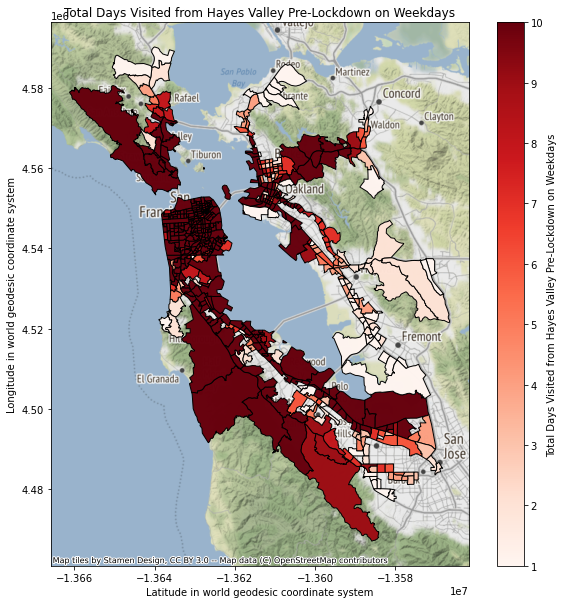

In [79]:
#converting to geopandas and plotting pre-lockdown
df_pre_count_wkday = gpd.GeoDataFrame(joined_pre_count_wkday).set_crs('EPSG:4326').to_crs(epsg='3857')
ax = df_pre_count_wkday.plot('Mean Travel Time (Seconds)', 
                  legend=True, 
                  legend_kwds={'label': "Total Days Visited \
from Hayes Valley Pre-Lockdown on Weekdays"}, 
                  figsize=(10, 10), 
                  alpha=0.99, 
                  edgecolor='k',
                  cmap="Reds",
                );
cx.add_basemap(ax, crs=df_pre_count_wkday.crs)
plt.title("Total Days Visited from Hayes Valley Pre-Lockdown on Weekdays")
plt.xlabel("Latitude in world geodesic coordinate system")
plt.ylabel("Longitude in world geodesic coordinate system");

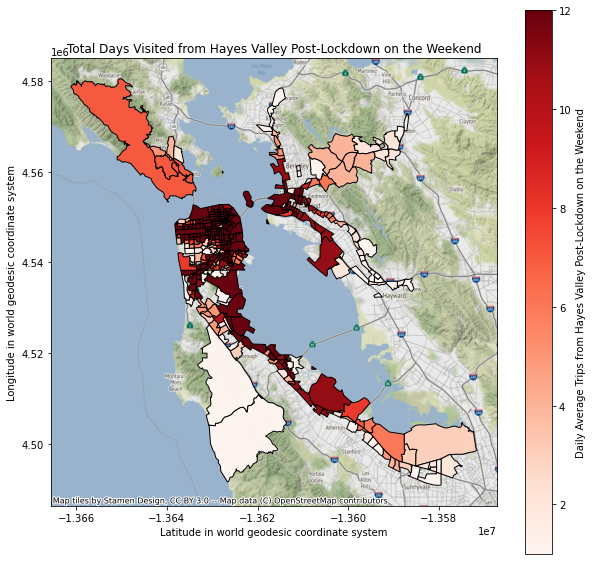

In [80]:
#converting to geopandas and plotting post-lockdown
df_post_count_wkday = gpd.GeoDataFrame(joined_post_count_wkday).set_crs('EPSG:4326').to_crs(epsg='3857')
ax = df_post_count_wkday.plot('Mean Travel Time (Seconds)', 
                  legend=True, 
                  legend_kwds={'label': "Daily Average Trips \
from Hayes Valley Post-Lockdown on the Weekend"}, 
                  figsize=(10, 10), 
                  alpha=0.99, 
                  edgecolor='k',
                  cmap="Reds");
cx.add_basemap(ax, crs=df_post_count_wkday.crs)
plt.title("Total Days Visited from Hayes Valley Post-Lockdown on the Weekend")
plt.xlabel("Latitude in world geodesic coordinate system")
plt.ylabel("Longitude in world geodesic coordinate system");

In [81]:
#merging pre and post and computing difference
df_differences_count_wkday = df_pre_count_wknd.merge(df_post_count_wkday, left_on='MOVEMENT_ID', right_on='MOVEMENT_ID')
df_differences_count_wkday['geometry'] = df_differences_count_wkday['geometry_x']
df_differences_count_wkday['difference'] = df_differences_count_wkday['Mean Travel Time (Seconds)_y'] - df_differences_count_wkday['Mean Travel Time (Seconds)_x']
df_differences_count_wkday.head()

Destination Movement ID_x  Mean Travel Time (Seconds)_x  MOVEMENT_ID  \
0                          9                             3            9   
1                         20                             3           20   
2                         21                             3           21   
3                         44                             3           44   
4                         46                             3           46   

                                      DISPLAY_NAME_x  \
0         500 Hyde Street, Tenderloin, San Francisco   
1   900 Sutter Street, Lower Nob Hill, San Francisco   
2  3400 Pierce Street, Marina District, San Franc...   
3         1700 Egbert Avenue, Bayview, San Francisco   
4          500 Chester Street, West Oakland, Oakland   

                                          geometry_x  \
0  MULTIPOLYGON (((-13627539.592 4549384.953, -13...   
1  MULTIPOLYGON (((-13627963.273 4549587.228, -13...   
2  MULTIPOLYGON (((-13630170.516 4551738.399, -13...   
3  MULTIPOLYGON (((-13625740.001 4541042.717, -13...   
4  MULTIPOLYGON (((-13614821.896 4552251.816, -13...   

   Destination Movement ID_y  Mean Travel Time (Seconds)_y  \
0                          9                            12   
1                         20                            12   
2                         21                            10   
3                         44                             7   
4                         46                            12   

                                      DISPLAY_NAME_y  \
0         500 Hyde Street, Tenderloin, San Francisco   
1   900 Sutter Street, Lower Nob Hill, San Francisco   
2  3400 Pierce Street, Marina District, San Franc...   
3         1700 Egbert Avenue, Bayview, San Francisco   
4          500 Chester Street, West Oakland, Oakland   

                                          geometry_y  \
0  MULTIPOLYGON (((-13627539.592 4549384.953, -13...   
1  MULTIPOLYGON (((-13627963.273 4549587.228, -13...   
2  MULTIPOLYGON (((-13630170.516 4551738.399, -13...   
3  MULTIPOLYGON (((-13625740.001 4541042.717, -13...   
4  MULTIPOLYGON (((-13614821.896 4552251.816, -13...   

                                            geometry  difference  
0  MULTIPOLYGON (((-13627539.592 4549384.953, -13...           9  
1  MULTIPOLYGON (((-13627963.273 4549587.228, -13...           9  
2  MULTIPOLYGON (((-13630170.516 4551738.399, -13...           7  
3  MULTIPOLYGON (((-13625740.001 4541042.717, -13...           4  
4  MULTIPOLYGON (((-13614821.896 4552251.816, -13...           9

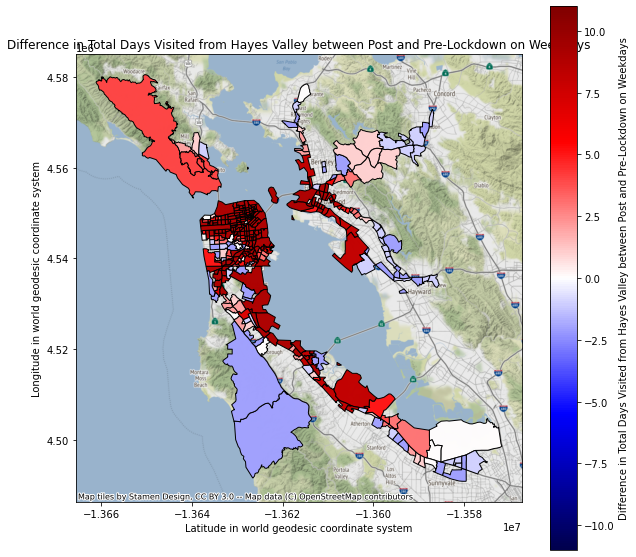

In [82]:
#converting to geopandas and plotting differences
geo_differences_count_wkday = gpd.GeoDataFrame(df_differences_count_wkday)
ax_3 = geo_differences_count_wkday.plot('difference', 
                            legend=True, 
                            legend_kwds={'label': "Difference in Total Days Visited \
from Hayes Valley between Post and Pre-Lockdown on Weekdays"}, 
                            figsize=(10, 10), 
                            alpha=0.99, 
                            edgecolor='k',
                            cmap="seismic",
                            vmin=-11, 
                            vmax=11
                            );
cx.add_basemap(ax_3, crs=geo_differences_count_wkday.crs)
plt.title("Difference in Total Days Visited from Hayes Valley between Post and Pre-Lockdown on Weekdays")
plt.xlabel("Latitude in world geodesic coordinate system")
plt.ylabel("Longitude in world geodesic coordinate system");

# Additional Feature to Predict Difference in Mean Travel Time: Investigating Total Days Visited Pre and Post-Lockdown

In [83]:
#getting number of days each destination census tract is visited
mean_travel_time_pre_count = times_to_tract_pre[['Mean Travel Time (Seconds)', 'Destination Movement ID']].groupby('Destination Movement ID').count().reset_index()
mean_travel_time_post_count = times_to_tract_post[['Mean Travel Time (Seconds)', 'Destination Movement ID']].groupby('Destination Movement ID').count().reset_index()
mean_travel_time_pre_count.head()

Destination Movement ID  Mean Travel Time (Seconds)
0                        2                           1
1                        9                          13
2                       20                          13
3                       21                          13
4                       30                           1

In [84]:
#joining to get location
joined_pre_count = mean_travel_time_pre_count.merge(tract_to_gps, left_on='Destination Movement ID', right_on='MOVEMENT_ID')
joined_post_count = mean_travel_time_post_count.merge(tract_to_gps, left_on='Destination Movement ID', right_on='MOVEMENT_ID')
joined_pre_count.head()

Destination Movement ID  Mean Travel Time (Seconds)  MOVEMENT_ID  \
0                        2                           1            2   
1                        9                          13            9   
2                       20                          13           20   
3                       21                          13           21   
4                       30                           1           30   

                                        DISPLAY_NAME  \
0  400 Northumberland Avenue, Redwood Oaks, Redwo...   
1         500 Hyde Street, Tenderloin, San Francisco   
2   900 Sutter Street, Lower Nob Hill, San Francisco   
3  3400 Pierce Street, Marina District, San Franc...   
4                       2200 Central Avenue, Alameda   

                                            geometry  
0  MULTIPOLYGON (((-122.22463 37.46507, -122.2236...  
1  MULTIPOLYGON (((-122.41827 37.78704, -122.4150...  
2  MULTIPOLYGON (((-122.42208 37.78847, -122.4153...  
3  MULTIPOLYGON (((-122.44191 37.80374, -122.4371...  
4  MULTIPOLYGON (((-122.25114 37.77086, -122.2454...

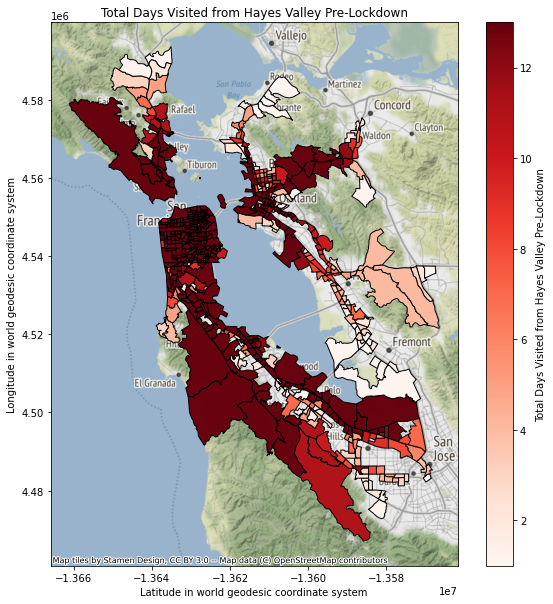

In [85]:
#converting to geopandas and plotting pre-lockdown
df_pre_count = gpd.GeoDataFrame(joined_pre_count).set_crs('EPSG:4326').to_crs(epsg='3857')
ax = df_pre_count.plot('Mean Travel Time (Seconds)', 
                  legend=True, 
                  legend_kwds={'label': "Total Days Visited \
from Hayes Valley Pre-Lockdown"}, 
                  figsize=(10, 10), 
                  alpha=0.99, 
                  edgecolor='k',
                  cmap="Reds");
cx.add_basemap(ax, crs=df_pre_count.crs)
plt.title("Total Days Visited from Hayes Valley Pre-Lockdown")
plt.xlabel("Latitude in world geodesic coordinate system")
plt.ylabel("Longitude in world geodesic coordinate system");

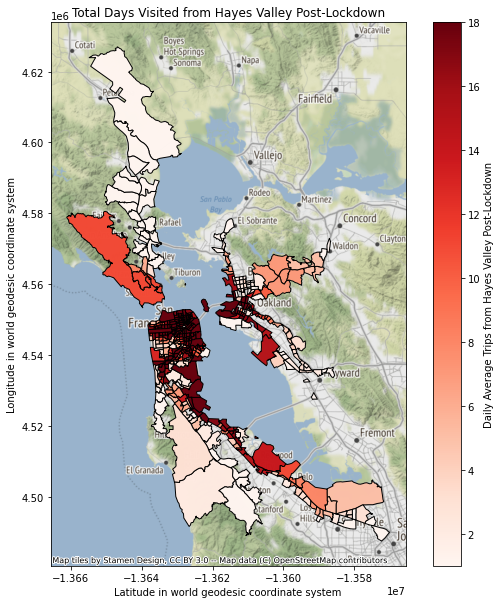

In [86]:
#converting to geopandas and plotting post-lockdown
df_post_count = gpd.GeoDataFrame(joined_post_count).set_crs('EPSG:4326').to_crs(epsg='3857')
ax = df_post_count.plot('Mean Travel Time (Seconds)', 
                  legend=True, 
                  legend_kwds={'label': "Daily Average Trips \
from Hayes Valley Post-Lockdown"}, 
                  figsize=(10, 10), 
                  alpha=0.99, 
                  edgecolor='k',
                  cmap="Reds");
cx.add_basemap(ax, crs=df_post_count.crs)
plt.title("Total Days Visited from Hayes Valley Post-Lockdown")
plt.xlabel("Latitude in world geodesic coordinate system")
plt.ylabel("Longitude in world geodesic coordinate system");

In [87]:
#merging pre and post and computing difference
df_differences_count = df_pre_count.merge(df_post_count, left_on='MOVEMENT_ID', right_on='MOVEMENT_ID')
df_differences_count['geometry'] = df_differences_count['geometry_x']
df_differences_count['difference'] = df_differences_count['Mean Travel Time (Seconds)_y'] - df_differences_count['Mean Travel Time (Seconds)_x']
df_differences_count.head()

Destination Movement ID_x  Mean Travel Time (Seconds)_x  MOVEMENT_ID  \
0                          9                            13            9   
1                         20                            13           20   
2                         21                            13           21   
3                         44                            13           44   
4                         46                            13           46   

                                      DISPLAY_NAME_x  \
0         500 Hyde Street, Tenderloin, San Francisco   
1   900 Sutter Street, Lower Nob Hill, San Francisco   
2  3400 Pierce Street, Marina District, San Franc...   
3         1700 Egbert Avenue, Bayview, San Francisco   
4          500 Chester Street, West Oakland, Oakland   

                                          geometry_x  \
0  MULTIPOLYGON (((-13627539.592 4549384.953, -13...   
1  MULTIPOLYGON (((-13627963.273 4549587.228, -13...   
2  MULTIPOLYGON (((-13630170.516 4551738.399, -13...   
3  MULTIPOLYGON (((-13625740.001 4541042.717, -13...   
4  MULTIPOLYGON (((-13614821.896 4552251.816, -13...   

   Destination Movement ID_y  Mean Travel Time (Seconds)_y  \
0                          9                            18   
1                         20                            18   
2                         21                            15   
3                         44                            12   
4                         46                            18   

                                      DISPLAY_NAME_y  \
0         500 Hyde Street, Tenderloin, San Francisco   
1   900 Sutter Street, Lower Nob Hill, San Francisco   
2  3400 Pierce Street, Marina District, San Franc...   
3         1700 Egbert Avenue, Bayview, San Francisco   
4          500 Chester Street, West Oakland, Oakland   

                                          geometry_y  \
0  MULTIPOLYGON (((-13627539.592 4549384.953, -13...   
1  MULTIPOLYGON (((-13627963.273 4549587.228, -13...   
2  MULTIPOLYGON (((-13630170.516 4551738.399, -13...   
3  MULTIPOLYGON (((-13625740.001 4541042.717, -13...   
4  MULTIPOLYGON (((-13614821.896 4552251.816, -13...   

                                            geometry  difference  
0  MULTIPOLYGON (((-13627539.592 4549384.953, -13...           5  
1  MULTIPOLYGON (((-13627963.273 4549587.228, -13...           5  
2  MULTIPOLYGON (((-13630170.516 4551738.399, -13...           2  
3  MULTIPOLYGON (((-13625740.001 4541042.717, -13...          -1  
4  MULTIPOLYGON (((-13614821.896 4552251.816, -13...           5

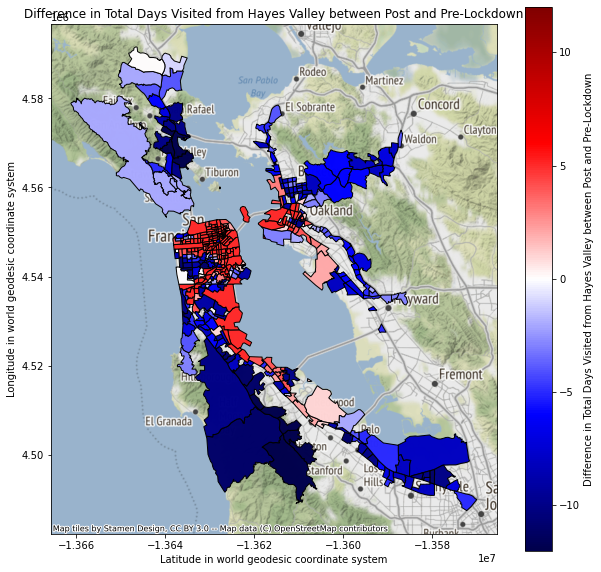

In [88]:
#converting to geopandas and plotting differences
geo_differences_count = gpd.GeoDataFrame(df_differences_count)
ax_3 = geo_differences_count.plot('difference', 
                            legend=True, 
                            legend_kwds={'label': "Difference in Total Days Visited \
from Hayes Valley between Post and Pre-Lockdown"}, 
                            figsize=(10, 10), 
                            alpha=0.99, 
                            edgecolor='k',
                            cmap="seismic",
                            vmin=-12, 
                            vmax=12
                            );
cx.add_basemap(ax_3, crs=geo_differences_count.crs)
plt.title("Difference in Total Days Visited from Hayes Valley between Post and Pre-Lockdown")
plt.xlabel("Latitude in world geodesic coordinate system")
plt.ylabel("Longitude in world geodesic coordinate system");

# Additional Feature to Predict Difference in Mean Travel Time: Investigating Elevation

In [89]:
#importing elevation dataset from outside source: https://catalog.data.gov/dataset/elevation-contours/resource/e2362085-3a2e-4bac-88ee-b33ab4f8403f
#elevation = pd.read_csv("data/phys_contours_wgs.csv", engine="python", encoding='utf-8', error_bad_lines=False)
#elevation['geometry'] = gpd.GeoSeries.from_wkt(elevation['the_geom'])
#elevation = gpd.GeoDataFrame(elevation, geometry='geometry').set_crs(epsg=4326)
#elevation.head()

In [90]:
#e = gpd.GeoDataFrame(elevation)
#ax_4 = e.plot('ELEVATION', 
#                legend=True, 
#                legend_kwds={'label': "Elevation (in Feet)"}, 
#                figsize=(10, 10), 
#                alpha=0.99, 
#                cmap="seismic");
#cx.add_basemap(ax_4, crs=elevation.crs)
#plt.title('Elevation of San Francisco Bay Area (in Feet)')
#plt.xlabel("Latitude (in Degrees)")
#plt.ylabel("Longitude (in Degrees)");

# Step 4 - Guided Modeling: Predict traffic speed post-lockdown

In this step, you'll train a model to predict traffic speed. In particular, you'll learn how to provide implicit supervision and correction to your model, when you know there's been a distribution shift in its data, leading to a large gap between train and test sets. You'll follow the following outline:

- Build a model to predict daily traffic speed in San Francisco. Train and evaluate on *pre*-lockdown traffic speeds around the city.
- Evaluate your model on post-lockdown traffic speeds. Where is your model most mistaken, and why?
- Using this knowledge, how would you correct your model for a more accurate post-lockdown traffic predictor?


The technical term for a phenomenon like the lockdown, which caused major distributional shifts in the data, is *change point*. A large body of work studies "change point detection," but you'll be harder pressed to find a "handling change point" paper. 

## 4.a. Predict daily traffic speed on pre-lockdown data

For your model, you will predict daily traffic speed per census tract, given the previous $k=5$ daily traffic speeds for that census tract. In particular, say a matrix $A$ is $n \times d$, where $n$ is the number of census tracts and $d$ is the number of days. We define the following inputs and labels:

$$X_{(i,t)} = [A_{(i,t-5)}, A_{(i,t-4)}, A_{(i,t-3)}, A_{(i,t-2)}, A_{(i,t-1)}]$$
$$y_{(i,t)} = [A_{(i,t)}]$$

This just means that each sample $X_i$ includes speed averages from the previous 5 days for the $i$th census track.

### 4.a.i. Assemble dataset to predict daily traffic speed.

Below, we've included skeletons for the helper functions we defined, to complete the problem. We highly recommend following this skeleton code, else we cannot guarantee staff support for debugging your work.


**Hint**: What's wrong with collecting all samples, then randomly selecting some percentage to hold out? See the answer in the expandable below.

<details>
    <summary>[Click to expand] How to do train-validation split correctly, on time series</summary>
    
For a *time series* in particular, this random split would be cheating, because data within each day is highly correlated. Instead, you should hold out entire days from the dataset. In this case, you should hold out the last 2 days for your validation set.
</details>

<!--
BEGIN QUESTION
name: q4ai1
points: 1
-->

In [91]:
def dataframe_to_time_series(df: pd.DataFrame):
    """Convert your dataframe into a 'time series'.
    
    :param df: the original dataframe, mapping speeds to census tracts.
        This dataframe should contain the `MOVEMENT_ID` (census tract id),
        `day`, and average speed for that day `speed_mph_mean`
    :return: a new dataframe that is formatted as n x d, where
        n is the number of samples (census tracts) and d is the number of
        dimensions (days). The values are the speeds.
    """
    return pd.pivot_table(df, values='speed_mph_mean', index='MOVEMENT_ID', columns='day', aggfunc='mean')
time_series = dataframe_to_time_series(speeds_to_tract)
time_series_pre = time_series.iloc[:, list(range(13))]
time_series_pre

day                 1          2          3          4          5          6   \
MOVEMENT_ID                                                                     
9            16.196918  14.395121  13.868696  14.225414  14.312199  13.811991   
20           17.418045  15.460956  15.463297  15.419764  15.291956  15.227310   
21           15.141171  13.176998  13.781490  14.052113  14.078134  13.636357   
44           25.079544  23.492586  22.727711  22.274143  21.874703  23.082414   
78           16.174464  16.755496  16.039120  16.118401  15.665069  15.797723   
...                ...        ...        ...        ...        ...        ...   
2691               NaN        NaN        NaN        NaN  18.600000  17.787000   
2694         17.809761  16.725889  16.530783  16.446517  16.503053  16.652473   
2695         20.106061  20.228850  19.849135  20.145877  22.357605  19.250479   
2700         34.586890  31.372308  30.866382  31.000998  31.636377  30.213992   
2708         25.176235  24.725863  24.130040  24.287102  24.364056  25.090063   

day                 7          8          9          10         11         12  \
MOVEMENT_ID                                                                     
9            15.508637  16.210738  14.845320  14.711534  13.739901  14.391436   
20           17.088325  18.088862  16.178105  15.295494  14.637109  14.282602   
21           13.958269  14.642295  15.616215  14.850471  13.790100  14.573349   
44           22.875819  25.653848  23.501387  22.739869  23.756560  24.989269   
78           15.302616  19.284080  16.253357  16.131290  15.773117  16.091415   
...                ...        ...        ...        ...        ...        ...   
2691         23.473000        NaN  19.038000        NaN        NaN  22.107000   
2694         17.427329  18.057287  17.310272  16.998730  16.891788  17.008323   
2695         19.223717  19.471282  20.497077  20.401085  23.870537  20.215396   
2700         33.581884  35.443617  32.179867  32.951855  31.574525  32.172958   
2708         25.552157  26.296112  25.512403  24.886063  23.902599  25.262721   

day                 13  
MOVEMENT_ID             
9            13.955833  
20           14.437358  
21           15.177251  
44           23.176275  
78           16.208158  
...                ...  
2691               NaN  
2694         17.559142  
2695         20.343131  
2700         31.334364  
2708         24.450025  

[295 rows x 13 columns]

In [92]:
grader.check("q4ai1")

q4ai1 results: All test cases passed!

In [93]:
def time_series_to_numpy(df: pd.DataFrame, T: int, n_val: int):
    """Convert your 'time series' into train-validate splits, in numpy
    
    You can assume your dataframe contains a `day` column where days
    start from 1 and are consecutive.
    
    :param df: the dataframe formatted as n x d, where
        n is the number of samples (census tracts) and d is the number of
        dimensions (days). The values are the speeds.
    :param T: number of days to include in each training sample
    :param n_val: number of days to hold out for the validation set.
        Say we have 5 total days in our dataset, T=2, n_val=2. This means
        during training, we have samples that pull averages from days 1 and
        2 to predict day 3: x=(1, 2), y=(3,) For validation, we have samples
        like x=(2, 3), y=(4,) and x=(3, 4), y=(5,). This way, the model sees
        data from days 4 and 5 only during validation.
    :return: Set of 4 numpy arrays - X_train, y_train, X_val, y_val - where
        X_* arrays are (n, T) and y_* arrays are (n,).
    """

    x_train = pd.DataFrame(columns=df.columns[:T])
    y_train = [] 
    x_val = pd.DataFrame(columns=df.columns[:T]) 
    y_val = []
    num_cols = len(df.columns)
    for i in range(num_cols - n_val - T):
        start = i
        end = i+T
        x_train_temp = df.iloc[:, start:end]
        y_train_temp = df.iloc[:, end:end+1]
        x_train_temp.columns = x_train.columns
        x_train = x_train.append(x_train_temp)
        y_train = np.append(y_train, y_train_temp)
    for i in range(num_cols - n_val - T, num_cols-T):
        start = i
        end = i+T
        x_val_temp = df.iloc[:, start:end]
        y_val_temp = df.iloc[:, end:end+1]
        x_val_temp.columns = x_val.columns
        x_val = x_val.append(x_val_temp)
        y_val = np.append(y_val, y_val_temp)
    x_train = x_train.to_numpy()
    x_val = x_val.to_numpy()
    return x_train, y_train, x_val, y_val

def remove_nans(X: np.array, y: np.array):
    """Remove all nans from the provided (X, y) pair.
    
    Note: A nan in X means that sample must be removed from *both X and y.
        Likewise, a nan in y means that sample must be removed from *both
        X and y.
    
    :param X: (n, T) array of model inputs
    :param y: (n,) array of labels
    :return: (X, y)
    """

    del_ind = [i for i in range(len(X)) if (np.any(np.isnan(X[i])) or np.isnan(y[i]))]
    if not len(X):
        return X, y
    X = np.delete(X, del_ind, axis=0)
    y = np.delete(y, del_ind, axis=0)
    return X, y
        
        
answer = time_series_to_numpy(time_series, 10, 2)
answer2 = remove_nans(answer[0], answer[1])

In [94]:
grader.check("q4ai2")

q4ai2 results: All test cases passed!

In [95]:
def time_series_to_dataset(time_series: pd.DataFrame, T: int, n_val: int):
    """Convert 'time series' dataframe to a numpy dataset.
    
    Uses utilites above `time_series_to_numpy` and `remove_nans`
    
    For description of arguments, see `time_series_to_numpy` docstring.
    """
    x_train, y_train, x_val, y_val = time_series_to_numpy(time_series, T, n_val)
    x_train, y_train = remove_nans(x_train, y_train)
    x_val, y_val = remove_nans(x_val, y_val)
    return x_train, y_train, x_val, y_val
X_train, y_train, X_val, y_val = time_series_to_dataset(time_series_pre, 5, 2)

In [96]:
grader.check("q4ai3")

q4ai3 results: All test cases passed!

In [97]:
(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

((1705, 5), (1705,), (562, 5), (562,))

<!-- BEGIN QUESTION -->

### 4.a.ii. Train and evaluate linear model on pre-lockdown data.

1. **Train a linear model that forecasts the next day's speed average** using your training dataset `X_train`, `y_train`. Specifically, predict $y_{(i,t)}$ from $X_{(i,t)}$, where
- $y_{(i,t)}$ is the daily speed average for day $t$ and census tract $i$
- $X_{(i,t)}$ is a vector of daily speed averages for days $t-5,t-4,t-3,t-2,t-1$ for census tract $i$
2. **Evaluate your model** on your validation dataset `X_val`, `y_val`.
3. **Make a scatter plot**, plotting predicted averages against ground truth averages. Note the perfect model would line up all points along the line $y=x$.

Our model is quantitatively and qualitatively pretty accurate at this point, training and evaluating on pre-lockdown data.

<!--
BEGIN QUESTION
name: q4aii1
points: 1
manual: True
-->

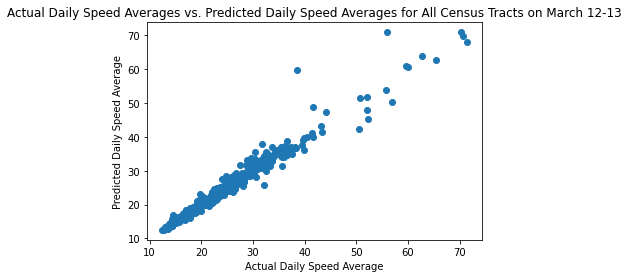

In [98]:
from sklearn.metrics import r2_score
model = LinearRegression()
reg = model.fit(X_train, y_train) # set to trained linear model
pred_val = reg.predict(X_val)

score = r2_score(y_val, pred_val) # report r^2 score
# create the scatter plot below
plt.scatter(x=y_val, y=pred_val)
plt.title('Actual Daily Speed Averages vs. Predicted Daily Speed Averages for All Census Tracts on March 12-13')
plt.xlabel('Actual Daily Speed Average')
plt.ylabel('Predicted Daily Speed Average');

<!-- END QUESTION -->

<!--
BEGIN QUESTION
name: q4aii2
points: 1
-->

In [99]:
score

0.9639232922122069

In [100]:
grader.check("q4aii2")

q4aii2 results: All test cases passed!

## 4.b. Understand failures on post-lockdown data

Your dataset is distributed spatially and temporally. As a result, the most intuitive spaces to visualize your model error or performance along is both spatially and temporally. In this step, we focus on understanding *where* your model fails.

### 4.b.i. Evaluate on post-lockdown data

1. Using your previously trained linear regression model `reg`, **evaluate on post-lockdown data**, meaning daily speed averages on March 14, 2020. Evaluate on all census tracts.
2. **Make a scatter plot**, plotting predicted averages against ground truth averages. Note the perfect model would line up all points along the line $y=x$.

<!--
BEGIN QUESTION
name: q4bi1
points: 1
-->

In [101]:
df_14 = time_series.loc[:, 9:14]
time_series_x, time_series_y, time_series_x_val, time_series_y_val = time_series_to_dataset(df_14, 5, 0)
y_pred = reg.predict(time_series_x)
score_pre_14th = r2_score(time_series_y, y_pred)
score_pre_14th

0.9337122097376677

In [102]:
grader.check("q4bi1")

q4bi1 results: All test cases passed!

<!-- BEGIN QUESTION -->

Make scatter plot below.
<!--
BEGIN QUESTION
name: q4bi2
points: 1
manual: True
-->

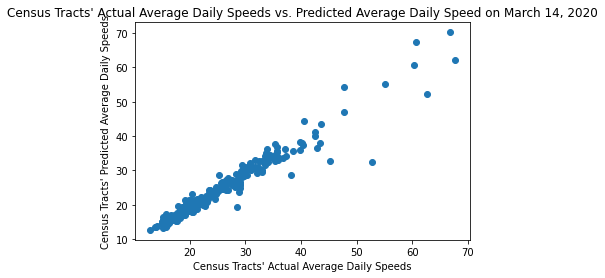

In [103]:
# create the scatter plot below
plt.scatter(x=time_series_y, y=y_pred)
plt.title("Census Tracts' Actual Average Daily Speeds vs. Predicted Average Daily Speed on March 14, 2020")
plt.xlabel("Census Tracts' Actual Average Daily Speeds")
plt.ylabel("Census Tracts' Predicted Average Daily Speeds");

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### 4.b.ii. Report model performance temporally

1. **Make a line plot** showing performance of the original model throughout all of March 2020.
2. **Report the lowest point on the line plot**, reflecting the lowest model performance.
2. **Why is model performance the worst on the 17th?** Why does it begin to worsen on march 15th? And continue to worsen? Use what you know about covid measures on those dates. You may find this webpage useful: https://abc7news.com/timeline-of-coronavirus-us-covid-19-bay-area-sf/6047519/
3. **Is the dip in performance on the 9th foreshadowed** by any of our EDA?
4. **How does the model miraculously recover on its own?**
5. **Make a scatter plot**, plotting predicted averages against ground truth averages *for model predictions on March 17th*. Note the perfect model would line up all points along the line $y=x$. When compared against previous plots of this nature, this plot looks substantially worse, with points straying far from $y=x$.

**Note:** Answer questions 2-5 in the Markdown cell below. Q1 and Q6 are answered in the two code cells below.

<!--
BEGIN QUESTION
name: q4bii1
points: 3
manual: True
-->



2. Report the lowest point on the line plot, reflecting the lowest model performance. \
The lowest point on the line plot, reflecting the lowest model performance, occurs on March 17th, 2020.

3. Why is model performance the worst on the 17th? Why does it begin to worsen on march 15th? And continue to worsen? Use what you know about covid measures on those dates. \
The model begins to worsen on March 15th, 2020 because on March 15th, 2020, Governor Gavin Newsom "[ordered] all bars, nightclubs, wineries, and brewpubs to close, [told] adults age 65 and over and those with chronic health conditions to stay home, [and allowed] restaurants to stay open but to reduce capacity so customers are socially distanced." This stay-home and reducing-capacity order had a large impact, causing many to stay home instead of commute to work, leading to less cars on the road, less traffic, and thus a higher average speed. Since the model was trained on pre-lockdown data (before March 15th), it captured people's tendencies and traffic when people were still commuting to work. Hence, it is unable to model post-lockdown data well, and it begins to worsen as more and more people didn't commute and had to stay home and work from home. \
The model performance is the worst on the 17th because the most impactful measure, a shelter in place order, was enacted in California, causing millions of Californians to stay home and not travel as much, drastically reducing traffic. On March 17th, 2020, as per the website above, the shelter in place order took effect "in six counties including Alameda, Contra Costa, Marin, San Mateo, San Francisco, and Santa Clara. Nearly 7 million Bay Area residents are told to restrict activities and travel to only essential tasks."

4. Is the dip in performance on the 8th foreshadowed by any of our EDA? \
The dip in performance on the 8th is foreshadowed by our EDA. When we plotted a line plot of average speeds by day of March 2020 in question 2, we found a spike in the average speed on March 8th. This deviation from the overall trend is confirmed by our scatter plot below, where the actual average daily speed is greater than the predicted average daily speed. Since there was a deviation from the norm and trend in the line plot of average speeds by day of March 2020, our model likely wouldn't do as well at predicting the average speed that day, and hence our exploratory data analysis does foreshadow the dip in performance on March 8th.

5. How does the model miraculously recover on its own? \
The model is able to miraculously recover on its own because since T is equal to 5 in our model, the model uses the past five days to predict the average speed for the current day. Hence, when the stay at home order and lockdown order occurred in the middle of the month, the model performed poorly, as it struggled to predict the average speed for days with much less traffic (post-lockdown) from days that had more traffic (pre-lockdown). However, the model was able to miraculously recover on its own as the month went on, as the past five days later on in the month during the post-lockdown phase had less traffic, so it was able to better predict the traffic for the current post-lockdown day, which also had less traffic.

In [104]:
#CODE ASSOCIATED W QUESTION 4 
time_series_x_pre_8 = time_series_pre.loc[:, np.arange(3, 8)] # get 'time series' dataframe for days 9, 10, 11, 12, 13
time_series_y_post_8 = time_series.loc[:, 8] # get 'time series' dataframe for 14th
time_series_x_pre_8, time_series_y_post_8 = remove_nans(np.array(time_series_x_pre_8), np.array(time_series_y_post_8))
score_pre_8th = r2_score(time_series_y_post_8, reg.predict(time_series_x_pre_8))
score_pre_8th

0.8270427834346532

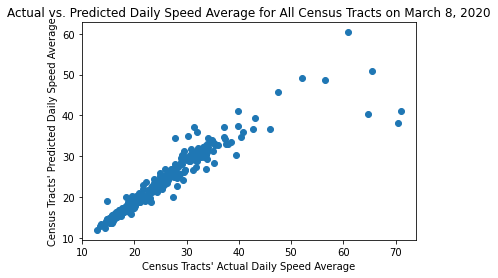

In [105]:
plt.scatter(x=time_series_y_post_8, y=reg.predict(time_series_x_pre_8))
plt.title('Actual vs. Predicted Daily Speed Average for All Census Tracts on March 8, 2020')
plt.xlabel("Census Tracts' Actual Daily Speed Average")
plt.ylabel("Census Tracts' Predicted Daily Speed Average");

In [106]:
#QUESTION 1
T = 5
r2_scores = []
for i in range(T+1, len(time_series.columns)+1):
    start = i-T
    end = i
    df_temp = time_series.loc[:, start:end]
    time_series_x, time_series_y, time_series_x_val, time_series_y_val = time_series_to_dataset(df_temp, 5, 0)
    
    y_pred = reg.predict(time_series_x)
    score_temp = r2_score(time_series_y, y_pred)
    r2_scores.append(score_temp)

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

Generate line plot.
<!--
BEGIN QUESTION
name: q4bii2
points: 1
manual: True
-->

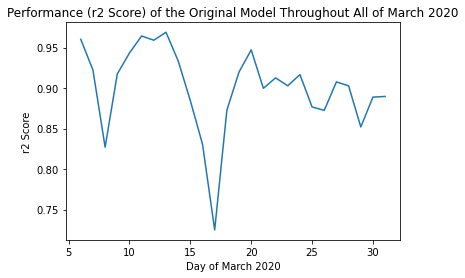

In [107]:
plt.plot(time_series.columns[5:], r2_scores)
plt.title('Performance (r2 Score) of the Original Model Throughout All of March 2020')
plt.xlabel('Day of March 2020')
plt.ylabel('r2 Score');

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

Generate a scatter plot.
<!--
BEGIN QUESTION
name: q4bii3
points: 1
manual: True
-->

In [108]:
#QUESTION 6
df_17 = time_series.loc[:, 12:17]
time_series_x, time_series_y, time_series_x_val, time_series_y_val = time_series_to_dataset(df_17, 5, 0)
y_pred = reg.predict(time_series_x)
score_pre_17th = r2_score(time_series_y, y_pred)
score_pre_17th

0.7248438392437919

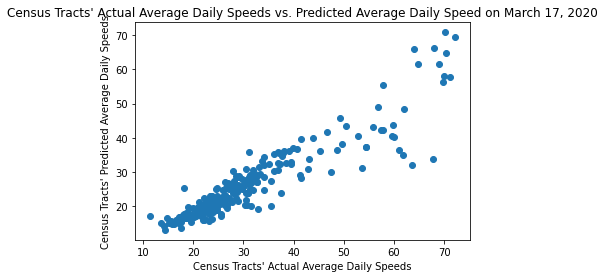

In [109]:
# create the scatter plot below
plt.scatter(x=time_series_y, y=y_pred)
plt.title("Census Tracts' Actual Average Daily Speeds vs. Predicted Average Daily Speed on March 17, 2020")
plt.xlabel("Census Tracts' Actual Average Daily Speeds")
plt.ylabel("Census Tracts' Predicted Average Daily Speeds");

<!-- END QUESTION -->



## 4.c. "Fix" model on post-lockdown data

Per this survey https://pure.tue.nl/ws/files/3488790/740215.pdf, there are 4 categories of fixes for change points:
- Forgetting mechanisms
- Explicit change detection
- Ensemble techniques
- Context-aware approaches

In this part, we'll combine insights in model errors with previous EDA insights to produce a fix.

<!-- BEGIN QUESTION -->

### 4.c.i. Learn delta off of a moving bias

According to our previous work in EDA, the average speed shoots upwards sharply. As a result, our trick to learn delta the around the average and to naively assume that the average of day $t$ is the average for day $t+1$. We will do this in 4 steps:

1. **Create a dataset for your delta model**.
2. **Train your delta model** on pre-lockdown data.
3. **Evaluate your model on pre-lockdown data**, to ensure that the model has learned to a satisfactory degree, in the nominal case. Remember the naive model achieved 0.97 r^2 on pre-lockdown data.
4. **Evaluate your model on the 17th**, to compare against the naive model also evaluated on that day. Notice that your r^2 score has improved by 10%+. Why is your delta model so effective for the 17th?
5. **Evaluate your model on the 14th**, to compare against the naive model also evaluated on that day. Notice that your r^2 score is now complete garbage. Why is your delta so ineffective for the 14th?

**Hint**: As you build your datasets, always check to make sure you're using the right days! It's easy to have a one-off error that throws off your results.

Write your written questions in the next cell, then write the code in the following cells.

<!--
BEGIN QUESTION
name: q4ci1
points: 2
manual: True
-->

4. Evaluate your model on the 17th, to compare against the naive model also evaluated on that day. Notice that your r^2 score has improved by 10%+. Why is your delta model so effective for the 17th?

Our delta model is so effective for the 17th because the new delta model is better able to adjust and predict speeds for post-lockdown days. Since we subtract the speed for every day by each day's average speed, our model now predicts the change of speed compared to the day's averages, instead of the actual speed. Now, even though the speeds increase post-lockdown due to less traffic, since the average speed increases as well, our model still does well and has a high r^2 score for the 17th.

Question 5 dropped.

<!-- END QUESTION -->

<!--
BEGIN QUESTION
name: q4ci2
points: 1
-->

In [110]:
time_series_delta = time_series_pre - speeds_daily[:13] # subtract daily average from pre-lockdown 'time series' dataframe `time_series_pre`
time_series_delta

day                 1         2         3         4         5         6   \
MOVEMENT_ID                                                                
9            -7.436210 -7.929735 -7.957726 -7.706332 -7.673488 -8.288859   
20           -6.215082 -6.863900 -6.363125 -6.511982 -6.693731 -6.873540   
21           -8.491956 -9.147858 -8.044932 -7.879632 -7.907553 -8.464493   
44            1.446417  1.167730  0.901289  0.342397 -0.110985  0.981564   
78           -7.458664 -5.569360 -5.787301 -5.813345 -6.320619 -6.303126   
...                ...       ...       ...       ...       ...       ...   
2691               NaN       NaN       NaN       NaN -3.385687 -4.313850   
2694         -5.823366 -5.598968 -5.295639 -5.485229 -5.482634 -5.448377   
2695         -3.527067 -2.096006 -1.977287 -1.785869  0.371917 -2.850371   
2700         10.953762  9.047451  9.039961  9.069252  9.650690  8.113142   
2708          1.543108  2.401007  2.303618  2.355356  2.378369  2.989213   

day                 7          8         9          10        11        12  \
MOVEMENT_ID                                                                  
9            -7.342673  -7.838718 -8.163539  -7.950124 -9.037052 -8.687048   
20           -5.762984  -5.960594 -6.830754  -7.366163 -8.139844 -8.795882   
21           -8.893040  -9.407162 -7.392644  -7.811186 -8.986853 -8.505135   
44            0.024509   1.604391  0.492527   0.078211  0.979607  1.910786   
78           -7.548693  -4.765377 -6.755502  -6.530367 -7.003837 -6.987069   
...                ...        ...       ...        ...       ...       ...   
2691          0.621691        NaN -3.970859        NaN       NaN -0.971484   
2694         -5.423980  -5.992169 -5.698587  -5.662927 -5.885166 -6.070161   
2695         -3.627592  -4.578175 -2.511783  -2.260573  1.093583 -2.863087   
2700         10.730575  11.394160  9.171008  10.290198  8.797572  9.094474   
2708          2.700848   2.246655  2.503544   2.224406  1.125645  2.184237   

day                13  
MOVEMENT_ID            
9           -9.364599  
20          -8.883074  
21          -8.143181  
44          -0.144157  
78          -7.112274  
...               ...  
2691              NaN  
2694        -5.761289  
2695        -2.977301  
2700         8.013932  
2708         1.129593  

[295 rows x 13 columns]

In [111]:
grader.check("q4ci2")

q4ci2 results: All test cases passed!

In [112]:
X_delta_train, y_delta_train, X_delta_val, y_delta_val = time_series_to_dataset(time_series_delta, 5, 2)
#time_series_to_dataset(time_series: pd.DataFrame, T: int, n_val: int)
reg_delta = LinearRegression().fit(X_delta_train, y_delta_train)
res_4ci3 = reg_delta.score(X_delta_val, y_delta_val) # learning delta as easy as learning original dataset!
res_4ci3

0.9645254590172871

In [113]:
grader.check("q4ci3")

q4ci3 results: All test cases passed!

In [114]:
time_series_delta_all = time_series - speeds_daily
df_17 = time_series_delta_all.loc[:, 12:17]
time_series_x, time_series_y, time_series_x_val, time_series_y_val = time_series_to_dataset(df_17, 5, 0)
y_pred = reg_delta.predict(time_series_x)
score_pre_17th = r2_score(time_series_y, y_pred)
res_4ci4 = score_pre_17th
res_4ci4

0.8346539614612526

In [115]:
grader.check("q4ci4")

q4ci4 results:
    q4ci4 - 1 result:
        Trying:
            np.isclose(res_4ci4, 0.8616633417528182, rtol=1e-4, atol=1e-4)
        Expecting:
            True
        **********************************************************************
        Line 1, in q4ci4 0
        Failed example:
            np.isclose(res_4ci4, 0.8616633417528182, rtol=1e-4, atol=1e-4)
        Expected:
            True
        Got:
            False

In [116]:
#QUESTION DROPPED
df_14 = time_series_delta_all.loc[:, 9:14]
time_series_x, time_series_y, time_series_x_val, time_series_y_val = time_series_to_dataset(df_14, 5, 0)
y_pred = reg_delta.predict(time_series_x)
score_pre_14th = r2_score(time_series_y, y_pred)
res_4ci5 = score_pre_14th
res_4ci5

0.9444984631185283

In [117]:
grader.check("q4ci5")

q4ci5 results:
    q4ci5 - 1 result:
        Trying:
            np.isclose(res_4ci5, 0.11611253470677951, rtol=1e-4, atol=1e-4)
        Expecting:
            True
        **********************************************************************
        Line 1, in q4ci5 0
        Failed example:
            np.isclose(res_4ci5, 0.11611253470677951, rtol=1e-4, atol=1e-4)
        Expected:
            True
        Got:
            False

### 4.c.ii. Does it "solve itself"? Does the pre-lockdown model predict, after the change point?

Had we ignored the problem, would we have been okay? The temporal plot above showing performance over time suggests a partial recovery. **Evaluate the original, naive model on all post-lockdown data** to see. If your final r^2 score does not match the autograder's:
- Double check you have selected daily average speeds for the right days, by printing your dataframe.
- Double check you're using the right model (a brand new trained model)
- Check you're using `T=5, n_val=2`

<!--
BEGIN QUESTION
name: q4cii
points: 1
-->

In [118]:
df_post = time_series.loc[:, 14:31]
time_series_x, time_series_y, time_series_x_val, time_series_y_val = time_series_to_dataset(df_post, 5, 0)
y_pred = reg.predict(time_series_x)
score_og_post = r2_score(time_series_y, y_pred)
score_og_post

0.9014738674628208

In [119]:
grader.check("q4cii")

q4cii results: All test cases passed!

### 4.c.iii. Naively retrain model with post-lockdown data

Can we use the same tactics--that we used to train the original model on pre-lockdown data--to train on the post-lockdown data? **Retrain a linear model and evaluate on post-lockdown data only**. You should construct a new dataset using `time_series_to_dataset` using only time series from March 14 to March 31. If your final r^2 score does not match the autograder's:
- Double check you have selected daily average speeds for the right days, by printing your dataframe.
- Double check you're using the right model (a brand new trained model)
- Check you're using `T=5, n_val=2`

<!--
BEGIN QUESTION
name: q4ciii
points: 1
-->

In [120]:
time_series_x, time_series_y, time_series_x_val, time_series_y_val = time_series_to_dataset(df_post, 5, 2)
reg2 = LinearRegression().fit(time_series_x, time_series_y) # set to trained linear model
pred_val = reg2.predict(time_series_x_val)
score_post = r2_score(time_series_y_val, pred_val)
score_post

0.8993687576351703

In [121]:
grader.check("q4ciii")

q4ciii results: All test cases passed!

### 4.c.iv. What if you just ignore the change point?

Turns out, this is no good. Even acknowledging the change point and training *either* before *or* after is better. Being ignorant and training on *both* is the worst option, producing a lower r^2.

<!--
BEGIN QUESTION
name: q4civ
points: 1
-->

In [122]:
time_series_x, time_series_y, time_series_x_val, time_series_y_val = time_series_to_dataset(time_series, 5, 5)
reg3 = LinearRegression().fit(time_series_x, time_series_y) # set to trained linear model
pred_val = reg3.predict(time_series_x_val)
res_4civ = r2_score(time_series_y_val, pred_val)
res_4civ

0.8843433608623491

In [123]:
grader.check("q4civ")

q4civ results: All test cases passed!

# Step 5 - Open-Ended Modeling: Predicting travel time post-lockdown

*This* is the real deal and ultimately what Uber cares about. Traffic speeds is a proxy task, but the bottom line and moneymaking machine relies on this travel time estimation. Focus on designing experiments instead of focusing on experimental, quantitative results. Your experiments are successful if they inform a decision, even despite a lower-performing model.

## Question 5a

Train a baseline model of your choice using any supervised learning approach we have studied; you are not limited to a linear model.


**Example**

Given the data for this question, you could build a model to predict travel time from Cheesecake Factory to UC Berkeley.

# Data Cleaning

In [124]:
#Dataset from outside source - Elevation dataset: https://catalog.data.gov/dataset/elevation-contours/resource/e2362085-3a2e-4bac-88ee-b33ab4f8403f
#df_elevation = tract_to_gps.merge(elevation, left_on='MOVEMENT_ID', right_on='OBJECTID')
#df_elevation = df_elevation[['MOVEMENT_ID', 'ELEVATION']]
#df_elevation.head()

In [125]:
#Dataset from outside source - Boba dataset: https://www.kaggle.com/vnxiclaire/bobabayarea
#boba_shops = pd.read_csv('data/bayarea_boba_spots.csv')
#grouped_boba = boba_shops.groupby('city').count()[['id']].reset_index().rename(columns={'id': 'Number of boba shops'})
#grouped_boba.head()

In [126]:
'''
df_differences_ = df_differences.rename(columns={"Mean Travel Time (Seconds)_x": "Mean Travel Time (Seconds) Pre-Lockdown", 
                                                "Mean Travel Time (Seconds)_y": "Mean Travel Time (Seconds) Post-Lockdown", 
                                                "DISPLAY_NAME_x": "Destination Display Name",
                                                'MOVEMENT_ID': 'Destination Movement ID',
                                                'difference': 'Difference in Mean Travel Time (Seconds) Post and Pre-Lockdown'})
df_differences_clean = df_differences_.drop(['Destination Movement ID_x', 'geometry_x', 'Destination Movement ID_y', 'DISPLAY_NAME_y', 'geometry_y'], axis=1)
df_differences_clean['Area of Destination Census Tract'] = [item.area for item in df_differences_clean['geometry']]
df_differences_clean['Origin Movement ID'] = times_to_tract['Origin Movement ID']
df_differences_clean['Origin Display Name'] = times_to_tract['Origin Display Name']
df_differences_clean_ = df_differences_clean.merge(tract_to_gps, left_on='Origin Movement ID', right_on='MOVEMENT_ID')
df_differences_clean_ = df_differences_clean_.drop(['MOVEMENT_ID', 'DISPLAY_NAME'], axis=1)
df_differences_clean_ = df_differences_clean_.rename(columns={"Mean Travel Time (Seconds)_x": "Mean Travel Time (Seconds) Pre-Lockdown", 
                                                "Mean Travel Time (Seconds)_y": "Mean Travel Time (Seconds) Post-Lockdown", 
                                                "DISPLAY_NAME_x": "Destination Display Name",
                                                'geometry_x': 'geometry',
                                                'geometry_y': 'geometry initial'})
df_differences_clean_['Distance to Destination'] = [item.distance(df_differences_clean_['geometry initial'][0]) for item in df_differences_clean_['geometry']]
df_differences_clean_['Difference in Weekend Days Visited Post- and Pre-Lockdown'] = df_differences_count_wknd['difference']
df_differences_clean_['Difference in Weekdays Visited Post- and Pre-Lockdown'] = df_differences_count_wkday['difference']
df_differences_clean_['Difference in Total Days Visited Post- and Pre-Lockdown'] = df_differences_count['difference']
'''

'\ndf_differences_ = df_differences.rename(columns={"Mean Travel Time (Seconds)_x": "Mean Travel Time (Seconds) Pre-Lockdown", \n                                                "Mean Travel Time (Seconds)_y": "Mean Travel Time (Seconds) Post-Lockdown", \n                                                "DISPLAY_NAME_x": "Destination Display Name",\n                                                \'MOVEMENT_ID\': \'Destination Movement ID\',\n                                                \'difference\': \'Difference in Mean Travel Time (Seconds) Post and Pre-Lockdown\'})\ndf_differences_clean = df_differences_.drop([\'Destination Movement ID_x\', \'geometry_x\', \'Destination Movement ID_y\', \'DISPLAY_NAME_y\', \'geometry_y\'], axis=1)\ndf_differences_clean[\'Area of Destination Census Tract\'] = [item.area for item in df_differences_clean[\'geometry\']]\ndf_differences_clean[\'Origin Movement ID\'] = times_to_tract[\'Origin Movement ID\']\ndf_differences_clean[\'Origin Display Name\'

In [127]:
'''
df_differences_clean_ = df_differences_clean_.merge(df_elevation, left_on='Destination Movement ID', right_on='MOVEMENT_ID').drop('MOVEMENT_ID', axis=1)
df_differences_clean_.head()
'''

"\ndf_differences_clean_ = df_differences_clean_.merge(df_elevation, left_on='Destination Movement ID', right_on='MOVEMENT_ID').drop('MOVEMENT_ID', axis=1)\ndf_differences_clean_.head()\n"

In [128]:
'''
df_differences_clean_['Destination Movement ID'] = [str(item) for item in df_differences_clean_['Destination Movement ID']]
df_differences_clean_['Street'] = [item.split(", ")[0] for item in df_differences_clean_['Destination Display Name']]
df_differences_clean_['Neighborhood'] = [item.split(", ")[1] for item in df_differences_clean_['Destination Display Name']]
df_differences_clean_['City'] = [item.split(", ")[1] if len(item.split(", "))==2 else item.split(", ")[2] for item in df_differences_clean_['Destination Display Name'] ]
'''

'\ndf_differences_clean_[\'Destination Movement ID\'] = [str(item) for item in df_differences_clean_[\'Destination Movement ID\']]\ndf_differences_clean_[\'Street\'] = [item.split(", ")[0] for item in df_differences_clean_[\'Destination Display Name\']]\ndf_differences_clean_[\'Neighborhood\'] = [item.split(", ")[1] for item in df_differences_clean_[\'Destination Display Name\']]\ndf_differences_clean_[\'City\'] = [item.split(", ")[1] if len(item.split(", "))==2 else item.split(", ")[2] for item in df_differences_clean_[\'Destination Display Name\'] ]\n'

In [129]:
'''
df_differences_clean_ = df_differences_clean_.merge(grouped_boba, left_on='City', right_on='city').drop('city', axis=1)
df_differences_clean_.head()
'''

"\ndf_differences_clean_ = df_differences_clean_.merge(grouped_boba, left_on='City', right_on='city').drop('city', axis=1)\ndf_differences_clean_.head()\n"

In [130]:
#geo_differences_ = gpd.GeoDataFrame(df_differences_clean_)

In [131]:
'''
geo_differences_ = gpd.GeoDataFrame(df_differences_clean_)
ax_3 = geo_differences_.plot('Area of Destination Census Tract', 
                            legend=True, 
                            legend_kwds={'label': "Area of Census Tract (in square feet)"}, 
                            figsize=(10, 10), 
                            alpha=0.99, 
                            edgecolor='k',
                            cmap="Reds"
                            );
cx.add_basemap(ax_3, crs=geo_differences_.crs)
plt.title('Area of Census Tract (in square feet)')
plt.xlabel("Latitude in world geodesic coordinate system")
plt.ylabel("Longitude in world geodesic coordinate system");
'''

'\ngeo_differences_ = gpd.GeoDataFrame(df_differences_clean_)\nax_3 = geo_differences_.plot(\'Area of Destination Census Tract\', \n                            legend=True, \n                            legend_kwds={\'label\': "Area of Census Tract (in square feet)"}, \n                            figsize=(10, 10), \n                            alpha=0.99, \n                            edgecolor=\'k\',\n                            cmap="Reds"\n                            );\ncx.add_basemap(ax_3, crs=geo_differences_.crs)\nplt.title(\'Area of Census Tract (in square feet)\')\nplt.xlabel("Latitude in world geodesic coordinate system")\nplt.ylabel("Longitude in world geodesic coordinate system");\n'

# Additional Exploratory Data Analysis on New Features

In [132]:
#df_differences_clean_.corr()

In [133]:
#import seaborn as sns
#sns.heatmap(df_differences_clean_.corr(), annot=True, lw=1)

In [134]:
#df_differences_clean_.describe()

In [135]:
#import seaborn as sns
#sns.pairplot(df_differences_clean_)

In [136]:
#import plotly.express as px
#fig = px.violin(df_differences_clean_, y='Difference in Mean Travel Time (Seconds) Post and Pre-Lockdown', x="Neighborhood", box=True, points="all", 
#               title='Distribution of Differences in Mean Travel Time (Seconds) for Neighborhoods in Bay Area')
#fig.show()

In [137]:
#fig = px.violin(df_differences_clean_, y='Difference in Mean Travel Time (Seconds) Post and Pre-Lockdown', x="City", box=True, points="all",
#               title='Distribution of Differences in Mean Travel Time (Seconds) for Cities in Bay Area')
#fig.show()

In [138]:
'''
plt.scatter(df_differences_clean_['Distance to Destination'], df_differences_clean_['Difference in Mean Travel Time (Seconds) Post and Pre-Lockdown'])
plt.title('Distance to Destination vs. Difference in Mean Travel Time (Seconds) Post and Pre-Lockdown')
plt.xlabel('Distance to Destination');
plt.ylabel('Difference in Mean Travel Time (Seconds) Post and Pre-Lockdown');
'''

"\nplt.scatter(df_differences_clean_['Distance to Destination'], df_differences_clean_['Difference in Mean Travel Time (Seconds) Post and Pre-Lockdown'])\nplt.title('Distance to Destination vs. Difference in Mean Travel Time (Seconds) Post and Pre-Lockdown')\nplt.xlabel('Distance to Destination');\nplt.ylabel('Difference in Mean Travel Time (Seconds) Post and Pre-Lockdown');\n"

In [139]:
'''
X = df_differences_clean_['Distance to Destination']
y = df_differences_clean_['Difference in Mean Travel Time (Seconds) Post and Pre-Lockdown']
theta = np.polyfit(X, y, 1)

print(f'The parameters of the line: {theta}')
print(f'Equation of best fit line: y_hat = {theta[0]} X + {theta[1]}')

# Now, calculating the y-axis values against x-values according to
# the parameters theta0, theta1 and theta2
y_line = theta[1] + theta[0] * X
print('r2 score: ', r2_score(y, y_line))
plt.scatter(X, y)
plt.title('Distance to Destination vs. Difference in Mean Travel Time (Seconds) Post and Pre-Lockdown')
plt.xlabel('Distance to Destination');
plt.ylabel('Difference in Mean Travel Time (Seconds) Post and Pre-Lockdown');
plt.plot(X, y_line, 'r');
'''

"\nX = df_differences_clean_['Distance to Destination']\ny = df_differences_clean_['Difference in Mean Travel Time (Seconds) Post and Pre-Lockdown']\ntheta = np.polyfit(X, y, 1)\n\nprint(f'The parameters of the line: {theta}')\nprint(f'Equation of best fit line: y_hat = {theta[0]} X + {theta[1]}')\n\n# Now, calculating the y-axis values against x-values according to\n# the parameters theta0, theta1 and theta2\ny_line = theta[1] + theta[0] * X\nprint('r2 score: ', r2_score(y, y_line))\nplt.scatter(X, y)\nplt.title('Distance to Destination vs. Difference in Mean Travel Time (Seconds) Post and Pre-Lockdown')\nplt.xlabel('Distance to Destination');\nplt.ylabel('Difference in Mean Travel Time (Seconds) Post and Pre-Lockdown');\nplt.plot(X, y_line, 'r');\n"

In [140]:
'''
plt.scatter(df_differences_clean_['Area of Destination Census Tract'], df_differences_clean_['Difference in Mean Travel Time (Seconds) Post and Pre-Lockdown'])
plt.title('Area of Destination Census Tract vs. Difference in Mean Travel Time (Seconds) Post and Pre-Lockdown')
plt.xlabel('Area of Destination Census Tract');
plt.ylabel('Difference in Mean Travel Time (Seconds) Post and Pre-Lockdown');
'''

"\nplt.scatter(df_differences_clean_['Area of Destination Census Tract'], df_differences_clean_['Difference in Mean Travel Time (Seconds) Post and Pre-Lockdown'])\nplt.title('Area of Destination Census Tract vs. Difference in Mean Travel Time (Seconds) Post and Pre-Lockdown')\nplt.xlabel('Area of Destination Census Tract');\nplt.ylabel('Difference in Mean Travel Time (Seconds) Post and Pre-Lockdown');\n"

In [141]:
'''
plt.scatter(np.log(df_differences_clean_['Area of Destination Census Tract']), df_differences_clean_['Difference in Mean Travel Time (Seconds) Post and Pre-Lockdown'])
plt.title('Log of Area of Destination Census Tract vs. Difference in Mean Travel Time (Seconds) Post and Pre-Lockdown')
plt.xlabel('Log of Area of Destination Census Tract');
plt.ylabel('Difference in Mean Travel Time (Seconds) Post and Pre-Lockdown');
'''

"\nplt.scatter(np.log(df_differences_clean_['Area of Destination Census Tract']), df_differences_clean_['Difference in Mean Travel Time (Seconds) Post and Pre-Lockdown'])\nplt.title('Log of Area of Destination Census Tract vs. Difference in Mean Travel Time (Seconds) Post and Pre-Lockdown')\nplt.xlabel('Log of Area of Destination Census Tract');\nplt.ylabel('Difference in Mean Travel Time (Seconds) Post and Pre-Lockdown');\n"

In [142]:
'''
fig = px.violin(df_differences_clean_, y='Difference in Mean Travel Time (Seconds) Post and Pre-Lockdown', x='Difference in Total Days Visited Post- and Pre-Lockdown', box=True, points="all",
               title='Distribution of Differences in Mean Travel Time (Seconds) for Difference in Total Days Visited Post- and Pre-Lockdown')
fig.show()
'''

'\nfig = px.violin(df_differences_clean_, y=\'Difference in Mean Travel Time (Seconds) Post and Pre-Lockdown\', x=\'Difference in Total Days Visited Post- and Pre-Lockdown\', box=True, points="all",\n               title=\'Distribution of Differences in Mean Travel Time (Seconds) for Difference in Total Days Visited Post- and Pre-Lockdown\')\nfig.show()\n'

In [143]:
'''
fig = px.violin(df_differences_clean_, y='Difference in Mean Travel Time (Seconds) Post and Pre-Lockdown', x='Difference in Weekend Days Visited Post- and Pre-Lockdown', box=True, points="all",
               title='Distribution of Differences in Mean Travel Time (Seconds) for Difference in Weekend Days Visited Post- and Pre-Lockdown')
fig.show()
'''

'\nfig = px.violin(df_differences_clean_, y=\'Difference in Mean Travel Time (Seconds) Post and Pre-Lockdown\', x=\'Difference in Weekend Days Visited Post- and Pre-Lockdown\', box=True, points="all",\n               title=\'Distribution of Differences in Mean Travel Time (Seconds) for Difference in Weekend Days Visited Post- and Pre-Lockdown\')\nfig.show()\n'

Insight from additional exploratory data analysis:
1. Distance to destination has strong linear correlation with response variable, likely good predictor and should add to model
2. Difference in weekend days, total days, weekdays, as well as geographic area of destination census tract, elevation, and number of boba shops are not the strongest features - have low correlation with y variable
3. Cities and neighborhoods make good baseline model

# Baseline Multiple Linear Regression Model using City & Neighborhood

In [144]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn import metrics

In [145]:
'''
X = df_differences_clean_[[
    'City',
    'Neighborhood'
]]
y = df_differences_clean_['Difference in Mean Travel Time (Seconds) Post and Pre-Lockdown']
'''

"\nX = df_differences_clean_[[\n    'City',\n    'Neighborhood'\n]]\ny = df_differences_clean_['Difference in Mean Travel Time (Seconds) Post and Pre-Lockdown']\n"

In [146]:
#X_train_, X_test_, y_train_, y_test_ = train_test_split(X, y, test_size=0.2)

In [147]:
'''
baseline_m = Pipeline([
    ('SelectColumns', ColumnTransformer([
        ('neighborhood_encoder', OneHotEncoder(handle_unknown='ignore'), ['Neighborhood']),
        ('city_encoder', OneHotEncoder(handle_unknown='ignore'), ['City']),
    ])),
    ('Imputation', SimpleImputer()),
    ('LinearRegressionModel', LinearRegression())
])
'''

"\nbaseline_m = Pipeline([\n    ('SelectColumns', ColumnTransformer([\n        ('neighborhood_encoder', OneHotEncoder(handle_unknown='ignore'), ['Neighborhood']),\n        ('city_encoder', OneHotEncoder(handle_unknown='ignore'), ['City']),\n    ])),\n    ('Imputation', SimpleImputer()),\n    ('LinearRegressionModel', LinearRegression())\n])\n"

In [148]:
#baseline_m.fit(X_train_, y_train_)

In [149]:
#baseline_m.score(X_test_, y_test_) #r2 score on test set

In [150]:
#np.mean(cross_val_score(baseline_m, X, y, cv=3, scoring='r2'))

In [151]:
#baseline_m.score(X_train_, y_train_) #r2 score on train set

In [152]:
'''
from sklearn.metrics import mean_squared_error
y_train_pred_ = baseline_m.predict(X_train_)
print('rmse for training data: ', mean_squared_error(y_train_, y_train_pred_)**0.5)
'''

"\nfrom sklearn.metrics import mean_squared_error\ny_train_pred_ = baseline_m.predict(X_train_)\nprint('rmse for training data: ', mean_squared_error(y_train_, y_train_pred_)**0.5)\n"

In [153]:
'''
plt.scatter(y_train_, y_train_pred_)
plt.title('actual difference vs. predicted difference in mean travel time between post- and pre-lockdown for training data')
plt.plot(y_train_, y_train_, color = 'red', label = 'x=y')
plt.legend()
plt.xlabel('actual difference in mean travel time')
plt.ylabel('predicted difference in travel time');
'''

"\nplt.scatter(y_train_, y_train_pred_)\nplt.title('actual difference vs. predicted difference in mean travel time between post- and pre-lockdown for training data')\nplt.plot(y_train_, y_train_, color = 'red', label = 'x=y')\nplt.legend()\nplt.xlabel('actual difference in mean travel time')\nplt.ylabel('predicted difference in travel time');\n"

In [154]:
'''
y_pred_ = baseline_m.predict(X_test_)
print('rmse for testing data: ',mean_squared_error(y_test_, y_pred_)**0.5)
'''

"\ny_pred_ = baseline_m.predict(X_test_)\nprint('rmse for testing data: ',mean_squared_error(y_test_, y_pred_)**0.5)\n"

In [155]:
'''
plt.scatter(y_test_, y_pred_)
plt.title('actual difference vs. predicted difference in mean travel time between post- and pre-lockdown for testing data')
plt.plot(y_test_, y_test_, color = 'red', label = 'x=y')
plt.legend()
plt.xlabel('actual difference in mean travel time')
plt.ylabel('predicted difference in travel time');
'''

"\nplt.scatter(y_test_, y_pred_)\nplt.title('actual difference vs. predicted difference in mean travel time between post- and pre-lockdown for testing data')\nplt.plot(y_test_, y_test_, color = 'red', label = 'x=y')\nplt.legend()\nplt.xlabel('actual difference in mean travel time')\nplt.ylabel('predicted difference in travel time');\n"

Flaws:
1. Not enough features --> add additional features that are able to better predict change in travel time
2. Performance on training data significantly better than performance on testing data --> overfitting, perform regularization

## Question 5b

Improve on your baseline model. Specify the model you designed and its input features. Justify why you chose these features and their relevance to your model's predictions.
'
**Example**

Here are potential questions to consider for this part: How does the other variant of your travel times dataset, aggregated across time but reported for all routes, useful?  What additional data from the Uber Movement website can you export to better your model?

# Improvement 1: Add more features (distance to destination) and standardize

In [156]:
'''
X = df_differences_clean_[[
    'Distance to Destination',
    'City',
    'Neighborhood'
]]
y = df_differences_clean_['Difference in Mean Travel Time (Seconds) Post and Pre-Lockdown']
'''

"\nX = df_differences_clean_[[\n    'Distance to Destination',\n    'City',\n    'Neighborhood'\n]]\ny = df_differences_clean_['Difference in Mean Travel Time (Seconds) Post and Pre-Lockdown']\n"

In [157]:
#X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, y, test_size=0.2)

In [158]:
'''
quantitative_features = [
    'Distance to Destination'
]
m2 = Pipeline([
    ('SelectColumns', ColumnTransformer([
        ('keep', StandardScaler(), quantitative_features),
        ('city_encoder', OneHotEncoder(handle_unknown='ignore'), ['City']),
        ('neighborhood_encoder', OneHotEncoder(handle_unknown='ignore'), ['Neighborhood'])
    ])),
    ('Imputation', SimpleImputer()),
    ('LinearRegressionModel', LinearRegression())
])
'''

"\nquantitative_features = [\n    'Distance to Destination'\n]\nm2 = Pipeline([\n    ('SelectColumns', ColumnTransformer([\n        ('keep', StandardScaler(), quantitative_features),\n        ('city_encoder', OneHotEncoder(handle_unknown='ignore'), ['City']),\n        ('neighborhood_encoder', OneHotEncoder(handle_unknown='ignore'), ['Neighborhood'])\n    ])),\n    ('Imputation', SimpleImputer()),\n    ('LinearRegressionModel', LinearRegression())\n])\n"

In [159]:
#m2.fit(X_train_2, y_train_2)

In [160]:
#m2.score(X_train_2, y_train_2) # accuracy

In [161]:
'''
from sklearn.metrics import mean_squared_error
y_train_pred_2 = m2.predict(X_train_2)
print('rmse for training data: ', mean_squared_error(y_train_2, y_train_pred_2)**0.5)
'''

"\nfrom sklearn.metrics import mean_squared_error\ny_train_pred_2 = m2.predict(X_train_2)\nprint('rmse for training data: ', mean_squared_error(y_train_2, y_train_pred_2)**0.5)\n"

In [162]:
'''
plt.scatter(y_train_2, y_train_pred_2)
plt.title('actual difference vs. predicted difference in mean travel time between post- and pre-lockdown for training data')
plt.plot(y_train_2, y_train_2, color = 'red', label = 'x=y')
plt.legend()
plt.xlabel('actual difference in mean travel time')
plt.ylabel('predicted difference in travel time');
'''

"\nplt.scatter(y_train_2, y_train_pred_2)\nplt.title('actual difference vs. predicted difference in mean travel time between post- and pre-lockdown for training data')\nplt.plot(y_train_2, y_train_2, color = 'red', label = 'x=y')\nplt.legend()\nplt.xlabel('actual difference in mean travel time')\nplt.ylabel('predicted difference in travel time');\n"

In [163]:
#m2.score(X_test_2, y_test_2) # accuracy

In [164]:
#np.mean(cross_val_score(m2, X, y, cv=3, scoring='r2'))

In [165]:
#y_pred_2 = m2.predict(X_test_2)
#print('rmse for testing data: ',mean_squared_error(y_test_2, y_pred_2)**0.5)

In [166]:
'''
plt.scatter(y_test_, y_pred_)
plt.title('actual difference vs. predicted difference in mean travel time between post- and pre-lockdown for testing data')
plt.plot(y_test_, y_test_, color = 'red', label = 'x=y')
plt.legend()
plt.xlabel('actual difference in mean travel time')
plt.ylabel('predicted difference in travel time');
'''

"\nplt.scatter(y_test_, y_pred_)\nplt.title('actual difference vs. predicted difference in mean travel time between post- and pre-lockdown for testing data')\nplt.plot(y_test_, y_test_, color = 'red', label = 'x=y')\nplt.legend()\nplt.xlabel('actual difference in mean travel time')\nplt.ylabel('predicted difference in travel time');\n"

Takeaways:
1. Both r2 and RMSE better than baseline model for both training and testing data
2. Performance on testing dataset still significantly worse than performance on training dataset --> sign of overfitting, combat with regularization

# Improvement 2: Perform Regularization

In [167]:
'''
X = df_differences_clean_[[
    'Area of Destination Census Tract', 
    'Distance to Destination',
    'Difference in Weekend Days Visited Post- and Pre-Lockdown',
    'Difference in Weekdays Visited Post- and Pre-Lockdown',
    'Difference in Total Days Visited Post- and Pre-Lockdown', 
    'ELEVATION',
    'Number of boba shops',
    'Destination Movement ID',
    'City',
    'Neighborhood'
]]
y = df_differences_clean_['Difference in Mean Travel Time (Seconds) Post and Pre-Lockdown']
'''

"\nX = df_differences_clean_[[\n    'Area of Destination Census Tract', \n    'Distance to Destination',\n    'Difference in Weekend Days Visited Post- and Pre-Lockdown',\n    'Difference in Weekdays Visited Post- and Pre-Lockdown',\n    'Difference in Total Days Visited Post- and Pre-Lockdown', \n    'ELEVATION',\n    'Number of boba shops',\n    'Destination Movement ID',\n    'City',\n    'Neighborhood'\n]]\ny = df_differences_clean_['Difference in Mean Travel Time (Seconds) Post and Pre-Lockdown']\n"

In [168]:
#X_train_, X_test_, y_train_, y_test_ = train_test_split(X, y, test_size=0.2)

In [169]:
'''
quantitative_features = [
    'Area of Destination Census Tract', 
    'Distance to Destination',
    'Difference in Weekend Days Visited Post- and Pre-Lockdown',
    'Difference in Weekdays Visited Post- and Pre-Lockdown',
    'Difference in Total Days Visited Post- and Pre-Lockdown', 
    'ELEVATION',
    'Number of boba shops'
]
m = Pipeline([
    ('SelectColumns', ColumnTransformer([
        ('keep', StandardScaler(), quantitative_features),
        ('census_tract_encoder', OneHotEncoder(handle_unknown='ignore'), ['Destination Movement ID']),
        ('neighborhood_encoder', OneHotEncoder(handle_unknown='ignore'), ['Neighborhood']),
        ('city_encoder', OneHotEncoder(handle_unknown='ignore'), ['City'])
    ])),
    ('Imputation', SimpleImputer()),
    ('LinearRegressionModel', linear_model.Ridge())
])
'''

"\nquantitative_features = [\n    'Area of Destination Census Tract', \n    'Distance to Destination',\n    'Difference in Weekend Days Visited Post- and Pre-Lockdown',\n    'Difference in Weekdays Visited Post- and Pre-Lockdown',\n    'Difference in Total Days Visited Post- and Pre-Lockdown', \n    'ELEVATION',\n    'Number of boba shops'\n]\nm = Pipeline([\n    ('SelectColumns', ColumnTransformer([\n        ('keep', StandardScaler(), quantitative_features),\n        ('census_tract_encoder', OneHotEncoder(handle_unknown='ignore'), ['Destination Movement ID']),\n        ('neighborhood_encoder', OneHotEncoder(handle_unknown='ignore'), ['Neighborhood']),\n        ('city_encoder', OneHotEncoder(handle_unknown='ignore'), ['City'])\n    ])),\n    ('Imputation', SimpleImputer()),\n    ('LinearRegressionModel', linear_model.Ridge())\n])\n"

In [170]:
#m.fit(X_train_, y_train_)

In [171]:
#m.score(X_train_, y_train_) # accuracy

In [172]:
'''
from sklearn.metrics import mean_squared_error
y_train_pred_ = m.predict(X_train_)
print('rmse for training data: ', mean_squared_error(y_train_, y_train_pred_)**0.5)
'''

"\nfrom sklearn.metrics import mean_squared_error\ny_train_pred_ = m.predict(X_train_)\nprint('rmse for training data: ', mean_squared_error(y_train_, y_train_pred_)**0.5)\n"

In [173]:
'''
plt.scatter(y_train_, y_train_pred_)
plt.title('actual difference vs. predicted difference in mean travel time between post- and pre-lockdown for training data')
plt.plot(y_train_, y_train_, color = 'red', label = 'x=y')
plt.legend()
plt.xlabel('actual difference in mean travel time')
plt.ylabel('predicted difference in travel time');
'''

"\nplt.scatter(y_train_, y_train_pred_)\nplt.title('actual difference vs. predicted difference in mean travel time between post- and pre-lockdown for training data')\nplt.plot(y_train_, y_train_, color = 'red', label = 'x=y')\nplt.legend()\nplt.xlabel('actual difference in mean travel time')\nplt.ylabel('predicted difference in travel time');\n"

In [174]:
#m.score(X_test_, y_test_) # accuracy

In [175]:
#np.mean(cross_val_score(m, X, y, cv=5, scoring='r2'))

In [176]:
#y_pred_ = m.predict(X_test_)
#print('rmse for testing data: ',mean_squared_error(y_test_, y_pred_)**0.5)

In [177]:
'''
plt.scatter(y_test_, y_pred_)
plt.title('actual difference vs. predicted difference in mean travel time between post- and pre-lockdown for testing data')
plt.plot(y_test_, y_test_, color = 'red', label = 'x=y')
plt.legend()
plt.xlabel('actual difference in mean travel time')
plt.ylabel('predicted difference in travel time');
'''

"\nplt.scatter(y_test_, y_pred_)\nplt.title('actual difference vs. predicted difference in mean travel time between post- and pre-lockdown for testing data')\nplt.plot(y_test_, y_test_, color = 'red', label = 'x=y')\nplt.legend()\nplt.xlabel('actual difference in mean travel time')\nplt.ylabel('predicted difference in travel time');\n"

## Question 5c

Explore other modeling aspects and/or temporal information. You are free to relate this to your hypothesis or not. Please expand into multiple parts that logically separate and break down your modeling work!

**Example**

For example, explore change across time, before and after the lockdown: (a) train and evaluate on *pre*-lockdown traffic travel times for that route; and (b) evaluate your model on *post*-lockdown traffic patterns.
How would you correct your model for a more accurate post-lockdown traffic predictor? *The above is just a suggestion. You may pick any topic you find interesting.*

# Exploring Classification Model

We also hypothesized that the destination census tract’s distance from the start point, its geographical size, & its difference in number of weekend days visited can also effectively predict (classify) whether census tracts’ daily mean travel time increased or decreased due to the lockdown. We predict that adding these features to the baseline classification model of solely using census tract’s geographical locational data improves the model & creates a classification model with greater accuracy, recall, and precision.

## Baseline Model: Only using City and Neighborhood

In [178]:
'''
df_ = df_differences_clean_.copy()
df_['Decrease in Travel Time'] = [0 if item > 0 else 1 for item in df_['Difference in Mean Travel Time (Seconds) Post and Pre-Lockdown']]
df_.head()
'''

"\ndf_ = df_differences_clean_.copy()\ndf_['Decrease in Travel Time'] = [0 if item > 0 else 1 for item in df_['Difference in Mean Travel Time (Seconds) Post and Pre-Lockdown']]\ndf_.head()\n"

In [179]:
#df_.groupby('Decrease in Travel Time').count()['geometry']

In [180]:
'''
X = df_[[
    'City',
    'Neighborhood',
]]
y = df_['Decrease in Travel Time']
'''

"\nX = df_[[\n    'City',\n    'Neighborhood',\n]]\ny = df_['Decrease in Travel Time']\n"

In [181]:
#X_train_, X_test_, y_train_, y_test_ = train_test_split(X, y, test_size=0.2)

In [182]:
'''
quantitative_featues = []
m = Pipeline([
    ('SelectColumns', ColumnTransformer([
        ('city_encoder', OneHotEncoder(handle_unknown='ignore'), ['City']),
        ('neighborhood_encoder', OneHotEncoder(handle_unknown='ignore'), ['Neighborhood'])
    ])),
    ('Imputation', SimpleImputer()),
    ('RandomForestModel', RandomForestClassifier(max_depth=2, class_weight='balanced'))
])
'''

"\nquantitative_featues = []\nm = Pipeline([\n    ('SelectColumns', ColumnTransformer([\n        ('city_encoder', OneHotEncoder(handle_unknown='ignore'), ['City']),\n        ('neighborhood_encoder', OneHotEncoder(handle_unknown='ignore'), ['Neighborhood'])\n    ])),\n    ('Imputation', SimpleImputer()),\n    ('RandomForestModel', RandomForestClassifier(max_depth=2, class_weight='balanced'))\n])\n"

In [183]:
#m.fit(X_train_, y_train_)

In [184]:
#y_hat = m.predict(X_test_)

In [185]:
'''
print("Accuracy:",metrics.accuracy_score(y_test_, y_hat))
print("Precision:",metrics.precision_score(y_test_, y_hat))
print("Recall:",metrics.recall_score(y_test_, y_hat))
print("f1 Score:",metrics.f1_score(y_test_, y_hat))
print(metrics.classification_report(y_test_, y_hat))
'''

'\nprint("Accuracy:",metrics.accuracy_score(y_test_, y_hat))\nprint("Precision:",metrics.precision_score(y_test_, y_hat))\nprint("Recall:",metrics.recall_score(y_test_, y_hat))\nprint("f1 Score:",metrics.f1_score(y_test_, y_hat))\nprint(metrics.classification_report(y_test_, y_hat))\n'

In [186]:
#metrics.confusion_matrix(y_test_, y_hat)

In [187]:
'''
cm = metrics.confusion_matrix(y_test_, y_hat)
target_names = ['Increase in Travel Time', 'Decrease in Travel Time']

def plot_confusion_matrix(normalize=False):
    if normalize==False:
        cmn = cm.astype('float')
    else: #Normalize
        cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show(block=False)

plot_confusion_matrix(normalize=False)
plot_confusion_matrix(normalize=True)
'''

"\ncm = metrics.confusion_matrix(y_test_, y_hat)\ntarget_names = ['Increase in Travel Time', 'Decrease in Travel Time']\n\ndef plot_confusion_matrix(normalize=False):\n    if normalize==False:\n        cmn = cm.astype('float')\n    else: #Normalize\n        cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]\n    fig, ax = plt.subplots(figsize=(10,10))\n    sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names)\n    plt.ylabel('Actual')\n    plt.xlabel('Predicted')\n    plt.show(block=False)\n\nplot_confusion_matrix(normalize=False)\nplot_confusion_matrix(normalize=True)\n"

In [188]:
#all_features = quantitative_features[:]
'''
all_features = []
all_features.extend(m['SelectColumns'].transformers_[0][1].get_feature_names())
all_features.extend(m['SelectColumns'].transformers_[1][1].get_feature_names())
all_features[:10]
'''

"\nall_features = []\nall_features.extend(m['SelectColumns'].transformers_[0][1].get_feature_names())\nall_features.extend(m['SelectColumns'].transformers_[1][1].get_feature_names())\nall_features[:10]\n"

In [189]:
#Plot Feature Importance
#could also be computed using Permutation feature importance, SHAP values, or drop column feature importance 
'''
importances = pd.Series(m['RandomForestModel'].feature_importances_, index=all_features)
importances = importances.sort_values()

from matplotlib.pyplot import figure
figure(figsize=(15, 8), dpi=80)
importances[-30:].plot.barh();
'''

"\nimportances = pd.Series(m['RandomForestModel'].feature_importances_, index=all_features)\nimportances = importances.sort_values()\n\nfrom matplotlib.pyplot import figure\nfigure(figsize=(15, 8), dpi=80)\nimportances[-30:].plot.barh();\n"

## Classification model using Random Forest with All Features

In [190]:
'''
X = df_[[
    'Area of Destination Census Tract', 
    'Distance to Destination',
    'Difference in Weekend Days Visited Post- and Pre-Lockdown',
    'Difference in Weekdays Visited Post- and Pre-Lockdown',
    'Difference in Total Days Visited Post- and Pre-Lockdown', 
    'ELEVATION',
    'Number of boba shops',
    'Destination Movement ID',
    'City',
    'Neighborhood',
    'Street'
]]
y = df_['Decrease in Travel Time']
'''

"\nX = df_[[\n    'Area of Destination Census Tract', \n    'Distance to Destination',\n    'Difference in Weekend Days Visited Post- and Pre-Lockdown',\n    'Difference in Weekdays Visited Post- and Pre-Lockdown',\n    'Difference in Total Days Visited Post- and Pre-Lockdown', \n    'ELEVATION',\n    'Number of boba shops',\n    'Destination Movement ID',\n    'City',\n    'Neighborhood',\n    'Street'\n]]\ny = df_['Decrease in Travel Time']\n"

In [191]:
#X_train_, X_test_, y_train_, y_test_ = train_test_split(X, y, test_size=0.2)

In [192]:
'''
quantitative_features = [
    'Area of Destination Census Tract', 
    'Distance to Destination',
    'Difference in Weekend Days Visited Post- and Pre-Lockdown',
    'Difference in Weekdays Visited Post- and Pre-Lockdown',
    'Difference in Total Days Visited Post- and Pre-Lockdown', 
    'ELEVATION',
    'Number of boba shops'
]
m = Pipeline([
    ('SelectColumns', ColumnTransformer([
        ('keep', StandardScaler(), quantitative_features),
        ('census_tract_encoder', OneHotEncoder(handle_unknown='ignore'), ['Destination Movement ID']),
        ('city_encoder', OneHotEncoder(handle_unknown='ignore'), ['City']),
        ('neighborhood_encoder', OneHotEncoder(handle_unknown='ignore'), ['Neighborhood']),
        ('street_encoder', OneHotEncoder(handle_unknown='ignore'), ['Street']),
    ])),
    ('Imputation', SimpleImputer()),
    ('RandomForestModel', RandomForestClassifier(class_weight='balanced'))
])
'''

"\nquantitative_features = [\n    'Area of Destination Census Tract', \n    'Distance to Destination',\n    'Difference in Weekend Days Visited Post- and Pre-Lockdown',\n    'Difference in Weekdays Visited Post- and Pre-Lockdown',\n    'Difference in Total Days Visited Post- and Pre-Lockdown', \n    'ELEVATION',\n    'Number of boba shops'\n]\nm = Pipeline([\n    ('SelectColumns', ColumnTransformer([\n        ('keep', StandardScaler(), quantitative_features),\n        ('census_tract_encoder', OneHotEncoder(handle_unknown='ignore'), ['Destination Movement ID']),\n        ('city_encoder', OneHotEncoder(handle_unknown='ignore'), ['City']),\n        ('neighborhood_encoder', OneHotEncoder(handle_unknown='ignore'), ['Neighborhood']),\n        ('street_encoder', OneHotEncoder(handle_unknown='ignore'), ['Street']),\n    ])),\n    ('Imputation', SimpleImputer()),\n    ('RandomForestModel', RandomForestClassifier(class_weight='balanced'))\n])\n"

In [193]:
#m.fit(X_train_, y_train_)

In [194]:
#y_hat = m.predict(X_test_)

In [195]:
'''
print("Accuracy:",metrics.accuracy_score(y_test_, y_hat))
print("Precision:",metrics.precision_score(y_test_, y_hat))
print("Recall:",metrics.recall_score(y_test_, y_hat))
print("f1 Score:",metrics.f1_score(y_test_, y_hat))
print(metrics.classification_report(y_test_, y_hat))
'''

'\nprint("Accuracy:",metrics.accuracy_score(y_test_, y_hat))\nprint("Precision:",metrics.precision_score(y_test_, y_hat))\nprint("Recall:",metrics.recall_score(y_test_, y_hat))\nprint("f1 Score:",metrics.f1_score(y_test_, y_hat))\nprint(metrics.classification_report(y_test_, y_hat))\n'

In [196]:
#metrics.confusion_matrix(y_test_, y_hat)

In [197]:
'''
cm = metrics.confusion_matrix(y_test_, y_hat)
target_names = ['Increase in Travel Time', 'Decrease in Travel Time']

def plot_confusion_matrix(normalize=False):
    if normalize==False:
        cmn = cm.astype('float')
    else: #Normalize
        cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show(block=False)

plot_confusion_matrix(normalize=False)
plot_confusion_matrix(normalize=True)
'''

"\ncm = metrics.confusion_matrix(y_test_, y_hat)\ntarget_names = ['Increase in Travel Time', 'Decrease in Travel Time']\n\ndef plot_confusion_matrix(normalize=False):\n    if normalize==False:\n        cmn = cm.astype('float')\n    else: #Normalize\n        cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]\n    fig, ax = plt.subplots(figsize=(10,10))\n    sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names)\n    plt.ylabel('Actual')\n    plt.xlabel('Predicted')\n    plt.show(block=False)\n\nplot_confusion_matrix(normalize=False)\nplot_confusion_matrix(normalize=True)\n"

In [198]:
'''
all_features = quantitative_features[:]
all_features.extend(m['SelectColumns'].transformers_[1][1].get_feature_names())
all_features.extend(m['SelectColumns'].transformers_[2][1].get_feature_names())
all_features.extend(m['SelectColumns'].transformers_[3][1].get_feature_names())
all_features.extend(m['SelectColumns'].transformers_[4][1].get_feature_names())
all_features[:10]
'''

"\nall_features = quantitative_features[:]\nall_features.extend(m['SelectColumns'].transformers_[1][1].get_feature_names())\nall_features.extend(m['SelectColumns'].transformers_[2][1].get_feature_names())\nall_features.extend(m['SelectColumns'].transformers_[3][1].get_feature_names())\nall_features.extend(m['SelectColumns'].transformers_[4][1].get_feature_names())\nall_features[:10]\n"

In [199]:
#Plot Feature Importance
#could also be computed using Permutation feature importance, SHAP values, or drop column feature importance 

'''
importances = pd.Series(m['RandomForestModel'].feature_importances_, index=all_features)
importances = importances.sort_values()

from matplotlib.pyplot import figure
figure(figsize=(15, 8), dpi=80)
importances[-30:].plot.barh();
'''

"\nimportances = pd.Series(m['RandomForestModel'].feature_importances_, index=all_features)\nimportances = importances.sort_values()\n\nfrom matplotlib.pyplot import figure\nfigure(figsize=(15, 8), dpi=80)\nimportances[-30:].plot.barh();\n"

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [200]:
grader.check_all()

q1a results: All test cases passed!

q1bi results: All test cases passed!

q1bii results: All test cases passed!

q1biii results: All test cases passed!

q1biv results: All test cases passed!

q1bv3 results: All test cases passed!

q1ci results: All test cases passed!

q1cii results: All test cases passed!

q1ciii results: All test cases passed!

q1civ3 results: All test cases passed!

q2ai2 results: All test cases passed!

q2ai3 results: All test cases passed!

q2ai4 results: All test cases passed!

q2aii2 results: All test cases passed!

q2aiii results: All test cases passed!

q2aiv3 results: All test cases passed!

q2av2 results: All test cases passed!

q4ai1 results: All test cases passed!

q4ai2 results: All test cases passed!

q4ai3 results: All test cases passed!

q4aii2 results: All test cases passed!

q4bi1 results:
    q4bi1 - 1 result:
        Trying:
            np.isclose(score_pre_14th, 0.9337122097376676, rtol=1e-4, atol=1e-4)
        Expecting:
            True
        

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [201]:
# Save your notebook first, then run this cell to export your submission.
grader.export()